# Data Modeling

In [1381]:
# munging imports
import pandas as pd
import numpy as np
from copy import copy, deepcopy
pd.options.mode.chained_assignment = None

# visualization imports
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from scipy import stats

## Context and Choice of Classification Evaluation Metric

The purpose of this model is to identify Airbnb top listings and:<br />
- Communicate to top listing hosts that they are in the top 50% of all the listings in NYC, hence presenting a good performance
- Communicate to the hosts of not top listings what are the most important features affecting their status, which clearly has an implication on how they should optimize their listing <br />

As a reminder, for the purpose of this specific model, a *Top Listing* is defined as a listing presenting a value for *avail_365* (the available days for the next 365 days - the lower this number the more popular this listing is) lower than or equal to the median of *avail_365*. This binary problem is therefore, by definition, based two balanced classes. 

In order to choose the optimal **classification evaluation metric** a couple of considerations must be made: <br/>
- Precision is very important in this case because we want to make sure listings are not miscategorized. Hosts will act very differently depending on their status of Top Listing. Hence, we need to ensure we provide the right information to the host. This consideration is especially relevant if we plan to use the tag *Top Listing* on the Airbnb platform, where it will likely be a critical component of a user's decision about booking a listing.
- Recall is also quite relevant for our purposes. We want to ensure we disseminate the status of *Top Listing* to as many hosts/listings (that are truly *Top Listing*) as possible. Again, this is especially relevant if we are planning to use the *Top Listing* label on the platform.

----

For the purpose of this model, I will take a balanced approach between precision and recall that favors precision. I will therefore use a **F1 beta** metric with a beta of 0.35 (beta between 0 and 1 favors precision).

----

## EDA & Baselining: Logistic Regression vs kNN

In [4]:
listings = pd.read_pickle('listings_logreg.pickle')

1    0.500381
0    0.499619
Name: top_listing, dtype: float64


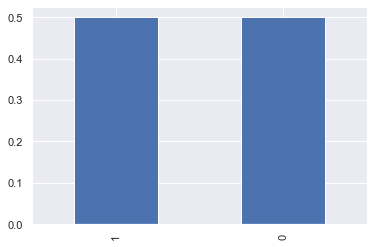

In [7]:
target_ = listings['top_listing'].value_counts(normalize=True) 
print(target_)

target_.plot(kind='bar');

As defined, the classes are balanced.

Before continuing with the EDA, let's have a look again at the *neighbourhood* column.

In [11]:
listings['neighbourhood'].value_counts()

Bedford-Stuyvesant    2624
Williamsburg          2582
Harlem                1859
Bushwick              1623
Hell's Kitchen        1423
                      ... 
Tottenville              1
Country Club             1
Gerritsen Beach          1
Fort Wadsworth           1
Graniteville             1
Name: neighbourhood, Length: 220, dtype: int64

In [12]:
len(pd.unique(listings['neighbourhood']))

220

There are 220 unique neighbourhood, which would add 219 additional features to the dataframe. Since interpretability is a relevant attribute of this model, I will disregard *neighbourhood* for the logistic regression model and consider *borough* instead. 

In [13]:
# Transform the categories of the col borough into features
listings = pd.concat([listings, pd.get_dummies(listings['borough'], drop_first = True)], axis=1)

In [14]:
# Transform the categories of the col room_type into features
listings = pd.concat([listings, pd.get_dummies(listings['room_type'], drop_first = True)], axis=1)

In [15]:
# Transform the categories of the col room_type into features
listings = pd.concat([listings, pd.get_dummies(listings['capacity'], drop_first = True)], axis=1)

In [16]:
listings.columns

Index(['id', 'host_since', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'borough', 'latitude',
       'longitude', 'room_type', 'beds', 'price', 'availability_365',
       'number_of_reviews', 'instant_bookable', 'host_listings', 'desc_len',
       'name_len', 'neighborhood_len', 'host_about_len', 'host_verif_count',
       'capacity', 'bath_private', 'baths', 'amenities_count',
       'long_term_rental', 'top_listing', 'host_in_US', 'Brooklyn',
       'Manhattan', 'Queens', 'Staten Island', 'Hotel room', 'Private room',
       'Shared room', 'medium', 'high'],
      dtype='object')

In [17]:
listings = listings.rename(columns={'high': 'capacity_high', 'medium': 'capacity_medium'})

In [18]:
listings.columns

Index(['id', 'host_since', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'borough', 'latitude',
       'longitude', 'room_type', 'beds', 'price', 'availability_365',
       'number_of_reviews', 'instant_bookable', 'host_listings', 'desc_len',
       'name_len', 'neighborhood_len', 'host_about_len', 'host_verif_count',
       'capacity', 'bath_private', 'baths', 'amenities_count',
       'long_term_rental', 'top_listing', 'host_in_US', 'Brooklyn',
       'Manhattan', 'Queens', 'Staten Island', 'Hotel room', 'Private room',
       'Shared room', 'capacity_medium', 'capacity_high'],
      dtype='object')

In [19]:
listings_clean = listings.drop(['neighbourhood','borough','latitude','longitude',
                                'room_type','availability_365'],1)

In [21]:
listings_clean.columns

Index(['id', 'host_since', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'beds', 'price', 'number_of_reviews',
       'instant_bookable', 'host_listings', 'desc_len', 'name_len',
       'neighborhood_len', 'host_about_len', 'host_verif_count', 'capacity',
       'bath_private', 'baths', 'amenities_count', 'long_term_rental',
       'top_listing', 'host_in_US', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten Island', 'Hotel room', 'Private room', 'Shared room',
       'capacity_medium', 'capacity_high'],
      dtype='object')

In [22]:
listings_clean = listings_clean.drop('capacity',1)

In [27]:
len(listings_clean.columns.tolist())

30

In [28]:
listings_clean = listings_clean[['id', 'host_since', 'host_is_superhost', 'host_has_profile_pic',
                                 'host_identity_verified', 'host_listings','host_about_len', 
                                 'host_verif_count','beds', 'baths','bath_private','price', 
                                 'number_of_reviews','instant_bookable', 'desc_len', 'name_len',
                                 'neighborhood_len','amenities_count', 'long_term_rental',
                                 'host_in_US', 'Brooklyn', 'Manhattan', 'Queens',
                                 'Staten Island', 'Hotel room', 'Private room', 'Shared room',
                                 'capacity_medium', 'capacity_high','top_listing']]

In [29]:
len(listings_clean.columns.tolist())

30

In [168]:
# Built a function that enables the selection of which features to build the pairplot on

def get_pairplot_cols(df, first_col, last_col):
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure()
    cols_to_plot = df.columns[first_col:last_col-1].tolist() + ['top_listing'] # explicitly add the column "top_listing" to your list of columns to plot
    sns.pairplot(df[cols_to_plot], hue ='top_listing')
    return plt.show();

<Figure size 432x288 with 0 Axes>

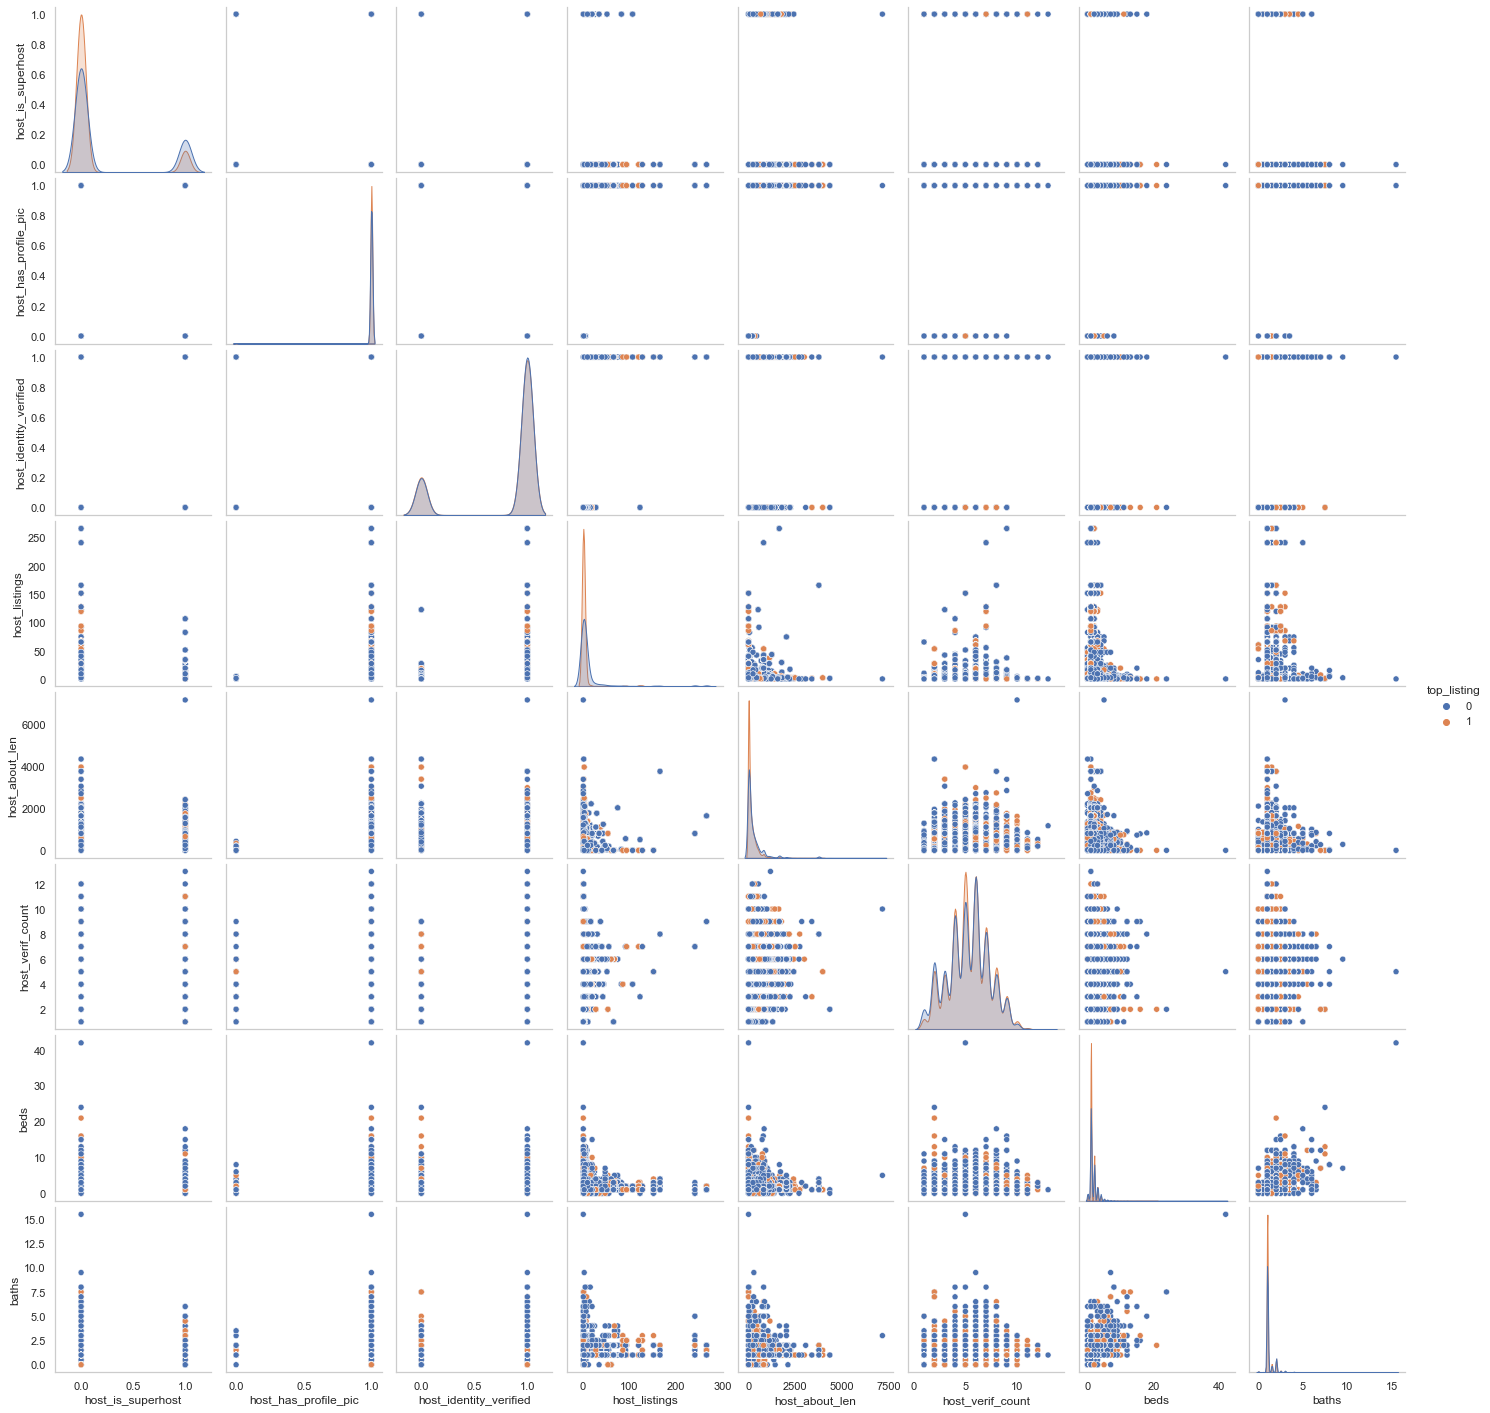

In [169]:
get_pairplot_cols(listings_clean, 1, 11)

At a first glance, looking at the first few pairplots, I notice from the densities that there is not much signal in many of the selected features.<br/>
Hence, it's appropriate to investigate the data further, starting by selecting the listings currently identified as Top Listing.

In [46]:
# Investigate top listings
listings_clean[(listings_clean['top_listing']==1)].head()

id host_since  host_is_superhost  host_has_profile_pic  \
5    5203 2009-02-05                  0                     1   
7    6848 2009-05-06                  0                     1   
12   7801 2009-06-12                  1                     1   
19  11943 2009-10-12                  0                     1   
24  13121 2009-07-27                  0                     1   

    host_identity_verified  host_listings  host_about_len  host_verif_count  \
5                        1              1             814                 7   
7                        1              1            1296                 7   
12                       0              1             299                 4   
19                       0              1               0                 1   
24                       1              5             244                 4   

    beds  baths  ...  Brooklyn  Manhattan  Queens  Staten Island  Hotel room  \
5    1.0    1.0  ...         0          1       0              0           0   
7    1.0    1.0  ...         1          0       0              0           0   
12   2.0    1.0  ...         1          0       0              0           0   
19   2.0    1.0  ...         1          0       0              0           0   
24   2.0    1.0  ...         0          0       1              0           0   

    Private room  Shared room  capacity_medium  capacity_high  top_listing  
5              1            0                0              0            1  
7              0            0                1              0            1  
12             0            0                0              1            1  
19             1            0                0              0            1  
24             1            0                0              1            1  

[5 rows x 30 columns]

In [47]:
# Read original dataframe (containing all the columns) to investigate top listings further
airbnb_nyc = pd.read_pickle('airbnb_nyc.pickle')

In [49]:
# Get the raw df
airbnb_raw = pd.read_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/Classification-Airbnb/data/nyc_listings.csv')

In [50]:
# Filter df by columns of interest
airbnb_temp = airbnb_raw[['id', 'availability_30', 'availability_60', 
                          'availability_90','availability_365','last_review']]

In [53]:
airbnb_temp.shape

(36905, 6)

In [52]:
listings_clean.shape

(35447, 30)

In [59]:
listings_complete = listings_clean.merge(airbnb_temp, how='left',on=['id'])

In [60]:
# Shape coincide with the shape of the filtered df (listings_clean). Merge was correclty executed.
listings_complete.shape

(35447, 35)

In [62]:
# Check cutoff to identify top listing
top_listings_cutoff = listings_complete['availability_365'].median()
top_listings_cutoff

56.0

This cutoff is quite low, which can both be a good and a bad element:<br/>
- Good: a low cutoff will guarantee selectivity - hence, we are only selecting truly the top listings in NYC (56/365 = 15% -- only selecting listings that are available for 15% of the year or less).<br/>
- Bad: On another note, such a low cutoff could mean that we have an inaccurate representation of *availability_365* for some of those listings featuring a *availability_365* of 0.

In [65]:
top_listings = listings_complete[(listings_complete['availability_365'] <= 56)]
top_listings[['id','top_listing','availability_30', 'availability_60', 'availability_90','availability_365','last_review']].head()

id  top_listing  availability_30  availability_60  availability_90  \
5    5203            1                0                0                0   
7    6848            1                0                0                0   
12   7801            1                1                1                1   
19  11943            1                0                0                0   
24  13121            1                1                1                1   

    availability_365 last_review  
5                  0  2017-07-21  
7                  0  2020-03-16  
12                 1  2011-12-28  
19                 0         NaN  
24                 1  2018-05-28

Indeed, it seems like there are some listings that have 0 availability in the next 365 days. From a business standpoint, I can identify three main cases where **availability_365 is zero**:<br/>
1. listing is a top listing -- we want to take this into account in computing the top listing cutoff point (i.e. median of *availability_365*)
2. listing/host is inactive -- these listings shouldn't be taken into account for the computation of top listing cutoff point
3. scraping error -- these listings shouldn't be taken into account for the computation of the top listing cutoff point

Listings falling in case 2 and 3 above should be filtered out of the computation of the cutoff point. Case 3 is not easily identifiable.<br/>
I will focus on **filtering out listings falling in Case 2**. To do this, I will use *last_review* to identify the listings that are inactive.

----

My assumption is that a listing that will be inactive if it presents **availability_365 of 0** (i.e. it is not available to book for the next 365 days) and **last_review before April 7 2020** (i.e. one year before the date where the database this model is built on was created). This definition includes also those listings that have NaN in *last_review* as my hypothesis is that a listing that has never been reviewed (i.e. relatively impopular) and has no availability for the next year is likely to be inactive.

----

In [66]:
# Identify inactive listings
inactive_listings = listings_complete[(listings_complete['availability_365'] == 0) &
                                     (listings_complete['last_review'] < '2020-04-07')]
inactive_listings[['id','top_listing','availability_30', 'availability_60', 'availability_90','availability_365','last_review']].head()

id  top_listing  availability_30  availability_60  availability_90  \
5    5203            1                0                0                0   
7    6848            1                0                0                0   
48  18961            1                0                0                0   
55  20913            1                0                0                0   
62  25406            1                0                0                0   

    availability_365 last_review  
5                  0  2017-07-21  
7                  0  2020-03-16  
48                 0  2016-03-22  
55                 0  2018-07-22  
62                 0  2018-05-26

In [67]:
inactive_listings.shape

(9421, 35)

As per this model's definition of inactive listing, there are 9421 inactive listings in this database. These rows will be deleted. 

In [68]:
# Drop inactive listings
listings_active = listings_complete.drop(listings_complete[(listings_complete['availability_365'] == 0) &
                                     (listings_complete['last_review'] < '2020-04-07')].index)

In [69]:
listings_active.shape

(26026, 35)

In [73]:
# Recompute cutoff point
top_listing_cutoff_new = listings_active['availability_365'].median()
top_listing_cutoff_new

156.0

This new cutoff point definitely seems more reasonable as we would assume to still 50% of all active listings that have more than 156 days available in the next 365 days.

In [74]:
# Establish function to identify Top Listing

def get_top_listing(availability):
    if availability <= top_listing_cutoff_new:
        top_l = 1
    else:
        top_l = 0
    return top_l

In [75]:
# Apply function to the df
listings_active['top_listing'] = listings_active['availability_365'].apply(get_top_listing)

In [77]:
listings_active['top_listing'].value_counts()

1    13030
0    12996
Name: top_listing, dtype: int64

In [78]:
listings_active.columns

Index(['id', 'host_since', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'host_listings', 'host_about_len',
       'host_verif_count', 'beds', 'baths', 'bath_private', 'price',
       'number_of_reviews', 'instant_bookable', 'desc_len', 'name_len',
       'neighborhood_len', 'amenities_count', 'long_term_rental', 'host_in_US',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Hotel room',
       'Private room', 'Shared room', 'capacity_medium', 'capacity_high',
       'top_listing', 'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'last_review'],
      dtype='object')

In [79]:
# Define df for modeling

listings_active_model = listings_active[['id', 'host_since', 'host_is_superhost', 'host_has_profile_pic',
                                           'host_identity_verified', 'host_listings', 'host_about_len',
                                           'host_verif_count', 'beds', 'baths', 'bath_private', 'price',
                                           'number_of_reviews', 'instant_bookable', 'desc_len', 'name_len',
                                           'neighborhood_len', 'amenities_count', 'long_term_rental', 'host_in_US',
                                           'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Hotel room',
                                           'Private room', 'Shared room', 'capacity_medium', 'capacity_high',
                                           'top_listing']]

<Figure size 432x288 with 0 Axes>

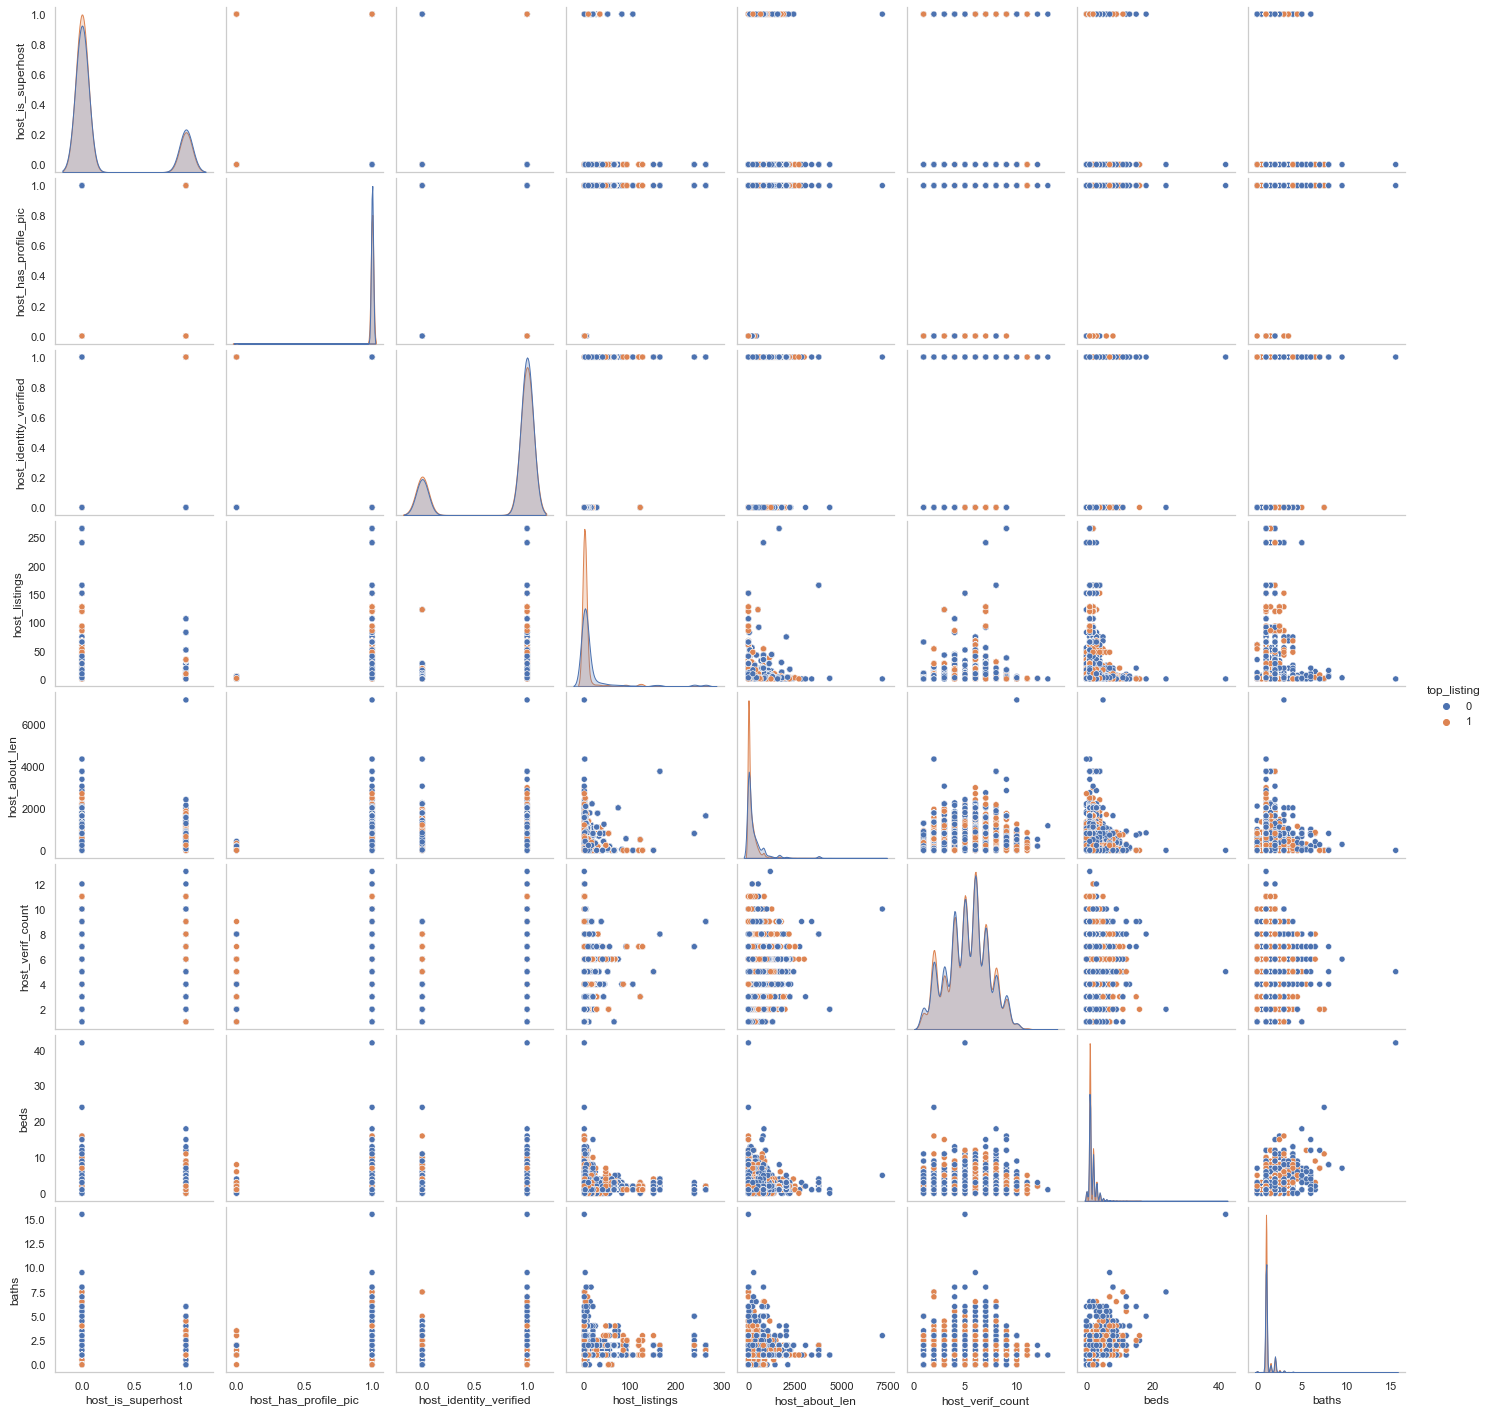

In [89]:
get_pairplot_cols(listings_active_model, 1, 11)

**PAIRPLOT 1**: *host_listings*, *host_about_len*, *beds* and *baths* seem to have a decent signal.

<Figure size 432x288 with 0 Axes>

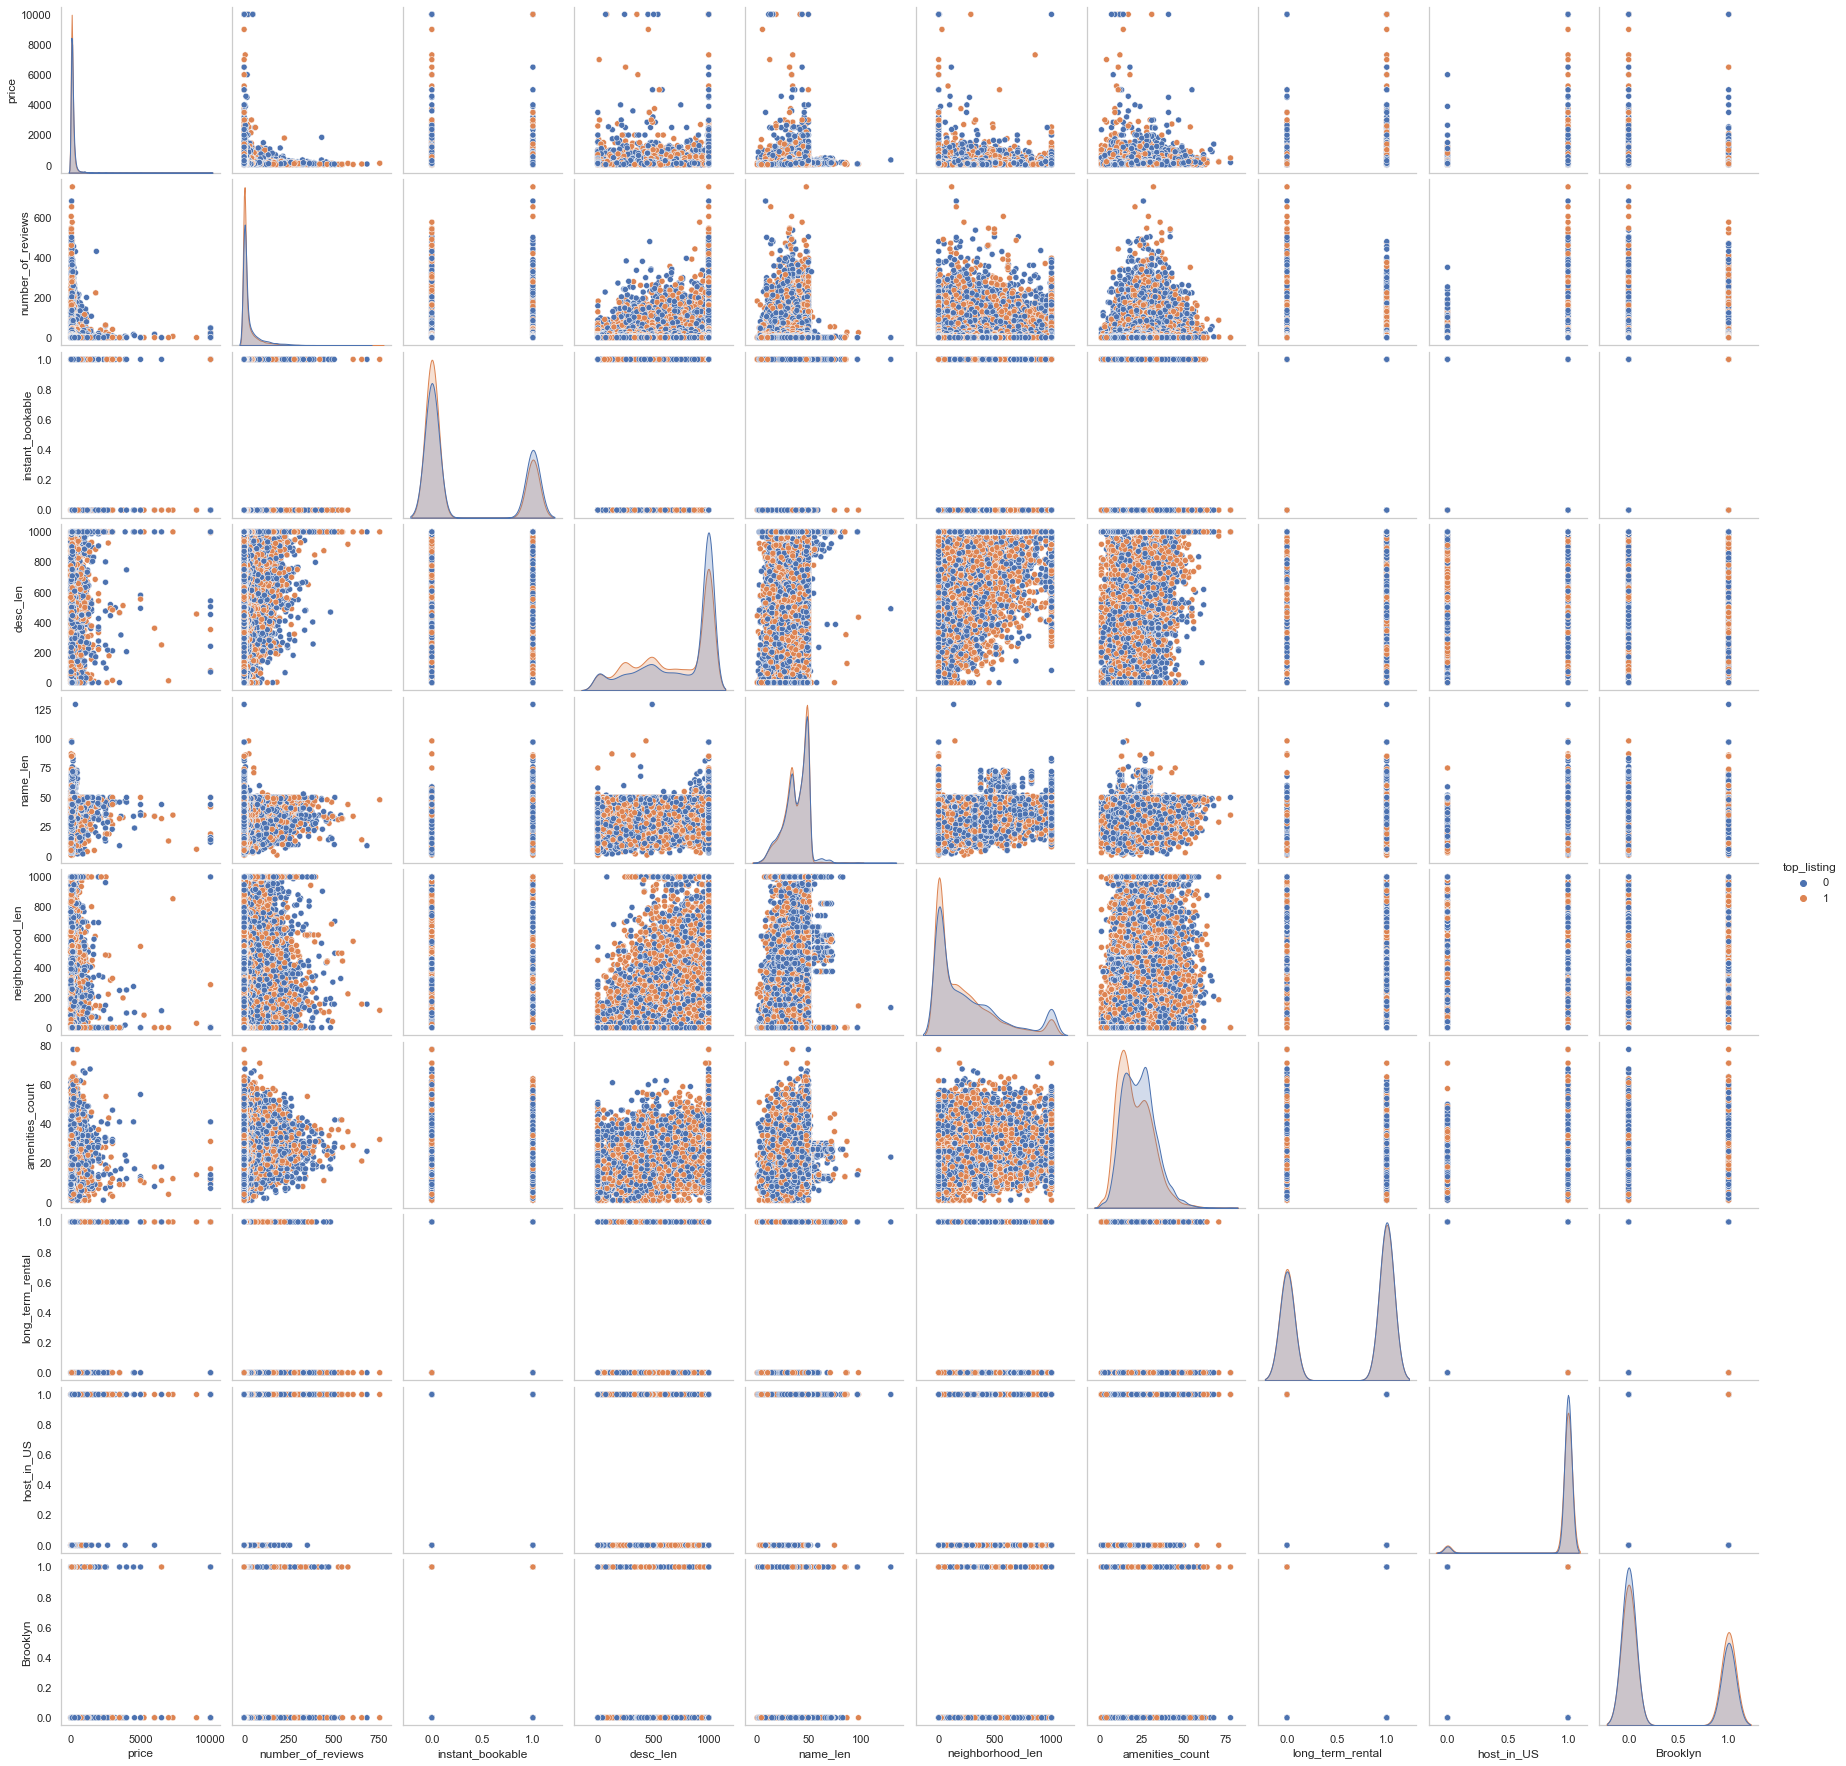

In [81]:
get_pairplot_cols(listings_active_model, 11, 21)

**PAIRPLOT 2**: *num_reviews*, *desc_len*, *amenities_count* seem to have a decent signal.

<Figure size 432x288 with 0 Axes>

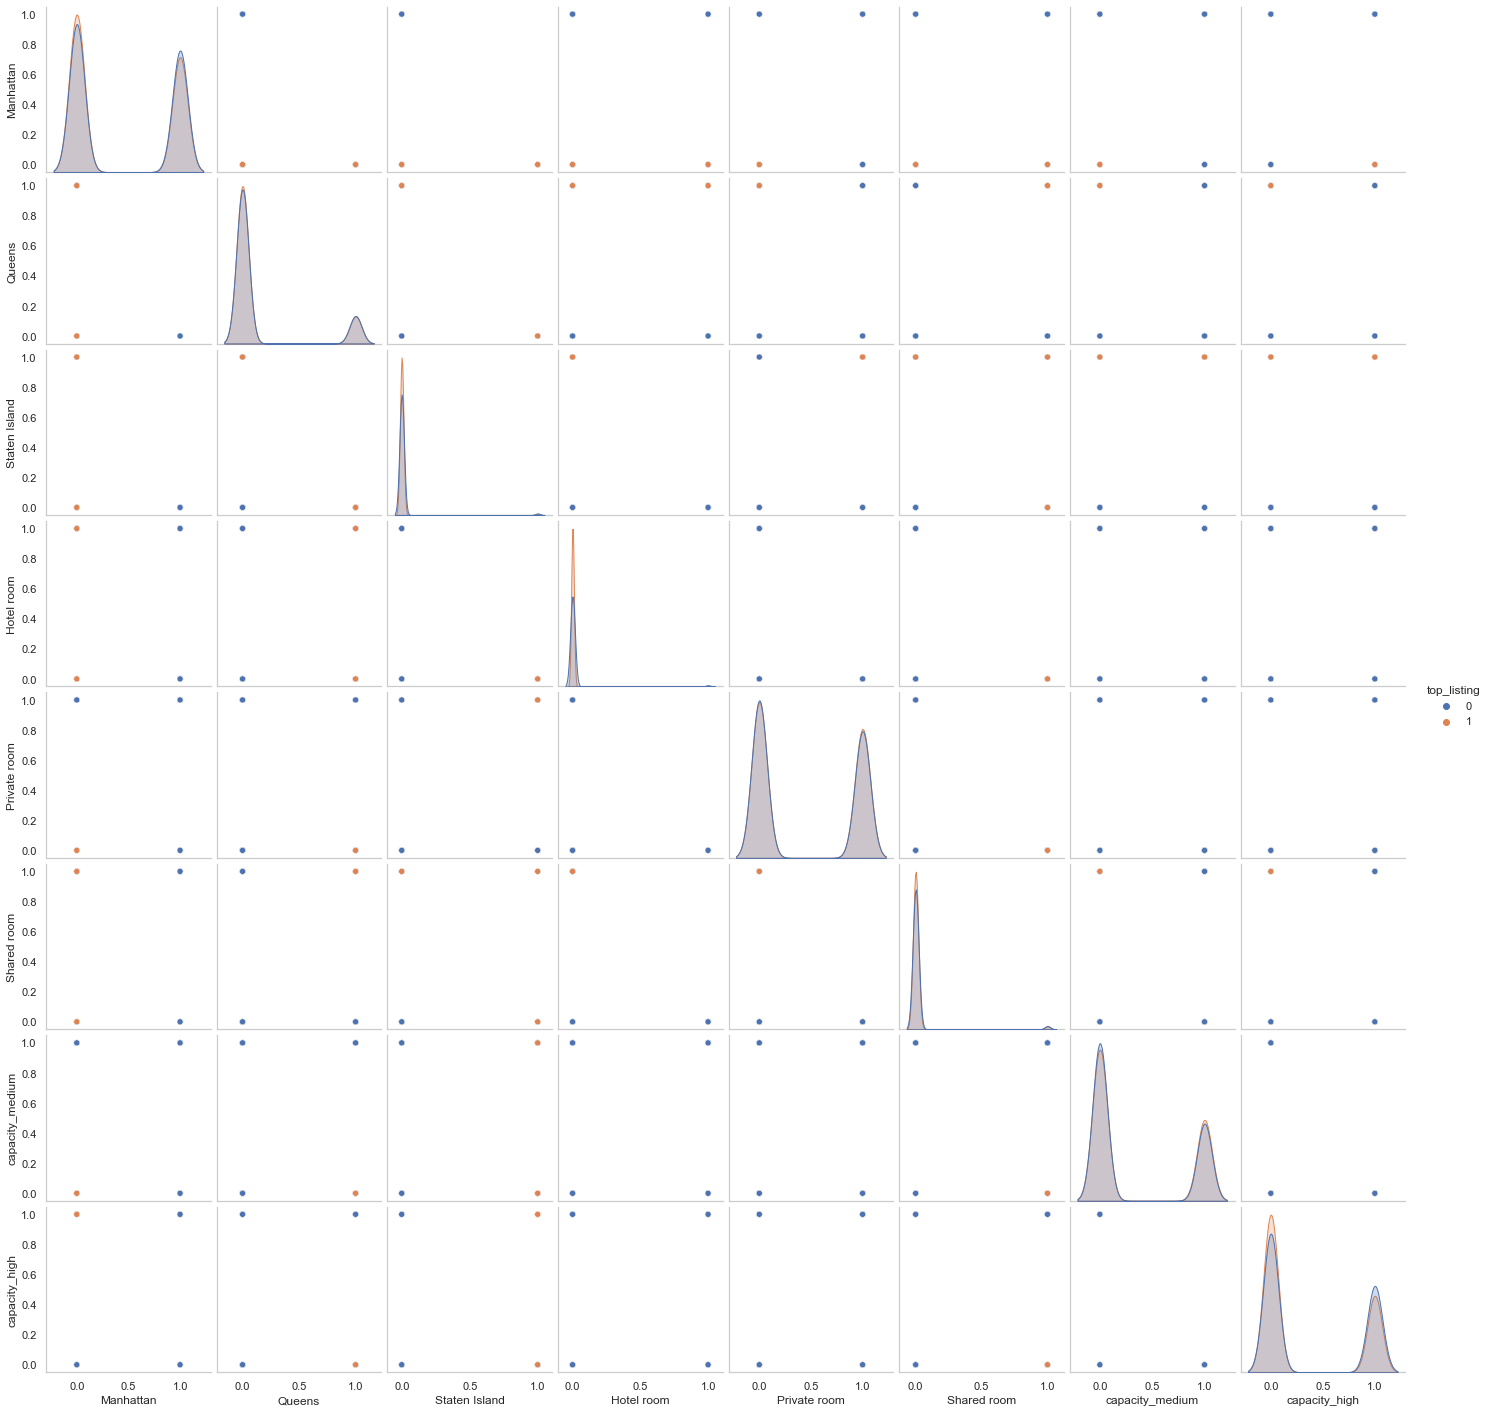

In [90]:
get_pairplot_cols(listings_active_model, 21, 30)

**PAIRPLOT 3**: generally these features do not present any strong signal, aside from a minimal signal we identify in *Hotel room*.

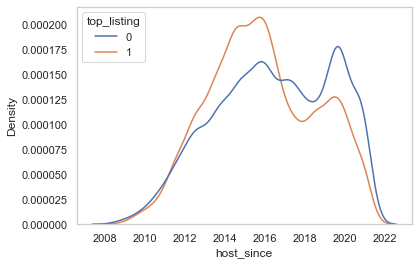

In [323]:
# Review densities for host_since
sns.kdeplot(data=listings_active_model, x='host_since',hue ='top_listing');

*Host_since* has a good degree of separability.

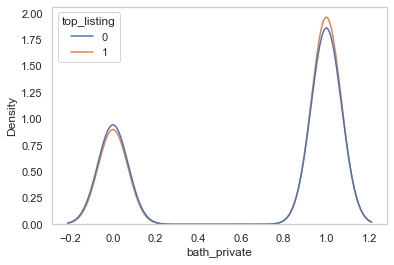

In [325]:
# Review densities for bath_private
sns.kdeplot(data=listings_active_model, x='bath_private',hue ='top_listing');

*Bath_private* does not have a good degree of separability.

In [161]:
def get_corr_matrix(df):

    # correlation df
    corr_df = df.corr()

    # mask
    mask = np.triu(np.ones_like(corr_df, dtype=np.bool))

    # adjust mask and df
    mask = mask[1:,:-1]
    corr_df = corr_df.iloc[1:,:-1].copy()
    
    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

    # plot heatmap
    sns.set(rc={"figure.figsize": (35,35)})
    sns.set_style("white")
    corr_matrix = sns.heatmap(corr_df, mask=mask, annot=True, fmt=".2f", 
                                    linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
                                    cbar_kws={"shrink": .8}, square=True)

    # ticks
    yticks = [i.upper() for i in corr_df.index]
    xticks = [i.upper() for i in corr_df.columns];

    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks)

    # title
    title = 'CORRELATION MATRIX ACTIVE LISTINGS'
    plt.title(title, loc='left', fontsize=18)
    
    return plt.show();

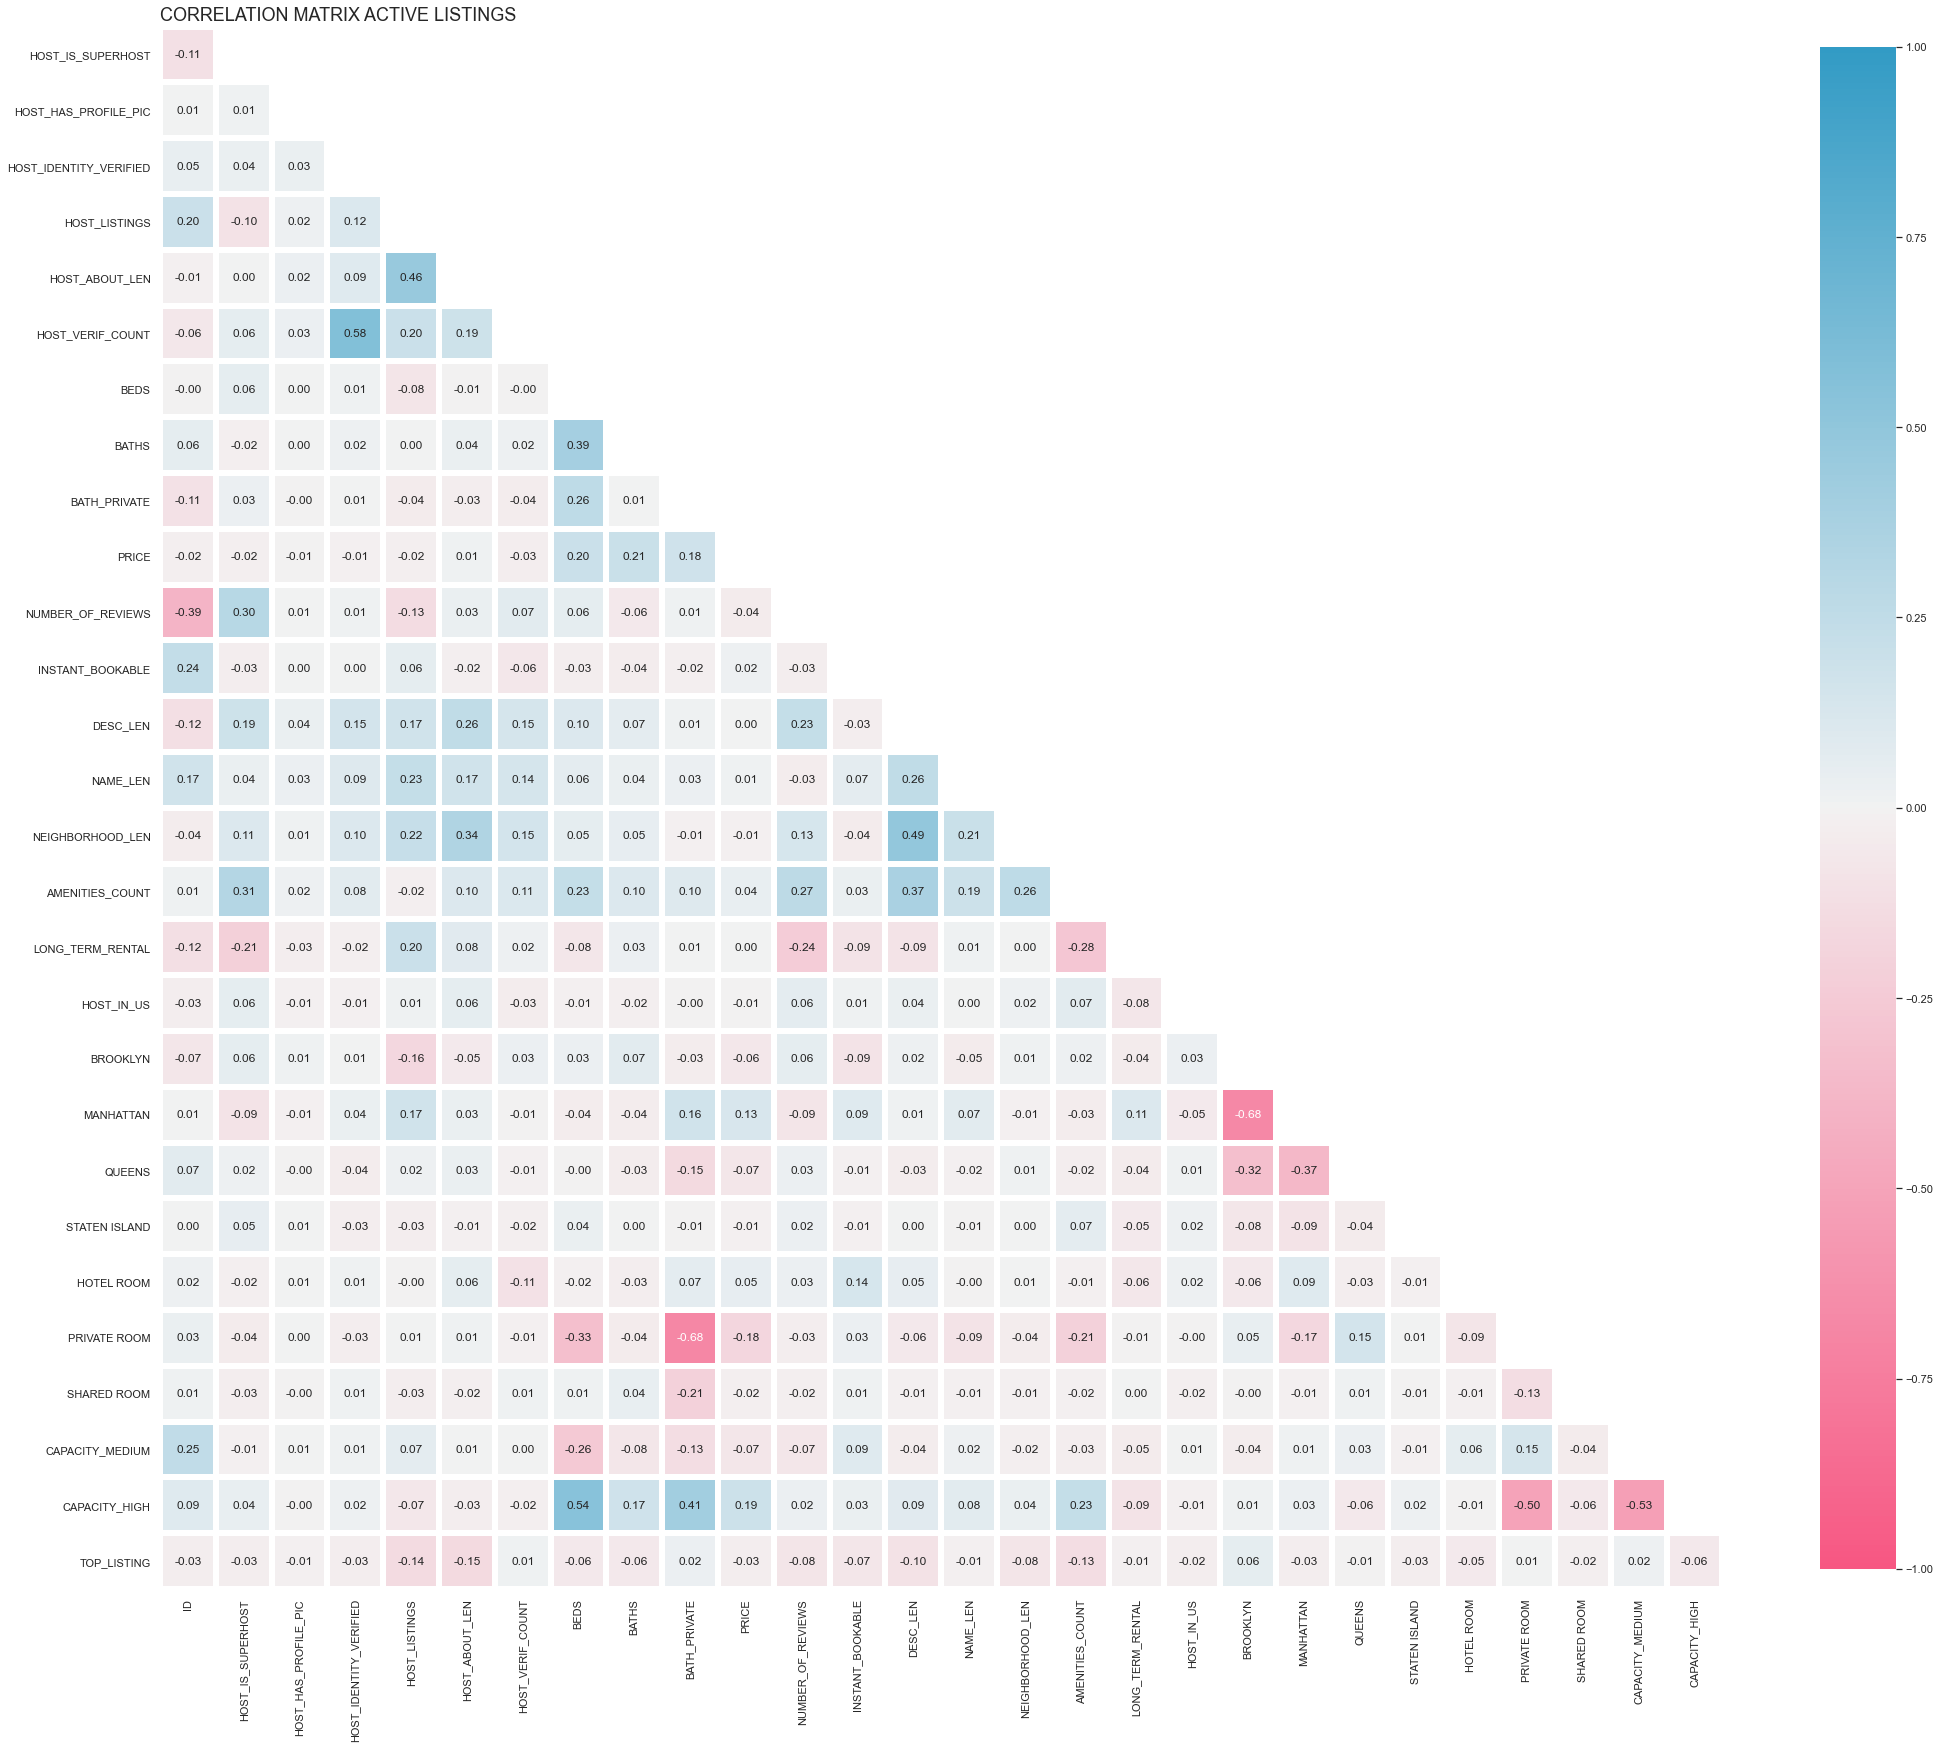

In [162]:
get_corr_matrix(listings_active_model)

In [163]:
listings_active_model.columns

Index(['id', 'host_since', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'host_listings', 'host_about_len',
       'host_verif_count', 'beds', 'baths', 'bath_private', 'price',
       'number_of_reviews', 'instant_bookable', 'desc_len', 'name_len',
       'neighborhood_len', 'amenities_count', 'long_term_rental', 'host_in_US',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Hotel room',
       'Private room', 'Shared room', 'capacity_medium', 'capacity_high',
       'top_listing'],
      dtype='object')

### Run the baseline model with simple validation: Logistic Regression vs KNN

For the purpose of baselining the model, I will only choose the few features that showed a signal (even if minor) from the three pairplots above.

In [216]:
# Choose features and target for baseline model
baseline_features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count']]
target = listings_active_model['top_listing']

In [217]:
# Use simple validation for the purpose of baselining the model

# define scaler
scaler = StandardScaler()

# split data
X_train, X_test, y_train, y_test = train_test_split(baseline_features, target, test_size = 0.2, random_state=42)

# scale data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression -- define and fit model on training data
lm_baseline = LogisticRegression(C=1)
lm_baseline.fit(X_train_scaled, y_train)

# logistic regression -- compute prediction on testing data
logreg_y_pred = lm_baseline.predict(X_test_scaled)

# knn -- define and fit model on training data
knn_baseline = KNeighborsClassifier(n_neighbors=10)
knn_baseline.fit(X_train_scaled, y_train)

# knn -- compute prediction on testing data
knn_y_pred = knn_baseline.predict(X_test_scaled)

# logistic regression - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
logreg_accuracy_baseline = lm_baseline.score(X_test_scaled, y_test)
logreg_fbeta_baseline = fbeta_score(y_test, logreg_y_pred, beta=0.35) # favoring precision (see rationale above)

# knn - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
knn_accuracy_baseline = knn_baseline.score(X_test_scaled, y_test)
knn_fbeta_baseline = fbeta_score(y_test, knn_y_pred, beta=0.35) # favoring precision (see rationale above)

print('\nLogReg | Baseline Test Accuracy score: \t', '{0:.4g}'.format(logreg_accuracy_baseline))
print('LogReg | Baseline Test F1 beta score: \t', '{0:.4g}'.format(logreg_fbeta_baseline))
print('\nKNN (K=10) | Baseline Test Accuracy score: \t', '{0:.4g}'.format(knn_accuracy_baseline))
print('KNN (K=10) | Baseline Test F1 beta score: \t', '{0:.4g}'.format(knn_fbeta_baseline))


LogReg | Baseline Test Accuracy score: 	 0.5887
LogReg | Baseline Test F1 beta score: 	 0.5883

KNN (K=10) | Baseline Test Accuracy score: 	 0.6164
KNN (K=10) | Baseline Test F1 beta score: 	 0.6246


The KNN model can be optimized by selecting the K that minimizes the error rate or the K that mazimizes the F1 beta (better approach for our purpose). We'll show both approaches below.

Minimum error:- 0.3739915482135997 at K = 24


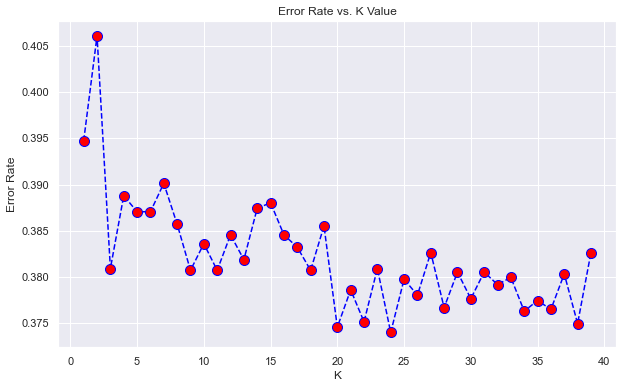

In [218]:
# Approach 1: Find the K that minimizes the error rate 

error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",(error_rate.index(min(error_rate))+1))

In [219]:
# Rerun the scoring code with the optimal K = 24

# define scaler
scaler = StandardScaler()

# split data
X_train, X_test, y_train, y_test = train_test_split(baseline_features, target, test_size = 0.2, random_state=42)

# scale data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression -- define and fit model on training data
lm_baseline = LogisticRegression(C=1)
lm_baseline.fit(X_train_scaled, y_train)

# logistic regression -- compute prediction on testing data
logreg_y_pred = lm_baseline.predict(X_test_scaled)

# knn -- define and fit model on training data
knn_baseline = KNeighborsClassifier(n_neighbors=24)
knn_baseline.fit(X_train_scaled, y_train)

# knn -- compute prediction on testing data
knn_y_pred = knn_baseline.predict(X_test_scaled)

# logistic regression - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
logreg_accuracy_baseline = lm_baseline.score(X_test_scaled, y_test)
logreg_fbeta_baseline = fbeta_score(y_test, logreg_y_pred, beta=0.35) # favoring precision (see rationale above)

# knn - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
knn_accuracy_baseline = knn_baseline.score(X_test_scaled, y_test)
knn_fbeta_baseline = fbeta_score(y_test, knn_y_pred, beta=0.35) # favoring precision (see rationale above)

print('\nLogReg | Baseline Test Accuracy score: \t', '{0:.4g}'.format(logreg_accuracy_baseline))
print('LogReg | Baseline Test F1 beta score: \t', '{0:.4g}'.format(logreg_fbeta_baseline))
print('\nKNN (K=24) | Baseline Test Accuracy score: \t', '{0:.4g}'.format(knn_accuracy_baseline))
print('KNN (K=24) | Baseline Test F1 beta score: \t', '{0:.4g}'.format(knn_fbeta_baseline))


LogReg | Baseline Test Accuracy score: 	 0.5887
LogReg | Baseline Test F1 beta score: 	 0.5883

KNN (K=24) | Baseline Test Accuracy score: 	 0.626
KNN (K=24) | Baseline Test F1 beta score: 	 0.6294


Maximum F1 Beta:  0.6299243529596624 at K = 20


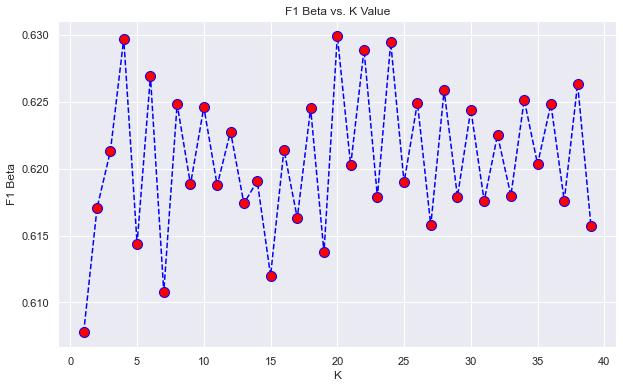

In [220]:
# Approach 2: Find the K that maximizes F1 beta (our optimization metric of choice for this model) 

f1_beta = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    knn_fbeta = fbeta_score(y_test, pred_i, beta=0.35)
    f1_beta.append(knn_fbeta)

plt.figure(figsize=(10,6))
plt.plot(range(1,40),f1_beta,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('F1 Beta vs. K Value')
plt.xlabel('K')
plt.ylabel('F1 Beta')
print("Maximum F1 Beta: ",max(f1_beta),"at K =",(f1_beta.index(max(f1_beta)))+1)

In [221]:
# Rerun the code with the optimal K = 20

# define scaler
scaler = StandardScaler()

# split data
X_train, X_test, y_train, y_test = train_test_split(baseline_features, target, test_size = 0.2, random_state=42)

# scale data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression -- define and fit model on training data
lm_baseline = LogisticRegression(C=1)
lm_baseline.fit(X_train_scaled, y_train)

# logistic regression -- compute prediction on testing data
logreg_y_pred = lm_baseline.predict(X_test_scaled)

# knn -- define and fit model on training data
knn_baseline = KNeighborsClassifier(n_neighbors=20)
knn_baseline.fit(X_train_scaled, y_train)

# knn -- compute prediction on testing data
knn_y_pred = knn_baseline.predict(X_test_scaled)

# logistic regression - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
logreg_accuracy_baseline = lm_baseline.score(X_test_scaled, y_test)
logreg_fbeta_baseline = fbeta_score(y_test, logreg_y_pred, beta=0.35) # favoring precision (see rationale above)

# knn - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
knn_accuracy_baseline = knn_baseline.score(X_test_scaled, y_test)
knn_fbeta_baseline = fbeta_score(y_test, knn_y_pred, beta=0.35) # favoring precision (see rationale above)

print('\nLogReg | Baseline Test Accuracy score: \t', '{0:.4g}'.format(logreg_accuracy_baseline))
print('LogReg | Baseline Test F1 beta score: \t', '{0:.4g}'.format(logreg_fbeta_baseline))
print('\nKNN (K=20) | Baseline Test Accuracy score: \t', '{0:.4g}'.format(knn_accuracy_baseline))
print('KNN (K=20) | Baseline Test F1 beta score: \t', '{0:.4g}'.format(knn_fbeta_baseline))


LogReg | Baseline Test Accuracy score: 	 0.5887
LogReg | Baseline Test F1 beta score: 	 0.5883

KNN (K=20) | Baseline Test Accuracy score: 	 0.6254
KNN (K=20) | Baseline Test F1 beta score: 	 0.6299


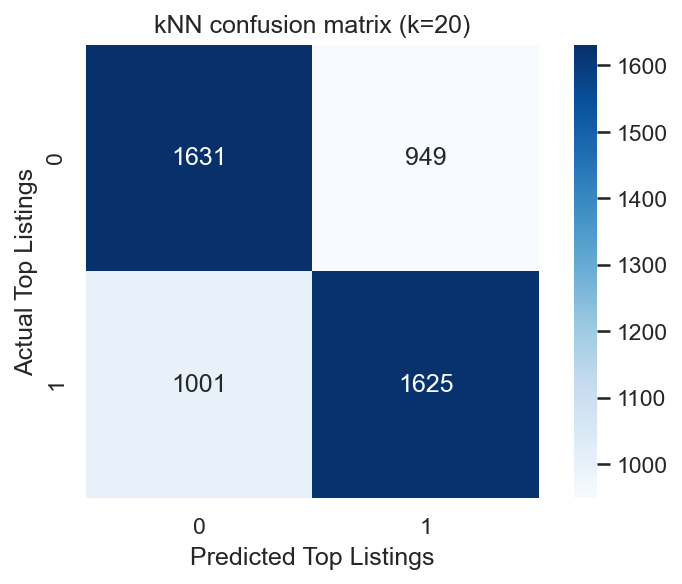

In [231]:
# Print confusion matrix for kNN with k = 20
knn_confusion = confusion_matrix(y_test, knn_baseline.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt=".0f")

plt.xlabel('Predicted Top Listings')
plt.ylabel('Actual Top Listings')
plt.title('kNN confusion matrix (k=20)');

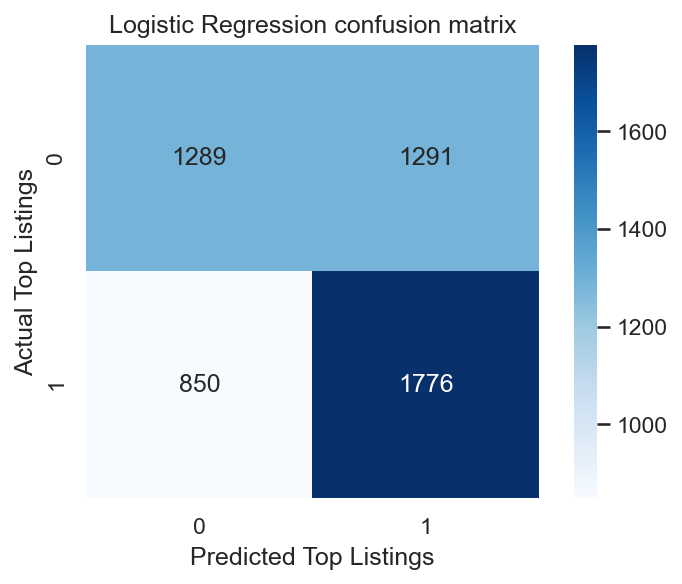

In [234]:
# Print confusion matrix for Logistic Regression
logreg_confusion = confusion_matrix(y_test, lm_baseline.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(logreg_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt=".0f")

plt.xlabel('Predicted Top Listings')
plt.ylabel('Actual Top Listings')
plt.title('Logistic Regression confusion matrix');

Looking at the confusion matrices for both the logistic regression and the kNN models, we can confirm that kNN with k=20 is better at classifying new observations, at least in this baseline phase.

----

Both the Logistic Regression and the KNN model with a **K equal to 20** will be included in the final cross validation scheme for model evaluation.

----

## Feature Engineering & Model Expansion

The baseline model needs optimization.<br />
In this section, we will iterate on both the logistic regression and the knn models and iteratively check on scoring improvements thorugh simple validation. Finally, we will conduct cross-validation to choose the best version of the model that maximizes the F1 beta score.

In [633]:
# collect list of models
logreg_models = {'logreg_baseline':float('{0:.4g}'.format(logreg_fbeta_baseline))}
knn_models = {'knn_baseline':float('{0:.4g}'.format(knn_fbeta_baseline))}

In [634]:
# Define function to run simple validation on the model iterations
    
# define scaler
scaler = StandardScaler()

# define function
def simple_validation_logreg_knn(features, target):
    
    # count number of models stored in dictionaries
    logreg_models_count = len(logreg_models)
    knn_models_count = len(knn_models)
    
    # establish indeces for logreg dictionary
    if logreg_models_count == 1:
        i = 1
    else:
        i = logreg_models_count
    
    # establish indeces for knn dictionary
    if knn_models_count == 1:
        j = 1
    else:
        j = knn_models_count
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

    # scale data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # logistic regression -- define and fit model on training data
    logreg = LogisticRegression(C=1)
    logreg.fit(X_train_scaled, y_train)

    # logistic regression -- compute prediction on testing data
    logreg_y_pred = logreg.predict(X_test_scaled)

    # knn -- define and fit model on training data
    knn = KNeighborsClassifier(n_neighbors=20) # optimal k of 20
    knn.fit(X_train_scaled, y_train)

    # knn -- compute prediction on testing data
    knn_y_pred = knn.predict(X_test_scaled)

    # logistic regression - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
    logreg_accuracy = logreg.score(X_test_scaled, y_test)
    logreg_fbeta = fbeta_score(y_test, logreg_y_pred, beta=0.35) # favoring precision (see rationale above)

    # knn - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
    knn_accuracy = knn.score(X_test_scaled, y_test)
    knn_fbeta = fbeta_score(y_test, knn_y_pred, beta=0.35) # favoring precision (see rationale above)
    
    logreg_models['logreg_'+str(i)] = float('{0:.4g}'.format(logreg_fbeta))
    knn_models['knn_'+str(j)] = float('{0:.4g}'.format(knn_fbeta))
    
    print('\nLogReg_'+str(i)+'| Test Accuracy score: \t', '{0:.4g}'.format(logreg_accuracy))
    print('LogReg_'+str(i)+'| Test F1 beta score: \t', '{0:.4g}'.format(logreg_fbeta))
    print('\nKNN (K=20)_'+str(j)+'| Test Accuracy score: \t', '{0:.4g}'.format(knn_accuracy))
    print('KNN (K=20)_'+str(j)+'| Test F1 beta score: \t', '{0:.4g}'.format(knn_fbeta))
    
    pass

### Model 1 | Number of Rooms

In [246]:
# Create a new feature called num_rooms as the sum of beds and baths
listings_active_model['num_rooms'] = listings_active_model['beds'] + listings_active_model['baths']

In [635]:
# Substitute num_rooms to beds and baths
features = listings_active_model[['host_listings','host_about_len','num_rooms','number_of_reviews','desc_len','amenities_count']]
target = listings_active_model['top_listing']

In [636]:
simple_validation_logreg_knn(features, target)


LogReg_1| Test Accuracy score: 	 0.588
LogReg_1| Test F1 beta score: 	 0.5876

KNN (K=20)_1| Test Accuracy score: 	 0.6185
KNN (K=20)_1| Test F1 beta score: 	 0.6224


In [637]:
logreg_models

{'logreg_baseline': 0.5883, 'logreg_1': 0.5876}

In [638]:
knn_models

{'knn_baseline': 0.6299, 'knn_1': 0.6224}

Model 1 underperforms with respect to the baseline for both logistic regression and knn.

### Model 2 | Content Length

In [308]:
# Create a new feature called content_len to measure the descriptive power (length of content-related items) of a listing 
listings_active_model['content_len'] = listings_active_model['host_about_len']+listings_active_model['desc_len']+listings_active_model['name_len']+listings_active_model['neighborhood_len']

In [639]:
# Substitute content_len to desc_len and host_about_len
features = listings_active_model[['host_listings','beds','baths','content_len','number_of_reviews','amenities_count']]
target = listings_active_model['top_listing']

In [640]:
simple_validation_logreg_knn(features, target)


LogReg_2| Test Accuracy score: 	 0.583
LogReg_2| Test F1 beta score: 	 0.5838

KNN (K=20)_2| Test Accuracy score: 	 0.6131
KNN (K=20)_2| Test F1 beta score: 	 0.6182


In [641]:
logreg_models

{'logreg_baseline': 0.5883, 'logreg_1': 0.5876, 'logreg_2': 0.5838}

In [642]:
knn_models

{'knn_baseline': 0.6299, 'knn_1': 0.6224, 'knn_2': 0.6182}

Model 2 does not present an improvement with respect to the baseline.

### Model 3 | Host Since

In [332]:
# Extract year from host_since
listings_active_model['host_since_year'] = listings_active_model['host_since'].dt.year

In [333]:
listings_active_model['host_since_year'].value_counts()

2015    3529
2014    3182
2019    3020
2016    3007
2013    2441
2017    2305
2018    2174
2020    2162
2012    1955
2011    1135
2010     481
2021     429
2009     182
2008      24
Name: host_since_year, dtype: int64

In [335]:
# Convert host_since to float for it to be ingested by the logistic regression
listings_active_model['host_since_converted'] = listings_active_model['host_since'].map(datetime.datetime.toordinal)

In [643]:
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted']]
target = listings_active_model['top_listing']

In [644]:
simple_validation_logreg_knn(features, target)


LogReg_3| Test Accuracy score: 	 0.6072
LogReg_3| Test F1 beta score: 	 0.6063

KNN (K=20)_3| Test Accuracy score: 	 0.6312
KNN (K=20)_3| Test F1 beta score: 	 0.6373


In [645]:
# Create function to automate delivery of model scoring results
def model_iterations(logreg_model_dict,knn_model_dict):
    for key, value in logreg_model_dict.items():
        print(key, ' :', value)
    
    print('')
    
    for key, value in knn_model_dict.items():
        print(key, ' :', value)
    pass

In [646]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373


The inclusion of *host_since_converted* had a positive impact on the model F1beta score. Model 3 is our winner model for now.

### Model 4 | Superhost

In [647]:
# Iterate on temporary winner model 3 and add host_superhost
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'host_is_superhost']]
target = listings_active_model['top_listing']

In [648]:
simple_validation_logreg_knn(features, target)


LogReg_4| Test Accuracy score: 	 0.6081
LogReg_4| Test F1 beta score: 	 0.6071

KNN (K=20)_4| Test Accuracy score: 	 0.6291
KNN (K=20)_4| Test F1 beta score: 	 0.6354


In [649]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354


The improvement is minor for logistic regression only. I will not consider superhost as a feature of the model. 

### Model 5 | Host Verifications

In [650]:
# Iterate on temporary winner model 3 and add host_verif_count
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'host_verif_count']]
target = listings_active_model['top_listing']

In [651]:
simple_validation_logreg_knn(features, target)


LogReg_5| Test Accuracy score: 	 0.6049
LogReg_5| Test F1 beta score: 	 0.604

KNN (K=20)_5| Test Accuracy score: 	 0.6293
KNN (K=20)_5| Test F1 beta score: 	 0.6348


In [652]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348


Both logistic regression and kNN show a decrease in F1beta with the introduction of *host_verif_count*. I will therefore not include this feature in the model.

### Model 6 | Price

In [653]:
# Iterate on temporary winner model 3 and add price
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'price']]
target = listings_active_model['top_listing']

In [654]:
simple_validation_logreg_knn(features, target)


LogReg_6| Test Accuracy score: 	 0.608
LogReg_6| Test F1 beta score: 	 0.6069

KNN (K=20)_6| Test Accuracy score: 	 0.6289
KNN (K=20)_6| Test F1 beta score: 	 0.6339


In [655]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339


The inclusion of *price* has generated no relevant improvement in the F1beta score. I will try to include an interaction term: price per person, defined as *price*
divided by *accommodates* (i.e. numerical version of a listing's capacity).

### Model 7 | Price per person

In [372]:
# Look for column accommodates
airbnb_nyc.columns

Index(['id', 'listing_url', 'name', 'description', 'neighborhood_overview',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'borough', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'host_listings', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculat

In [373]:
airbnb_temp = airbnb_nyc[['id', 'capacity']]

In [374]:
listings_active_model.shape

(26026, 34)

In [377]:
listings_active_model = listings_active_model.merge(airbnb_temp, how='left',on=['id'])

In [378]:
# Check merge executed correctly
listings_active_model.shape

(26026, 35)

In [383]:
airbnb_temp = airbnb_nyc[['id', 'accommodates']]

In [384]:
listings_active_model.shape

(26026, 35)

In [385]:
listings_active_model = listings_active_model.merge(airbnb_temp, how='left',on=['id'])

In [386]:
# Check merge executed correctly
listings_active_model.shape

(26026, 36)

In [387]:
# Interaction term "price per person"
listings_active_model['price_pp'] = listings_active_model['price']/listings_active_model['accommodates']

In [656]:
# Iterate on temporary winner model 3 and add price
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'price_pp']]
target = listings_active_model['top_listing']

In [657]:
simple_validation_logreg_knn(features, target)


LogReg_7| Test Accuracy score: 	 0.6072
LogReg_7| Test F1 beta score: 	 0.6064

KNN (K=20)_7| Test Accuracy score: 	 0.632
KNN (K=20)_7| Test F1 beta score: 	 0.6377


In [658]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377


The interaction term had a very minor improvement vis-a-vis model 3, our current winner.

### Model 8 | Instant bookable

In [659]:
# Iterate on temporary winner model 3
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable']]
target = listings_active_model['top_listing']

In [660]:
simple_validation_logreg_knn(features, target)


LogReg_8| Test Accuracy score: 	 0.6093
LogReg_8| Test F1 beta score: 	 0.6085

KNN (K=20)_8| Test Accuracy score: 	 0.6285
KNN (K=20)_8| Test F1 beta score: 	 0.6346


In [661]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346


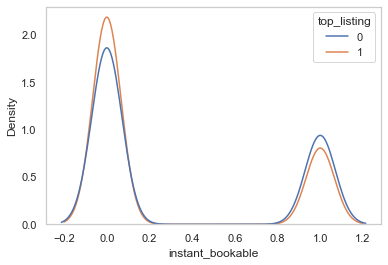

In [399]:
# Review densities
sns.kdeplot(data=listings_active_model, x='instant_bookable',hue ='top_listing');

The inclusion of *instant_bookable* has a positive impact on the F1 beta of the logistic regression. I will keep this feature in for future model iterations.

### Model 9 | Host in the US

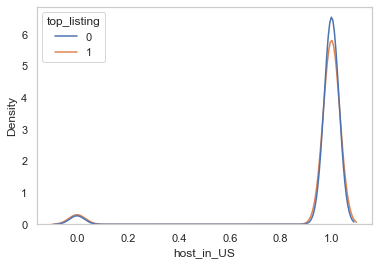

In [400]:
# Review densities
sns.kdeplot(data=listings_active_model, x='host_in_US',hue ='top_listing');

Having reviewed the densities, I am not expecting much signal from the inclusion of this feature. 

In [662]:
# Iterate on temporary winner model 8
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US']]
target = listings_active_model['top_listing']

In [663]:
simple_validation_logreg_knn(features, target)


LogReg_9| Test Accuracy score: 	 0.6124
LogReg_9| Test F1 beta score: 	 0.6114

KNN (K=20)_9| Test Accuracy score: 	 0.6314
KNN (K=20)_9| Test F1 beta score: 	 0.6371


In [664]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371


We are actually getting some signal from *host_in_US*. I will hence keep it in the future versions of the model.

### Model 10 | Borough (Brooklyn)

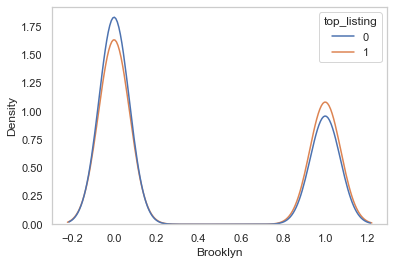

In [404]:
# Brooklyn
sns.kdeplot(data=listings_active_model, x='Brooklyn',hue ='top_listing');

In [665]:
# Iterate on temporary winner model 9
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn']]
target = listings_active_model['top_listing']

In [666]:
simple_validation_logreg_knn(features, target)


LogReg_10| Test Accuracy score: 	 0.6131
LogReg_10| Test F1 beta score: 	 0.6122

KNN (K=20)_10| Test Accuracy score: 	 0.6341
KNN (K=20)_10| Test F1 beta score: 	 0.639


In [667]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639


We get some signal from the inclusion of *Brooklyn*. I will keep this feature in future iterations of the model.

### Model 11 | Borough (Manhattan)

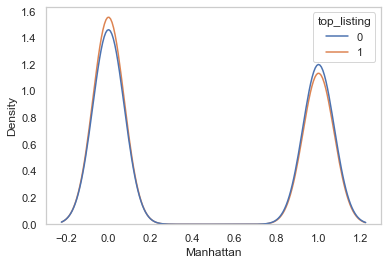

In [405]:
# Review densities
sns.kdeplot(data=listings_active_model, x='Manhattan',hue ='top_listing');

In [668]:
# Iterate on temporary winner model 10
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Manhattan']]
target = listings_active_model['top_listing']

In [669]:
simple_validation_logreg_knn(features, target)


LogReg_11| Test Accuracy score: 	 0.6139
LogReg_11| Test F1 beta score: 	 0.6129

KNN (K=20)_11| Test Accuracy score: 	 0.6393
KNN (K=20)_11| Test F1 beta score: 	 0.6433


In [670]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433


The inclusion of this feature has close to no impact on the F1 beta score. I will not include it in the future versions of the model.

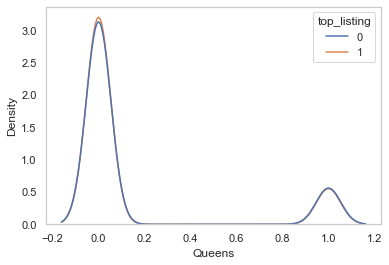

In [406]:
# Review densities
sns.kdeplot(data=listings_active_model, x='Queens',hue ='top_listing');

I am not expecting to getting any signal from the inclusion of *Queens*. Hence, I will not include it in the model.

### Model 12 | Borough (Staten Island)

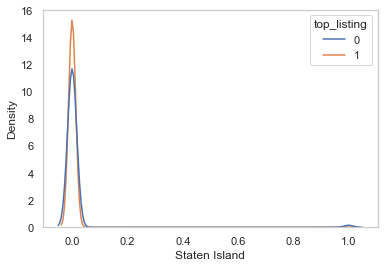

In [407]:
# Review densities
sns.kdeplot(data=listings_active_model, x='Staten Island',hue ='top_listing');

In [671]:
# Iterate on temporary winner model 10
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Staten Island']]
target = listings_active_model['top_listing']

In [672]:
simple_validation_logreg_knn(features, target)


LogReg_12| Test Accuracy score: 	 0.6133
LogReg_12| Test F1 beta score: 	 0.6124

KNN (K=20)_12| Test Accuracy score: 	 0.6358
KNN (K=20)_12| Test F1 beta score: 	 0.6408


In [673]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408


Not much signal is added by this feature. I will not include *Staten Island* in the future versopms of the model.

### Model 13 | Room Type (Hotel Room)

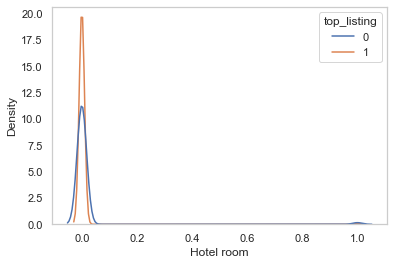

In [417]:
# Review densities
sns.kdeplot(data=listings_active_model, x='Hotel room',hue ='top_listing');

In [674]:
# Iterate on temporary winner model 10
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room']]
target = listings_active_model['top_listing']

In [675]:
simple_validation_logreg_knn(features, target)


LogReg_13| Test Accuracy score: 	 0.617
LogReg_13| Test F1 beta score: 	 0.6153

KNN (K=20)_13| Test Accuracy score: 	 0.635
KNN (K=20)_13| Test F1 beta score: 	 0.64


In [676]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64


A minor signal is detected in logistic regression. I will keep this feature in future versions of the model.

### Model 14 | Shared Rooms

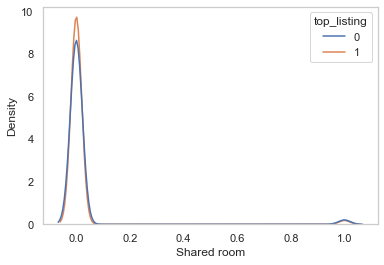

In [422]:
# Review densities
sns.kdeplot(data=listings_active_model, x='Shared room',hue ='top_listing');

In [677]:
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room','Shared room']]
target = listings_active_model['top_listing']

In [678]:
simple_validation_logreg_knn(features, target)


LogReg_14| Test Accuracy score: 	 0.6172
LogReg_14| Test F1 beta score: 	 0.6157

KNN (K=20)_14| Test Accuracy score: 	 0.6387
KNN (K=20)_14| Test F1 beta score: 	 0.6437


In [679]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437


No relevant signal is detected. *Shared room* will not be part of future versions of the model.

### Model 15 | High Capacity

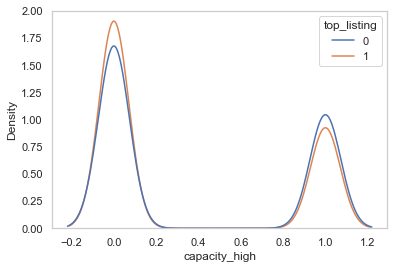

In [431]:
# Review densities
sns.kdeplot(data=listings_active_model, x='capacity_high',hue ='top_listing');

In [680]:
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room','capacity_high']]
target = listings_active_model['top_listing']

In [681]:
simple_validation_logreg_knn(features, target)


LogReg_15| Test Accuracy score: 	 0.617
LogReg_15| Test F1 beta score: 	 0.6151

KNN (K=20)_15| Test Accuracy score: 	 0.6289
KNN (K=20)_15| Test F1 beta score: 	 0.633


In [682]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157
logreg_15  : 0.6151

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437
knn_15  : 0.633


No relevant signal. Model 14 is still the current winner.

### Model 16 | Name Length

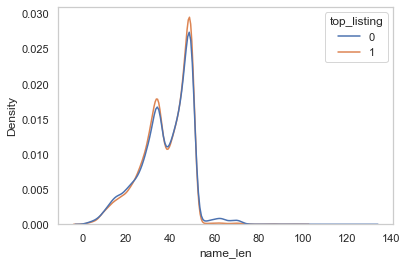

In [432]:
# Review densities
sns.kdeplot(data=listings_active_model, x='name_len',hue ='top_listing');

In [683]:
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room','name_len']]
target = listings_active_model['top_listing']

In [684]:
simple_validation_logreg_knn(features, target)


LogReg_16| Test Accuracy score: 	 0.6085
LogReg_16| Test F1 beta score: 	 0.6076

KNN (K=20)_16| Test Accuracy score: 	 0.6354
KNN (K=20)_16| Test F1 beta score: 	 0.6392


In [685]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157
logreg_15  : 0.6151
logreg_16  : 0.6076

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437
knn_15  : 0.633
knn_16  : 0.6392


No improvement. Let's disregard this feature in future versions of the model.

### Model 17 | Neighborhood length

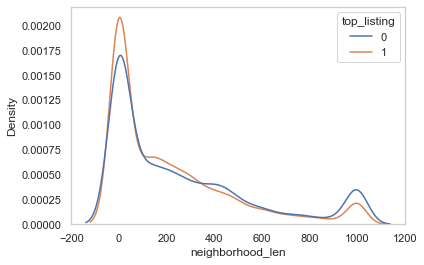

In [436]:
# Review densities
sns.kdeplot(data=listings_active_model, x='neighborhood_len',hue ='top_listing');

In [686]:
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room','neighborhood_len']]
target = listings_active_model['top_listing']

In [687]:
simple_validation_logreg_knn(features, target)


LogReg_17| Test Accuracy score: 	 0.6149
LogReg_17| Test F1 beta score: 	 0.6132

KNN (K=20)_17| Test Accuracy score: 	 0.6387
KNN (K=20)_17| Test F1 beta score: 	 0.6418


In [688]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157
logreg_15  : 0.6151
logreg_16  : 0.6076
logreg_17  : 0.6132

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437
knn_15  : 0.633
knn_16  : 0.6392
knn_17  : 0.6418


### Model 18 | Long term rental

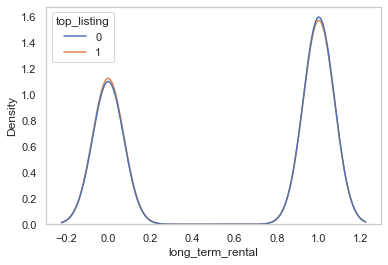

In [450]:
# Review densities
sns.kdeplot(data=listings_active_model, x='long_term_rental',hue ='top_listing');

In [689]:
features = listings_active_model[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room','long_term_rental']]
target = listings_active_model['top_listing']

In [690]:
simple_validation_logreg_knn(features, target)


LogReg_18| Test Accuracy score: 	 0.617
LogReg_18| Test F1 beta score: 	 0.6153

KNN (K=20)_18| Test Accuracy score: 	 0.6364
KNN (K=20)_18| Test F1 beta score: 	 0.6394


In [691]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157
logreg_15  : 0.6151
logreg_16  : 0.6076
logreg_17  : 0.6132
logreg_18  : 0.6153

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437
knn_15  : 0.633
knn_16  : 0.6392
knn_17  : 0.6418
knn_18  : 0.6394


For now, **logistic regression Model 13** and **kNN Model 17** is the model of choice - presenting the best balance between interpretability and F1 beta.

In [445]:
listings_active_model['long_term_rental'].value_counts()

1    15287
0    10739
Name: long_term_rental, dtype: int64

### Model 19 | Model 13 & number of rooms

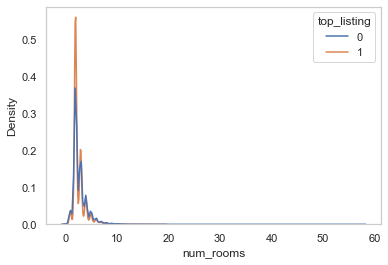

In [451]:
# Review densities
sns.kdeplot(data=listings_active_model, x='num_rooms',hue ='top_listing');

In [692]:
features = listings_active_model[['host_listings','host_about_len','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room','num_rooms']]
target = listings_active_model['top_listing']

In [693]:
simple_validation_logreg_knn(features, target)


LogReg_19| Test Accuracy score: 	 0.6181
LogReg_19| Test F1 beta score: 	 0.6162

KNN (K=20)_19| Test Accuracy score: 	 0.6368
KNN (K=20)_19| Test F1 beta score: 	 0.6416


In [694]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157
logreg_15  : 0.6151
logreg_16  : 0.6076
logreg_17  : 0.6132
logreg_18  : 0.6153
logreg_19  : 0.6162

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437
knn_15  : 0.633
knn_16  : 0.6392
knn_17  : 0.6418
knn_18  : 0.6394
knn_19  : 0.6416


The inclusion of *num_rooms* helps slightly. I will keep this feature in the model going forward.

### Model 20 | Model 19 & content length (1)

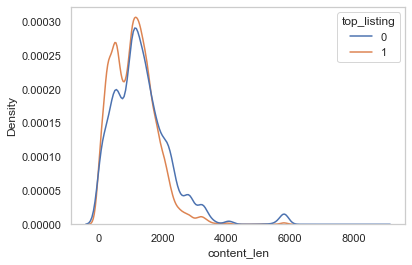

In [455]:
# Review densities
sns.kdeplot(data=listings_active_model, x='content_len',hue ='top_listing');

In [695]:
features = listings_active_model[['host_listings','host_about_len','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room','num_rooms','content_len']]
target = listings_active_model['top_listing']

In [696]:
simple_validation_logreg_knn(features, target)


LogReg_20| Test Accuracy score: 	 0.6162
LogReg_20| Test F1 beta score: 	 0.6141

KNN (K=20)_20| Test Accuracy score: 	 0.6356
KNN (K=20)_20| Test F1 beta score: 	 0.6391


In [697]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157
logreg_15  : 0.6151
logreg_16  : 0.6076
logreg_17  : 0.6132
logreg_18  : 0.6153
logreg_19  : 0.6162
logreg_20  : 0.6141

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437
knn_15  : 0.633
knn_16  : 0.6392
knn_17  : 0.6418
knn_18  : 0.6394
knn_19  : 0.6416
knn_20  : 0.6391


### Model 21 | Model 19 & content length (2)

In [698]:
features = listings_active_model[['host_listings','number_of_reviews','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room','num_rooms','content_len']]
target = listings_active_model['top_listing']

In [699]:
simple_validation_logreg_knn(features, target)


LogReg_21| Test Accuracy score: 	 0.6072
LogReg_21| Test F1 beta score: 	 0.6073

KNN (K=20)_21| Test Accuracy score: 	 0.6368
KNN (K=20)_21| Test F1 beta score: 	 0.6409


In [700]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157
logreg_15  : 0.6151
logreg_16  : 0.6076
logreg_17  : 0.6132
logreg_18  : 0.6153
logreg_19  : 0.6162
logreg_20  : 0.6141
logreg_21  : 0.6073

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437
knn_15  : 0.633
knn_16  : 0.6392
knn_17  : 0.6418
knn_18  : 0.6394
knn_19  : 0.6416
knn_20  : 0.6391
knn_21  : 0.6409


The inclusion of *content_len* does not help the model. Model 19 is still the current winner.

### Model 22 | Model 19 & price per person

In [701]:
features = listings_active_model[['host_listings','host_about_len','number_of_reviews','desc_len','amenities_count','host_since_converted',
                                 'instant_bookable','host_in_US','Brooklyn','Hotel room','num_rooms','price_pp']]
target = listings_active_model['top_listing']

In [702]:
simple_validation_logreg_knn(features, target)


LogReg_22| Test Accuracy score: 	 0.6179
LogReg_22| Test F1 beta score: 	 0.616

KNN (K=20)_22| Test Accuracy score: 	 0.6404
KNN (K=20)_22| Test F1 beta score: 	 0.6438


In [703]:
model_iterations(logreg_models,knn_models)

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157
logreg_15  : 0.6151
logreg_16  : 0.6076
logreg_17  : 0.6132
logreg_18  : 0.6153
logreg_19  : 0.6162
logreg_20  : 0.6141
logreg_21  : 0.6073
logreg_22  : 0.616

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437
knn_15  : 0.633
knn_16  : 0.6392
knn_17  : 0.6418
knn_18  : 0.6394
knn_19  : 0.6416
knn_20  : 0.6391
knn_21  : 0.6409
knn_22  : 0.6438


### Interlude: Outliers

Text(0.5, 0, 'Description Length')

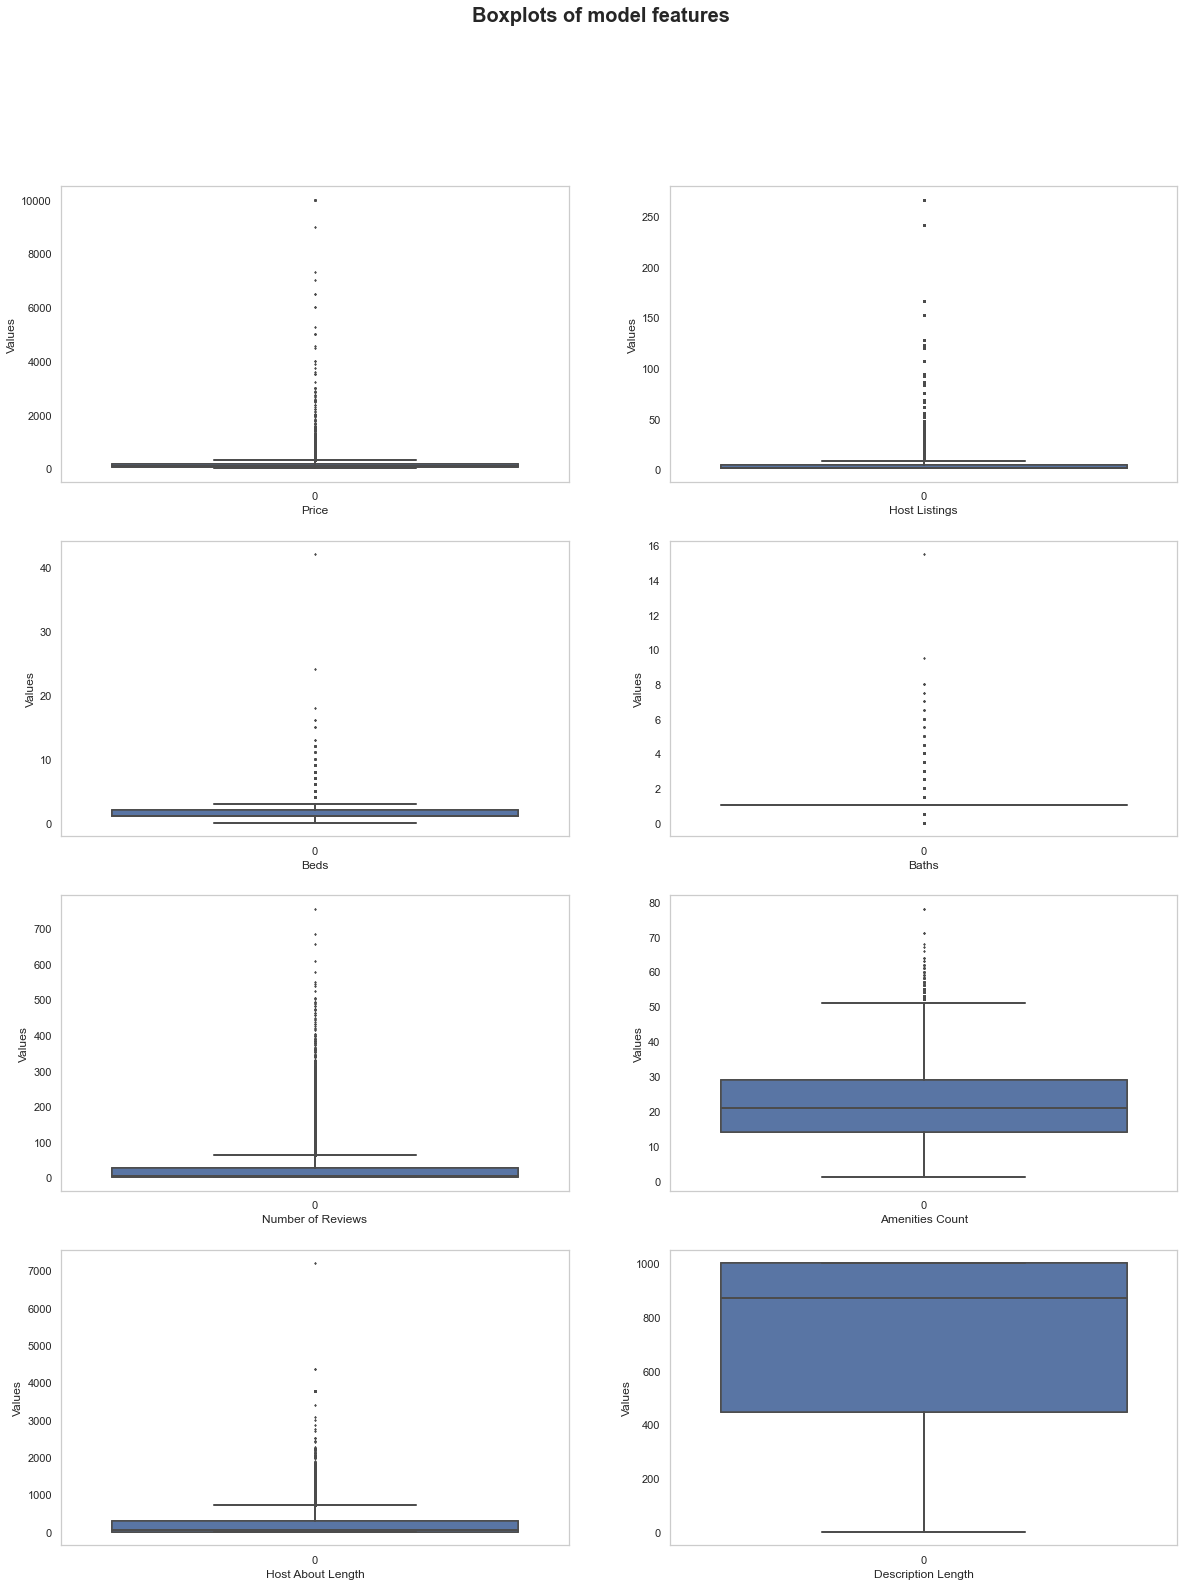

In [490]:
# Investigate outliers with boxplot
fig, axes = plt.subplots(4, 2, figsize=(20, 25))

fig.suptitle('Boxplots of model features',fontsize = 20,fontweight="bold")

sns.boxplot(ax=axes[0, 0], data=listings_active_model['price'], fliersize = 1)
sns.boxplot(ax=axes[0, 0], data=listings_active_model['price'], fliersize = 1).set_ylabel('Values')
sns.boxplot(ax=axes[0, 0], data=listings_active_model['price'], fliersize = 1).set_xlabel('Price')

sns.boxplot(ax=axes[0, 1], data=listings_active_model['host_listings'], fliersize = 1)
sns.boxplot(ax=axes[0, 1], data=listings_active_model['host_listings'], fliersize = 1).set_ylabel('Values')
sns.boxplot(ax=axes[0, 1], data=listings_active_model['host_listings'], fliersize = 1).set_xlabel('Host Listings')

sns.boxplot(ax=axes[1, 0], data=listings_active_model['beds'], fliersize = 1)
sns.boxplot(ax=axes[1, 0], data=listings_active_model['beds'], fliersize = 1).set_ylabel('Values')
sns.boxplot(ax=axes[1, 0], data=listings_active_model['beds'], fliersize = 1).set_xlabel('Beds')

sns.boxplot(ax=axes[1, 1], data=listings_active_model['baths'], fliersize = 1)
sns.boxplot(ax=axes[1, 1], data=listings_active_model['baths'], fliersize = 1).set_ylabel('Values')
sns.boxplot(ax=axes[1, 1], data=listings_active_model['baths'], fliersize = 1).set_xlabel('Baths')

sns.boxplot(ax=axes[2, 0], data=listings_active_model['number_of_reviews'], fliersize = 1)
sns.boxplot(ax=axes[2, 0], data=listings_active_model['number_of_reviews'], fliersize = 1).set_ylabel('Values')
sns.boxplot(ax=axes[2, 0], data=listings_active_model['number_of_reviews'], fliersize = 1).set_xlabel('Number of Reviews')

sns.boxplot(ax=axes[2, 1], data=listings_active_model['amenities_count'], fliersize = 1)
sns.boxplot(ax=axes[2, 1], data=listings_active_model['amenities_count'], fliersize = 1).set_ylabel('Values')
sns.boxplot(ax=axes[2, 1], data=listings_active_model['amenities_count'], fliersize = 1).set_xlabel('Amenities Count')

sns.boxplot(ax=axes[3, 0], data=listings_active_model['host_about_len'], fliersize = 1)
sns.boxplot(ax=axes[3, 0], data=listings_active_model['host_about_len'], fliersize = 1).set_ylabel('Values')
sns.boxplot(ax=axes[3, 0], data=listings_active_model['host_about_len'], fliersize = 1).set_xlabel('Host About Length')

sns.boxplot(ax=axes[3, 1], data=listings_active_model['desc_len'], fliersize = 1)
sns.boxplot(ax=axes[3, 1], data=listings_active_model['desc_len'], fliersize = 1).set_ylabel('Values')
sns.boxplot(ax=axes[3, 1], data=listings_active_model['desc_len'], fliersize = 1).set_xlabel('Description Length')

#### 1. Outliers Treatment | Price

In [491]:
listings_active_model['price'].describe()

count    26026.000000
mean       156.409590
std        314.253781
min         10.000000
25%         60.000000
50%        100.000000
75%        165.000000
max      10000.000000
Name: price, dtype: float64

In [495]:
# Statistical definition of outlier
price_outliers = ((listings_active_model['price'] > np.quantile(listings_active_model['price'], 0.75)) |
                  (listings_active_model['price'] < np.quantile(listings_active_model['price'], 0.25)))
listings_active_model[price_outliers] 

id host_since  host_is_superhost  host_has_profile_pic  \
3          5136 2009-02-03                  0                     1   
8          7097 2009-05-17                  1                     1   
10         7801 2009-06-12                  1                     1   
13         9657 2009-06-16                  1                     1   
14         9704 2009-08-16                  0                     1   
...         ...        ...                ...                   ...   
26016  49081266 2016-01-27                  0                     1   
26019  49086025 2019-10-29                  0                     1   
26020  49087365 2020-09-23                  0                     1   
26021  49088566 2020-02-07                  0                     1   
26025  49092532 2017-10-17                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
3                           0              1             185   
8                           1              2             288   
10                          0              1             299   
13                          1              1             272   
14                          1              1             187   
...                       ...            ...             ...   
26016                       1              1               0   
26019                       1            241             807   
26020                       1             66               0   
26021                       1              3             433   
26025                       1             10             239   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
3                     3   2.0    1.5  ...                0              1   
8                     8   2.0    1.0  ...                0              1   
10                    4   2.0    1.0  ...                0              1   
13                    4   1.0    1.0  ...                1              0   
14                    8   1.0    1.0  ...                0              0   
...                 ...   ...    ...  ...              ...            ...   
26016                 2   3.0    3.0  ...                0              1   
26019                 7   1.0    1.0  ...                0              0   
26020                 1   1.0    1.0  ...                0              1   
26021                 4   1.0    3.0  ...                0              0   
26025                 6   3.0    2.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
3                1        3.5         1225             2009   
8                0        3.0         1648             2009   
10               1        3.0         1592             2009   
13               1        2.0         1798             2009   
14               0        2.0         1222             2009   
...            ...        ...          ...              ...   
26016            0        6.0         1148             2016   
26019            1        2.0         1849             2019   
26020            0        2.0         1185             2020   
26021            0        4.0         1855             2020   
26025            0        5.0         1069             2017   

       host_since_converted  capacity  accommodates    price_pp  
3                    733441      high             4   43.750000  
8                    733544      high             4   49.000000  
10                   733570      high             4   74.750000  
13                   733574    medium             3   58.333333  
14                   733635       low             2   27.500000  
...                     ...       ...           ...         ...  
26016                735990      high             6  200.000000  
26019                737361       low             1   52.000000  
26020                737691      high             3   67.333333  
26021                737462       low            

For the purpose of our model, and considering the domain knowledge about Airbnb and rentals in NYC, I will adopt a definition of outlier for price:<br/>
- any listing with a price > USD 1000
- any listing with a price < USD 25

In [505]:
# Alternative definition of outliers
price_outliers_alternative = ((listings_active_model['price'] > 1000) | (listings_active_model['price'] < 25))
listings_active_model[price_outliers_alternative]

id host_since  host_is_superhost  host_has_profile_pic  \
277      174966 2011-07-18                  0                     1   
380      256049 2011-09-18                  1                     1   
562      468613 2012-05-08                  0                     1   
724      664047 2011-07-18                  0                     1   
933      893413 2013-01-18                  1                     1   
...         ...        ...                ...                   ...   
25960  49052902 2021-02-28                  0                     1   
25961  49053064 2021-02-28                  0                     1   
25964  49053647 2021-02-28                  0                     1   
26012  49079517 2013-08-30                  0                     1   
26016  49081266 2016-01-27                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
277                         1             10             688   
380                         1             10            1008   
562                         1              1               0   
724                         1             10             688   
933                         1              1             200   
...                       ...            ...             ...   
25960                       1             28               0   
25961                       1             28               0   
25964                       1             28               0   
26012                       1              2             592   
26016                       1              1               0   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
277                   7   3.0    2.5  ...                0              1   
380                   8   7.0    5.0  ...                0              1   
562                   5   1.0    1.0  ...                0              0   
724                   7   3.0    2.5  ...                0              1   
933                   5   4.0    2.5  ...                0              1   
...                 ...   ...    ...  ...              ...            ...   
25960                 2   1.0    1.0  ...                0              0   
25961                 2   1.0    1.5  ...                1              0   
25964                 2   1.0    1.0  ...                0              0   
26012                 6   0.0    1.0  ...                0              0   
26016                 2   3.0    3.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
277              0        5.5         1725             2011   
380              0       12.0         2315             2011   
562              1        2.0          588             2012   
724              0        5.5         1723             2011   
933              1        6.5         2242             2013   
...            ...        ...          ...              ...   
25960            1        2.0          725             2021   
25961            1        2.5          958             2021   
25964            1        2.0         1325             2021   
26012            1        1.0         1662             2013   
26016            0        6.0         1148             2016   

       host_since_converted  capacity  accommodates     price_pp  
277                  734336      high             9   277.777778  
380                  734398      high            13   346.153846  
562                  734631       low             1  1300.000000  
724                  734336      high             8   312.500000  
933                  734886      high            10   253.600000  
...                     ...       ...           ...          ...  
25960                737849       low             1    21.000000  
25961                737849    medium             2    11.500000  
25964                737849       low             1    21.000000  
26012                735110       low  

In [506]:
# Drop outliers
listings_active_model_1 = listings_active_model[~price_outliers_alternative] 

In [508]:
listings_active_model.shape

(26026, 37)

In [507]:
listings_active_model_1.shape

(25588, 37)

#### 2. Outliers Treatment | Host Listings

In [487]:
listings_active_model['host_listings'].describe()

count    26026.000000
mean        14.812649
std         42.837424
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        266.000000
Name: host_listings, dtype: float64

In [552]:
# Statistical definition of outlier
host_listings_outliers = ((listings_active_model_1['host_listings'] > np.quantile(listings_active_model_1['host_listings'], 0.75)) |
                          (listings_active_model_1['host_listings'] < np.quantile(listings_active_model_1['host_listings'], 0.25)))
listings_active_model_1[host_listings_outliers] 

id host_since  host_is_superhost  host_has_profile_pic  \
22        13121 2009-07-27                  0                     1   
50        20717 2010-02-06                  1                     1   
103       47613 2010-08-29                  1                     1   
107       51850 2009-07-27                  0                     1   
112       54544 2010-10-07                  0                     1   
...         ...        ...                ...                   ...   
26004  49074929 2020-06-03                  0                     1   
26007  49077715 2017-12-11                  0                     1   
26017  49081276 2018-07-22                  1                     1   
26020  49087365 2020-09-23                  0                     1   
26025  49092532 2017-10-17                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
22                          1              5             244   
50                          0              4             156   
103                         1              5              84   
107                         1              5             244   
112                         1              5             263   
...                       ...            ...             ...   
26004                       1             48             238   
26007                       1             41               0   
26017                       1             10             248   
26020                       1             66               0   
26025                       1             10             239   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
22                    4   2.0    1.0  ...                0              1   
50                    5   1.0    1.5  ...                0              0   
103                   7   1.0    1.0  ...                0              0   
107                   4   1.0    1.0  ...                0              0   
112                   6   4.0    1.0  ...                0              1   
...                 ...   ...    ...  ...              ...            ...   
26004                 6   2.0    1.0  ...                0              1   
26007                 6   1.0    1.0  ...                1              0   
26017                 6   2.0    1.0  ...                0              1   
26020                 1   1.0    1.0  ...                0              1   
26025                 6   3.0    2.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
22               1        3.0         1263             2009   
50               0        2.5         2091             2010   
103              0        2.0         1371             2010   
107              0        2.0         1265             2009   
112              0        5.0         1719             2010   
...            ...        ...          ...              ...   
26004            1        3.0         1282             2020   
26007            0        2.0          754             2017   
26017            1        3.0         1296             2018   
26020            0        2.0         1185             2020   
26025            0        5.0         1069             2017   

       host_since_converted  capacity  accommodates   price_pp  
22                   733615      high             4  18.750000  
50                   733809       low             2  42.500000  
103                  734013       low             1  81.000000  
107                  733615       low             2  32.500000  
112                  734052      high             5  32.200000  
...                     ...       ...           ...        ...  
26004                737579      high             4  31.250000  
26007                736674    medium             2  65.000000  
26017                736897      high             3  33.000000  
26020                737691      high             3  67.333

For the purpose of this model, a listing is considered as a outlier if *host_listings* > 100.

In [512]:
# Alternative definition of outliers
host_listings_outliers_alternative = (listings_active_model_1['host_listings'] > 100)
listings_active_model_1[host_listings_outliers_alternative]

id host_since  host_is_superhost  host_has_profile_pic  \
4291    8627973 2014-08-01                  0                     1   
5021   10031902 2015-12-16                  0                     1   
5024   10033868 2015-12-16                  0                     1   
5026   10034817 2015-12-16                  0                     1   
5140   10243039 2015-12-16                  0                     1   
...         ...        ...                ...                   ...   
25993  49068872 2019-10-29                  0                     1   
26000  49073200 2019-10-29                  0                     1   
26019  49086025 2019-10-29                  0                     1   
26022  49089512 2019-10-29                  0                     1   
26024  49091581 2019-10-29                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
4291                        1            120               0   
5021                        1            152               0   
5024                        1            152               0   
5026                        1            152               0   
5140                        1            152               0   
...                       ...            ...             ...   
25993                       1            241             807   
26000                       1            241             807   
26019                       1            241             807   
26022                       1            241             807   
26024                       1            241             807   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
4291                  7   1.0    1.0  ...                0              0   
5021                  5   1.0    1.0  ...                1              0   
5024                  5   2.0    1.0  ...                0              1   
5026                  5   1.0    1.0  ...                0              1   
5140                  5   1.0    1.0  ...                1              0   
...                 ...   ...    ...  ...              ...            ...   
25993                 7   1.0    1.0  ...                0              0   
26000                 7   1.0    1.0  ...                0              0   
26019                 7   1.0    1.0  ...                0              0   
26022                 7   0.0    1.0  ...                1              0   
26024                 7   1.0    1.0  ...                0              0   

       top_listing  num_rooms  content_len  host_since_year  \
4291             1        2.0         1047             2014   
5021             0        2.0         1029             2015   
5024             0        3.0          913             2015   
5026             0        2.0          914             2015   
5140             0        2.0          602             2015   
...            ...        ...          ...              ...   
25993            0        2.0         1847             2019   
26000            0        2.0         1842             2019   
26019            1        2.0         1849             2019   
26022            0        1.0         1851             2019   
26024            0        2.0         1851             2019   

       host_since_converted  capacity  accommodates    price_pp  
4291                 735446       low             2   20.000000  
5021                 735948    medium             3   23.333333  
5024                 735948      high             5   17.400000  
5026                 735948      high             4   20.000000  
5140                 735948    medium             3   22.666667  
...                     ...       ...           ...         ...  
25993                737361       low             1  106.000000  
26000                737361       low             1   52.000000  
26019                737361       low             1   52.000000  
26022                737361    medium            

In [513]:
listings_active_model_1.shape

(25588, 37)

In [514]:
# Drop outliers
listings_active_model_1 = listings_active_model_1[~host_listings_outliers_alternative] 

In [515]:
listings_active_model_1.shape

(24370, 37)

#### 3. Outliers Treatment | Beds

In [517]:
listings_active_model_1['beds'].describe()

count    24370.000000
mean         1.599261
std          1.183455
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         24.000000
Name: beds, dtype: float64

In [553]:
# Statistical definition of outlier
beds_outliers = ((listings_active_model_1['beds'] > np.quantile(listings_active_model_1['beds'], 0.75)) |
                (listings_active_model_1['beds'] < np.quantile(listings_active_model_1['beds'], 0.25)))
listings_active_model_1[beds_outliers] 

id host_since  host_is_superhost  host_has_profile_pic  \
11         8490 2009-07-10                  1                     1   
31        15711 2009-12-09                  0                     1   
32        16326 2009-12-16                  1                     1   
57        23686 2010-03-15                  1                     1   
59        26012 2010-04-16                  0                     1   
...         ...        ...                ...                   ...   
25996  49070478 2020-11-17                  0                     1   
25997  49071611 2015-09-13                  1                     1   
25999  49072922 2018-03-07                  0                     1   
26009  49078228 2020-08-19                  0                     1   
26025  49092532 2017-10-17                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
11                          1              2             325   
31                          1              2               3   
32                          1              1             259   
57                          1              2             156   
59                          1              1             561   
...                       ...            ...             ...   
25996                       1             28               0   
25997                       0              2             405   
25999                       1              9               0   
26009                       0              1              66   
26025                       1             10             239   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
11                    5   4.0    1.0  ...                0              1   
31                    8   4.0    1.0  ...                0              1   
32                    5   4.0    2.0  ...                0              1   
57                    8   3.0    2.0  ...                0              1   
59                    4   3.0    2.0  ...                0              1   
...                 ...   ...    ...  ...              ...            ...   
25996                 7   4.0    2.0  ...                0              1   
25997                 4   3.0    1.0  ...                0              1   
25999                 7   3.0    1.0  ...                0              1   
26009                 1   3.0    1.0  ...                0              1   
26025                 6   3.0    2.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
11               0        5.0         1373             2009   
31               0        5.0         2028             2009   
32               0        6.0         1812             2009   
57               0        5.0         2205             2010   
59               0        5.0         1997             2010   
...            ...        ...          ...              ...   
25996            0        6.0           36             2020   
25997            0        4.0         1229             2015   
25999            0        4.0         1024             2018   
26009            0        4.0          103             2020   
26025            0        5.0         1069             2017   

       host_since_converted  capacity  accommodates    price_pp  
11                   733598      high             5   24.000000  
31                   733750      high             6   34.333333  
32                   733757      high             8   17.500000  
57                   733846      high             4  124.750000  
59                   733878      high             6   33.333333  
...                     ...       ...           ...         ...  
25996                737746      high             4   25.000000  
25997                735854      high             3   39.666667  
25999                736760      high             6   16.500000  
26009                737656      high            

For the purpose of this model, a listing is considered as a outlier if:
- beds is equal to 0
- beds is greater than 6

In [525]:
# Alternative definition of outliers
beds_outliers_alternative = ((listings_active_model_1['beds'] == 0) |
                             (listings_active_model_1['beds'] > 6))
listings_active_model_1[beds_outliers_alternative]

id host_since  host_is_superhost  host_has_profile_pic  \
5          5803 2009-03-10                  1                     1   
16        10962 2009-03-10                  1                     1   
25        14290 2009-11-20                  0                     1   
43        18198 2010-01-12                  0                     1   
51        20724 2011-08-12                  0                     1   
...         ...        ...                ...                   ...   
25955  49046672 2020-06-03                  0                     1   
25976  49057960 2012-10-01                  0                     1   
25992  49065181 2016-07-02                  0                     1   
26008  49077862 2021-04-06                  0                     1   
26013  49079603 2019-07-21                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
5                           1              3             606   
16                          1              3             606   
25                          1              1             842   
43                          0              2             443   
51                          1              1              42   
...                       ...            ...             ...   
25955                       1             48             238   
25976                       1              1             358   
25992                       1              3             240   
26008                       1              1               0   
26013                       1              2              27   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
5                     7   0.0    1.5  ...                0              0   
16                    7   0.0    1.0  ...                0              0   
25                    8   0.0    1.0  ...                0              0   
43                    4   0.0    1.0  ...                0              0   
51                    6   0.0    1.5  ...                0              0   
...                 ...   ...    ...  ...              ...            ...   
25955                 6   7.0    4.0  ...                0              1   
25976                 3   0.0    2.0  ...                0              1   
25992                 7   0.0    1.5  ...                1              0   
26008                 1   0.0    1.0  ...                1              0   
26013                 6   0.0    1.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
5                0        1.5         2143             2009   
16               0        1.0         1820             2009   
25               1        1.0         2130             2009   
43               1        1.0         1767             2010   
51               0        1.5         1077             2011   
...            ...        ...          ...              ...   
25955            1       11.0         1225             2020   
25976            0        2.0         1257             2012   
25992            1        1.5          289             2016   
26008            0        1.0          444             2021   
26013            0        1.0          126             2019   

       host_since_converted  capacity  accommodates  price_pp  
5                    733476       low             2   46.0000  
16                   733476       low             2   46.0000  
25                   733731       low             2   99.0000  
43                   733784       low             1   55.0000  
51                   734361       low             2   25.0000  
...                     ...       ...           ...       ...  
25955                737579      high            16   34.3125  
25976                734777      high             4   37.5000  
25992                736147    medium             2   25.0000  
26008                737886    medium             2   25.0000  
26013

In [526]:
listings_active_model_1.shape

(24370, 37)

In [527]:
# Drop outliers
listings_active_model_1 = listings_active_model_1[~beds_outliers_alternative] 

In [528]:
listings_active_model_1.shape

(23135, 37)

#### 4. Outlier Treatment | Baths

In [529]:
listings_active_model_1['baths'].describe()

count    23135.000000
mean         1.163086
std          0.454209
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.500000
Name: baths, dtype: float64

In [554]:
# Statistical definition of outlier
baths_outliers = ((listings_active_model_1['baths'] > np.quantile(listings_active_model_1['baths'], 0.75)) |
                (listings_active_model_1['baths'] < np.quantile(listings_active_model_1['baths'], 0.25)))
listings_active_model_1[baths_outliers] 

id host_since  host_is_superhost  host_has_profile_pic  \
3          5136 2009-02-03                  0                     1   
30        15396 2009-12-05                  0                     1   
32        16326 2009-12-16                  1                     1   
44        18728 2010-01-20                  1                     1   
47        19282 2010-01-25                  0                     1   
...         ...        ...                ...                   ...   
26001  49073830 2021-04-06                  0                     1   
26002  49074308 2015-04-03                  0                     1   
26015  49080659 2013-05-03                  1                     1   
26021  49088566 2020-02-07                  0                     1   
26025  49092532 2017-10-17                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
3                           0              1             185   
30                          1              1               0   
32                          1              1             259   
44                          1              1              70   
47                          1              1             337   
...                       ...            ...             ...   
26001                       0              1               0   
26002                       1             17             243   
26015                       1              1              78   
26021                       1              3             433   
26025                       1             10             239   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
3                     3   2.0    1.5  ...                0              1   
30                    4   2.0    2.0  ...                0              1   
32                    5   4.0    2.0  ...                0              1   
44                    6   1.0    1.5  ...                1              0   
47                    5   2.0    2.0  ...                0              1   
...                 ...   ...    ...  ...              ...            ...   
26001                 2   2.0    1.5  ...                0              1   
26002                 9   1.0    2.0  ...                0              0   
26015                 5   2.0    2.0  ...                1              0   
26021                 4   1.0    3.0  ...                0              0   
26025                 6   3.0    2.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
3                1        3.5         1225             2009   
30               1        4.0          591             2009   
32               0        6.0         1812             2009   
44               0        2.5         1249             2010   
47               1        4.0         1368             2010   
...            ...        ...          ...              ...   
26001            0        3.5          518             2021   
26002            0        3.0         1072             2015   
26015            0        4.0         1363             2013   
26021            0        4.0         1855             2020   
26025            0        5.0         1069             2017   

       host_since_converted  capacity  accommodates   price_pp  
3                    733441      high             4  43.750000  
30                   733746      high             4  93.750000  
32                   733757      high             8  17.500000  
44                   733792    medium             3  50.000000  
47                   733797      high             4  27.500000  
...                     ...       ...           ...        ...  
26001                737886      high             4  62.500000  
26002                735691       low             1  33.000000  
26015                734991    medium             2  60.000000  
26021                737462       low             1  46.000

For the purpose of this model, a listing is considered as a outlier if:
- beds is equal to 0
- beds is greater than 3

In [534]:
# Alternative definition of outliers
baths_outliers_alternative = ((listings_active_model_1['baths'] == 0) |
                             (listings_active_model_1['baths'] > 3))
listings_active_model_1[baths_outliers_alternative]

id host_since  host_is_superhost  host_has_profile_pic  \
413      274995 2011-11-23                  0                     1   
421      281851 2011-12-04                  0                     1   
693      639199 2011-12-07                  1                     1   
745      690934 2011-05-09                  1                     1   
1087    1126944 2010-05-20                  0                     1   
...         ...        ...                ...                   ...   
25690  48880854 2020-11-10                  0                     1   
25692  48881991 2020-11-10                  0                     1   
25702  48889377 2019-02-04                  0                     1   
25704  48891684 2021-03-21                  0                     1   
25790  48954351 2016-10-10                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
413                         1              1             230   
421                         1              1            1429   
693                         1              1             286   
745                         1              1              46   
1087                        1              1             142   
...                       ...            ...             ...   
25690                       1             61               0   
25692                       1             61               0   
25702                       0              3               0   
25704                       1              2               0   
25790                       1             54             810   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
413                   5   1.0    0.0  ...                0              0   
421                   5   3.0    0.0  ...                0              0   
693                   6   6.0    4.5  ...                0              1   
745                   4   6.0    3.5  ...                0              1   
1087                  5   6.0    3.5  ...                0              1   
...                 ...   ...    ...  ...              ...            ...   
25690                 6   1.0    0.0  ...                0              0   
25692                 6   1.0    0.0  ...                0              0   
25702                 1   1.0    0.0  ...                0              0   
25704                 1   5.0    5.0  ...                0              1   
25790                 2   2.0    0.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
413              0        1.0         1262             2011   
421              0        3.0         2646             2011   
693              0       10.5         1453             2011   
745              0        9.5         1641             2011   
1087             1        9.5         1177             2010   
...            ...        ...          ...              ...   
25690            0        1.0         1060             2020   
25692            1        1.0         1060             2020   
25702            0        1.0           46             2019   
25704            0       10.0         1845             2021   
25790            1        2.0         1844             2016   

       host_since_converted  capacity  accommodates   price_pp  
413                  734464       low             2  52.500000  
421                  734475       low             2  65.000000  
693                  734478      high            11  29.909091  
745                  734266      high            14  35.714286  
1087                 733912      high             8  62.500000  
...                     ...       ...           ...        ...  
25690                737739       low             1  83.000000  
25692                737739       low             1  83.000000  
25702                737094       low             1  36.000000  
25704                737870      high            14  63.500

In [535]:
listings_active_model_1.shape

(23135, 37)

In [536]:
# Drop outliers
listings_active_model_1 = listings_active_model_1[~baths_outliers_alternative] 

In [537]:
listings_active_model_1.shape

(22844, 37)

#### 5. Outlier Treatment | Number of Reviews

In [538]:
listings_active_model_1['number_of_reviews'].describe()

count    22844.000000
mean        27.905008
std         54.918134
min          0.000000
25%          0.000000
50%          4.000000
75%         29.000000
max        755.000000
Name: number_of_reviews, dtype: float64

In [555]:
# Statistical definition of outlier
reviews_outliers = ((listings_active_model_1['number_of_reviews'] > np.quantile(listings_active_model_1['number_of_reviews'], 0.75)) |
                (listings_active_model_1['number_of_reviews'] < np.quantile(listings_active_model_1['number_of_reviews'], 0.25)))
listings_active_model_1[reviews_outliers] 

id host_since  host_is_superhost  host_has_profile_pic  \
0          2595 2008-09-09                  0                     1   
2          5121 2009-02-03                  0                     1   
11         8490 2009-07-10                  1                     1   
12         9357 2009-08-06                  0                     1   
13         9657 2009-06-16                  1                     1   
...         ...        ...                ...                   ...   
23429  47071980 2020-12-04                  1                     1   
23463  47100085 2017-06-03                  1                     1   
23659  47310714 2015-05-25                  1                     1   
23780  47372712 2018-07-22                  1                     1   
24310  47922935 2017-06-03                  1                     1   

       host_identity_verified  host_listings  host_about_len  \
0                           1              3             427   
2                           1              1             373   
11                          1              2             325   
12                          1              1             258   
13                          1              1             272   
...                       ...            ...             ...   
23429                       0              1               0   
23463                       1              3               0   
23659                       1              2            1581   
23780                       1              1              71   
24310                       1              3               0   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
0                     9   1.0    1.0  ...                0              0   
2                     8   1.0    1.0  ...                0              0   
11                    5   4.0    1.0  ...                0              1   
12                    4   1.0    1.0  ...                0              0   
13                    4   1.0    1.0  ...                1              0   
...                 ...   ...    ...  ...              ...            ...   
23429                 2   1.0    1.0  ...                1              0   
23463                10   1.0    1.0  ...                1              0   
23659                 6   1.0    1.0  ...                1              0   
23780                 5   1.0    1.0  ...                1              0   
24310                10   1.0    1.0  ...                1              0   

       top_listing  num_rooms  content_len  host_since_year  \
0                0        2.0         1665             2008   
2                0        2.0         1388             2009   
11               0        5.0         1373             2009   
12               1        2.0         1439             2009   
13               1        2.0         1798             2009   
...            ...        ...          ...              ...   
23429            0        2.0         1414             2020   
23463            0        2.0         1454             2017   
23659            0        2.0         2789             2015   
23780            0        2.0          702             2018   
24310            0        2.0         1455             2017   

       host_since_converted  capacity  accommodates   price_pp  
0                    733294       low             2  75.000000  
2                    733441       low             2  30.000000  
11                   733598      high             5  24.000000  
12                   733625       low             2  75.000000  
13                   733574    medium             3  58.333333  
...                     ...       ...           ...        ...  
23429                737763    medium             2  26.000000  
23463                736483    medium             2  35.000000  
23659                735743    medium             2  29.500000  
23780                736897    medium             2  38.000

For the purpose of this model, a listing is considered as a outlier if *num_of_reviews* is greater than 200.

In [546]:
# Alternative definition of outliers
reviews_outliers_alternative = (listings_active_model_1['number_of_reviews'] > 200)
listings_active_model_1[reviews_outliers_alternative]

id host_since  host_is_superhost  host_has_profile_pic  \
1          3831 2008-12-07                  0                     1   
4          5178 2009-03-03                  0                     1   
7          6990 2009-05-12                  0                     1   
8          7097 2009-05-17                  1                     1   
18        12192 2009-10-19                  0                     1   
...         ...        ...                ...                   ...   
14938  36108965 2019-06-06                  0                     1   
15033  36318290 2017-02-15                  1                     1   
15338  37122162 2019-06-06                  0                     1   
15341  37122502 2019-06-06                  0                     1   
20783  44799007 2018-10-08                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
1                           1              1             220   
4                           0              1             106   
7                           1              1             158   
8                           1              2             288   
18                          0              2             233   
...                       ...            ...             ...   
14938                       1              5             586   
15033                       1              1             247   
15338                       1              4             776   
15341                       1              4             776   
20783                       1             43             429   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
1                     6   3.0    1.0  ...                1              0   
4                     4   1.0    1.0  ...                0              0   
7                     5   1.0    1.0  ...                0              0   
8                     8   2.0    1.0  ...                0              1   
18                    4   1.0    1.0  ...                0              0   
...                 ...   ...    ...  ...              ...            ...   
14938                 2   1.0    1.0  ...                1              0   
15033                 7   1.0    1.0  ...                1              0   
15338                 3   1.0    1.0  ...                1              0   
15341                 3   1.0    1.0  ...                1              0   
20783                 4   1.0    1.0  ...                1              0   

       top_listing  num_rooms  content_len  host_since_year  \
1                0        4.0         1528             2008   
4                0        2.0         1185             2009   
7                0        2.0         1968             2009   
8                0        3.0         1648             2009   
18               0        2.0         1504             2009   
...            ...        ...          ...              ...   
14938            0        2.0         1917             2019   
15033            0        2.0         1307             2017   
15338            0        2.0         2231             2019   
15341            1        2.0         2240             2019   
20783            0        2.0         2150             2018   

       host_since_converted  capacity  accommodates   price_pp  
1                    733383    medium             3  25.333333  
4                    733469       low             2  39.500000  
7                    733539       low             1  62.000000  
8                    733544      high             4  49.000000  
18                   733699       low             2  20.000000  
...                     ...       ...           ...        ...  
14938                737216    medium             2  60.500000  
15033                736375    medium             2  45.000000  
15338                737216    medium             2  48.000000  
15341                737216    medium             2  48.500

In [547]:
listings_active_model_1.shape

(22844, 37)

In [548]:
# Drop outliers
listings_active_model_1 = listings_active_model_1[~reviews_outliers_alternative] 

In [549]:
listings_active_model_1.shape

(22314, 37)

#### 6. Outlier Treatment | Amenities Count

In [550]:
listings_active_model_1['amenities_count'].describe()

count    22314.000000
mean        22.249171
std          9.977280
min          1.000000
25%         14.000000
50%         21.000000
75%         29.000000
max         78.000000
Name: amenities_count, dtype: float64

In [556]:
# Statistical definition of outlier
amenities_outliers = ((listings_active_model_1['amenities_count'] > np.quantile(listings_active_model_1['amenities_count'], 0.75)) |
                (listings_active_model_1['amenities_count'] < np.quantile(listings_active_model_1['amenities_count'], 0.25)))
listings_active_model_1[amenities_outliers] 

id host_since  host_is_superhost  host_has_profile_pic  \
0          2595 2008-09-09                  0                     1   
2          5121 2009-02-03                  0                     1   
3          5136 2009-02-03                  0                     1   
9          7750 2009-05-20                  0                     1   
10         7801 2009-06-12                  1                     1   
...         ...        ...                ...                   ...   
26009  49078228 2020-08-19                  0                     1   
26011  49079019 2013-08-29                  0                     1   
26014  49079940 2019-02-13                  0                     1   
26017  49081276 2018-07-22                  1                     1   
26020  49087365 2020-09-23                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
0                           1              3             427   
2                           1              1             373   
3                           0              1             185   
9                           1              2              47   
10                          0              1             299   
...                       ...            ...             ...   
26009                       0              1              66   
26011                       1              1              34   
26014                       0              1              19   
26017                       1             10             248   
26020                       1             66               0   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
0                     9   1.0    1.0  ...                0              0   
2                     8   1.0    1.0  ...                0              0   
3                     3   2.0    1.5  ...                0              1   
9                     6   2.0    1.0  ...                0              0   
10                    4   2.0    1.0  ...                0              1   
...                 ...   ...    ...  ...              ...            ...   
26009                 1   3.0    1.0  ...                0              1   
26011                 4   1.0    1.0  ...                0              1   
26014                 2   1.0    1.0  ...                1              0   
26017                 6   2.0    1.0  ...                0              1   
26020                 1   1.0    1.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
0                0        2.0         1665             2008   
2                0        2.0         1388             2009   
3                1        3.5         1225             2009   
9                0        3.0         1088             2009   
10               1        3.0         1592             2009   
...            ...        ...          ...              ...   
26009            0        4.0          103             2020   
26011            1        2.0          499             2013   
26014            0        2.0         1241             2019   
26017            1        3.0         1296             2018   
26020            0        2.0         1185             2020   

       host_since_converted  capacity  accommodates   price_pp  
0                    733294       low             2  75.000000  
2                    733441       low             2  30.000000  
3                    733441      high             4  43.750000  
9                    733547       low             1  96.000000  
10                   733570      high             4  74.750000  
...                     ...       ...           ...        ...  
26009                737656      high             6  20.000000  
26011                735109      high             4  55.000000  
26014                737103    medium             2  21.000000  
26017                736897      high             3  33.000

For the purpose of this model, a listing is considered as a outlier if *amenities_count* is greater than 40.

In [560]:
# Alternative definition of outliers
amenities_outliers_alternative = (listings_active_model_1['amenities_count'] > 40)
listings_active_model_1[amenities_outliers_alternative]

id host_since  host_is_superhost  host_has_profile_pic  \
31        15711 2009-12-09                  0                     1   
35        16595 2009-12-20                  0                     1   
57        23686 2010-03-15                  1                     1   
105       50447 2009-03-10                  1                     1   
119       57754 2010-10-31                  1                     1   
...         ...        ...                ...                   ...   
25854  48985558 2017-09-08                  0                     1   
25881  49002584 2017-12-09                  0                     1   
25926  49026617 2021-03-02                  0                     1   
25950  49043196 2017-02-02                  0                     1   
25997  49071611 2015-09-13                  1                     1   

       host_identity_verified  host_listings  host_about_len  \
31                          1              2               3   
35                          1              1               0   
57                          1              2             156   
105                         1              3             606   
119                         1              1             153   
...                       ...            ...             ...   
25854                       1             10             548   
25881                       1              2               0   
25926                       0              1               0   
25950                       1              3              46   
25997                       0              2             405   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
31                    8   4.0    1.0  ...                0              1   
35                    7   1.0    1.0  ...                0              0   
57                    8   3.0    2.0  ...                0              1   
105                   7   2.0    1.0  ...                0              1   
119                   4   1.0    1.0  ...                0              0   
...                 ...   ...    ...  ...              ...            ...   
25854                 2   2.0    2.0  ...                0              0   
25881                 3   3.0    2.0  ...                0              1   
25926                 2   1.0    1.5  ...                1              0   
25950                 7   3.0    2.0  ...                0              1   
25997                 4   3.0    1.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
31               0        5.0         2028             2009   
35               0        2.0         1230             2009   
57               0        5.0         2205             2010   
105              0        3.0         1709             2009   
119              0        2.0         1915             2010   
...            ...        ...          ...              ...   
25854            0        4.0         2235             2017   
25881            0        5.0          490             2017   
25926            0        2.5         1211             2021   
25950            0        5.0         2044             2017   
25997            0        4.0         1229             2015   

       host_since_converted  capacity  accommodates    price_pp  
31                   733750      high             6   34.333333  
35                   733761       low             2  157.000000  
57                   733846      high             4  124.750000  
105                  733476      high             4   29.750000  
119                  734076       low             2  137.500000  
...                     ...       ...           ...         ...  
25854                736580       low             1   33.000000  
25881                736672      high             5   27.000000  
25926                737851    medium             2   49.000000  
25950                736362      high            

In [561]:
listings_active_model_1.shape

(22314, 37)

In [562]:
# Drop outliers
listings_active_model_1 = listings_active_model_1[~amenities_outliers_alternative] 

In [563]:
listings_active_model_1.shape

(21357, 37)

#### 7. Outliers Treatment | Host About Length

In [564]:
listings_active_model_1['host_about_len'].describe()

count    21357.000000
mean       184.963338
std        314.165593
min          0.000000
25%          0.000000
50%         50.000000
75%        249.000000
max       7186.000000
Name: host_about_len, dtype: float64

In [565]:
# Statistical definition of outlier
host_about_outliers = ((listings_active_model_1['host_about_len'] > np.quantile(listings_active_model_1['host_about_len'], 0.75)) |
                (listings_active_model_1['host_about_len'] < np.quantile(listings_active_model_1['host_about_len'], 0.25)))
listings_active_model_1[host_about_outliers] 

id host_since  host_is_superhost  host_has_profile_pic  \
0          2595 2008-09-09                  0                     1   
2          5121 2009-02-03                  0                     1   
10         7801 2009-06-12                  1                     1   
11         8490 2009-07-10                  1                     1   
12         9357 2009-08-06                  0                     1   
...         ...        ...                ...                   ...   
25984  49059730 2008-09-09                  0                     1   
25990  49062779 2014-08-06                  0                     1   
25998  49072662 2015-09-07                  1                     1   
26006  49077488 2014-08-12                  0                     1   
26021  49088566 2020-02-07                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
0                           1              3             427   
2                           1              1             373   
10                          0              1             299   
11                          1              2             325   
12                          1              1             258   
...                       ...            ...             ...   
25984                       1              3             427   
25990                       1              3             516   
25998                       1              1             658   
26006                       1              2             515   
26021                       1              3             433   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
0                     9   1.0    1.0  ...                0              0   
2                     8   1.0    1.0  ...                0              0   
10                    4   2.0    1.0  ...                0              1   
11                    5   4.0    1.0  ...                0              1   
12                    4   1.0    1.0  ...                0              0   
...                 ...   ...    ...  ...              ...            ...   
25984                 9   1.0    1.0  ...                1              0   
25990                10   2.0    1.0  ...                0              1   
25998                 7   1.0    1.0  ...                1              0   
26006                 5   2.0    1.0  ...                0              1   
26021                 4   1.0    3.0  ...                0              0   

       top_listing  num_rooms  content_len  host_since_year  \
0                0        2.0         1665             2008   
2                0        2.0         1388             2009   
10               1        3.0         1592             2009   
11               0        5.0         1373             2009   
12               1        2.0         1439             2009   
...            ...        ...          ...              ...   
25984            0        2.0          622             2008   
25990            0        3.0         1064             2014   
25998            1        2.0         1204             2015   
26006            0        3.0         1562             2014   
26021            0        4.0         1855             2020   

       host_since_converted  capacity  accommodates  price_pp  
0                    733294       low             2     75.00  
2                    733441       low             2     30.00  
10                   733570      high             4     74.75  
11                   733598      high             5     24.00  
12                   733625       low             2     75.00  
...                     ...       ...           ...       ...  
25984                733294    medium             2     75.00  
25990                735451      high             4     48.50  
25998                735848    medium             2     20.00  
26006                735457      high             4    140.00  
26021

For the purpose of this model, a listing is considered as a outlier if *host_about* is greater than 1000.

In [567]:
# Alternative definition of outliers
host_about_outliers_alternative = (listings_active_model_1['host_about_len'] > 1000)
listings_active_model_1[host_about_outliers_alternative]

id host_since  host_is_superhost  host_has_profile_pic  \
73        31902 2010-06-02                  0                     1   
76        32037 2010-05-01                  0                     1   
93        42882 2010-07-30                  1                     1   
123       59014 2010-11-10                  0                     1   
127       60611 2010-11-19                  1                     1   
...         ...        ...                ...                   ...   
24964  48342641 2012-07-08                  0                     1   
25151  48485961 2012-07-08                  0                     1   
25402  48672660 2012-07-08                  0                     1   
25503  48767648 2014-11-15                  0                     1   
25859  48991170 2012-07-08                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
73                          1              1            2207   
76                          1              3            1852   
93                          1              1            1018   
123                         1              1            1305   
127                         1              4            1597   
...                       ...            ...             ...   
24964                       1             28            1114   
25151                       1             28            1114   
25402                       1             28            1114   
25503                       1             44            1247   
25859                       1             28            1114   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
73                    6   1.0    1.0  ...                0              0   
76                    4   2.0    1.5  ...                1              0   
93                    8   1.0    1.0  ...                0              0   
123                   4   1.0    1.0  ...                0              0   
127                   4   1.0    1.0  ...                0              0   
...                 ...   ...    ...  ...              ...            ...   
24964                 7   2.0    1.0  ...                0              1   
25151                 7   2.0    1.0  ...                0              1   
25402                 7   2.0    1.0  ...                0              1   
25503                 4   2.0    1.0  ...                0              1   
25859                 7   2.0    1.0  ...                0              1   

       top_listing  num_rooms  content_len  host_since_year  \
73               0        2.0         3350             2010   
76               0        3.5         3252             2010   
93               0        2.0         2043             2010   
123              0        2.0         3163             2010   
127              0        2.0         2794             2010   
...            ...        ...          ...              ...   
24964            0        3.0         2259             2012   
25151            0        3.0         2256             2012   
25402            0        3.0         1695             2012   
25503            0        3.0         2712             2014   
25859            0        3.0         1714             2012   

       host_since_converted  capacity  accommodates   price_pp  
73                   733925       low             2  40.000000  
76                   733893    medium             3  46.333333  
93                   733983       low             2  35.000000  
123                  734086       low             2  75.000000  
127                  734095       low             2  38.500000  
...                     ...       ...           ...        ...  
24964                734692      high             4  41.250000  
25151                734692      high             4  40.000000  
25402                734692      high             4  32.500000  
25503                735552      high             3  33.000

In [568]:
listings_active_model_1.shape

(21357, 37)

In [569]:
# Drop outliers
listings_active_model_1 = listings_active_model_1[~host_about_outliers_alternative] 

In [570]:
listings_active_model_1.shape

(20757, 37)

#### 8. Outliers Treatment | Description Length

In [571]:
listings_active_model_1['desc_len'].describe()

count    20757.000000
mean       687.124970
std        331.801481
min          0.000000
25%        422.000000
50%        790.000000
75%       1000.000000
max       1000.000000
Name: desc_len, dtype: float64

In [572]:
# Statistical definition of outlier
desc_outliers = ((listings_active_model_1['desc_len'] > np.quantile(listings_active_model_1['desc_len'], 0.75)) |
                (listings_active_model_1['desc_len'] < np.quantile(listings_active_model_1['desc_len'], 0.25)))
listings_active_model_1[desc_outliers] 

id host_since  host_is_superhost  host_has_profile_pic  \
17        11943 2009-10-12                  0                     1   
30        15396 2009-12-05                  0                     1   
65        27883 2010-05-07                  0                     1   
152       65425 2010-12-10                  1                     1   
166       68253 2010-01-04                  0                     1   
...         ...        ...                ...                   ...   
25991  49063413 2019-08-07                  0                     1   
25994  49069387 2014-06-16                  0                     1   
25996  49070478 2020-11-17                  0                     1   
26009  49078228 2020-08-19                  0                     1   
26010  49078382 2014-09-22                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
17                          0              1               0   
30                          1              1               0   
65                          1              1              92   
152                         1              3             478   
166                         1              1             196   
...                       ...            ...             ...   
25991                       0              1               0   
25994                       1             12              59   
25996                       1             28               0   
26009                       0              1              66   
26010                       0              1               0   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
17                    1   2.0    1.0  ...                0              0   
30                    4   2.0    2.0  ...                0              1   
65                    6   2.0    1.0  ...                1              0   
152                   6   2.0    1.0  ...                0              1   
166                   7   1.0    1.0  ...                0              0   
...                 ...   ...    ...  ...              ...            ...   
25991                 1   1.0    1.0  ...                0              0   
25994                 8   1.0    1.0  ...                0              1   
25996                 7   4.0    2.0  ...                0              1   
26009                 1   3.0    1.0  ...                0              1   
26010                 6   1.0    1.0  ...                0              0   

       top_listing  num_rooms  content_len  host_since_year  \
17               1        3.0          288             2009   
30               1        4.0          591             2009   
65               1        3.0          157             2010   
152              0        3.0          869             2010   
166              1        2.0          455             2010   
...            ...        ...          ...              ...   
25991            0        2.0           28             2019   
25994            0        2.0          108             2014   
25996            0        6.0           36             2020   
26009            0        4.0          103             2020   
26010            1        2.0          124             2014   

       host_since_converted  capacity  accommodates    price_pp  
17                   733692       low             1  150.000000  
30                   733746      high             4   93.750000  
65                   733899    medium             3   33.333333  
152                  734116      high             5   29.800000  
166                  733776       low             1   55.000000  
...                     ...       ...           ...         ...  
25991                737278       low             1   50.000000  
25994                735400      high             4   22.500000  
25996                737746      high             4   25.000000  
26009                737656      high            

For the purpose of this model, a listing is considered as a outlier if *desc_len* is lower than 100.

In [576]:
# Alternative definition of outliers
desc_outliers_alternative = (listings_active_model_1['desc_len'] < 100)
listings_active_model_1[desc_outliers_alternative]

id host_since  host_is_superhost  host_has_profile_pic  \
65        27883 2010-05-07                  0                     1   
1289    1550558 2013-04-22                  1                     1   
1492    1979579 2013-08-17                  0                     1   
1512    2022920 2013-08-17                  0                     1   
1641    2237708 2013-12-23                  0                     1   
...         ...        ...                ...                   ...   
25991  49063413 2019-08-07                  0                     1   
25994  49069387 2014-06-16                  0                     1   
25996  49070478 2020-11-17                  0                     1   
26009  49078228 2020-08-19                  0                     1   
26010  49078382 2014-09-22                  0                     1   

       host_identity_verified  host_listings  host_about_len  \
65                          1              1              92   
1289                        1              1              83   
1492                        1              1              33   
1512                        1              1               8   
1641                        1              1              39   
...                       ...            ...             ...   
25991                       0              1               0   
25994                       1             12              59   
25996                       1             28               0   
26009                       0              1              66   
26010                       0              1               0   

       host_verif_count  beds  baths  ...  capacity_medium  capacity_high  \
65                    6   2.0    1.0  ...                1              0   
1289                  7   1.0    1.0  ...                0              0   
1492                  5   1.0    1.0  ...                0              0   
1512                  5   2.0    2.0  ...                0              1   
1641                  5   2.0    1.0  ...                0              0   
...                 ...   ...    ...  ...              ...            ...   
25991                 1   1.0    1.0  ...                0              0   
25994                 8   1.0    1.0  ...                0              1   
25996                 7   4.0    2.0  ...                0              1   
26009                 1   3.0    1.0  ...                0              1   
26010                 6   1.0    1.0  ...                0              0   

       top_listing  num_rooms  content_len  host_since_year  \
65               1        3.0          157             2010   
1289             1        2.0          100             2013   
1492             1        2.0          140             2013   
1512             1        4.0           30             2013   
1641             1        3.0           71             2013   
...            ...        ...          ...              ...   
25991            0        2.0           28             2019   
25994            0        2.0          108             2014   
25996            0        6.0           36             2020   
26009            0        4.0          103             2020   
26010            1        2.0          124             2014   

       host_since_converted  capacity  accommodates    price_pp  
65                   733899    medium             3   33.333333  
1289                 734980       low             2   85.500000  
1492                 735097       low             2  150.000000  
1512                 735097      high             6   41.666667  
1641                 735225       low             2  150.000000  
...                     ...       ...           ...         ...  
25991                737278       low             1   50.000000  
25994                735400      high             4   22.500000  
25996                737746      high             4   25.000000  
26009                737656      high            

In [577]:
listings_active_model_1.shape

(20757, 37)

In [578]:
# Drop outliers
listings_active_model_1 = listings_active_model_1[~desc_outliers_alternative] 

In [579]:
listings_active_model_1.shape

(19438, 37)

<Figure size 432x288 with 0 Axes>

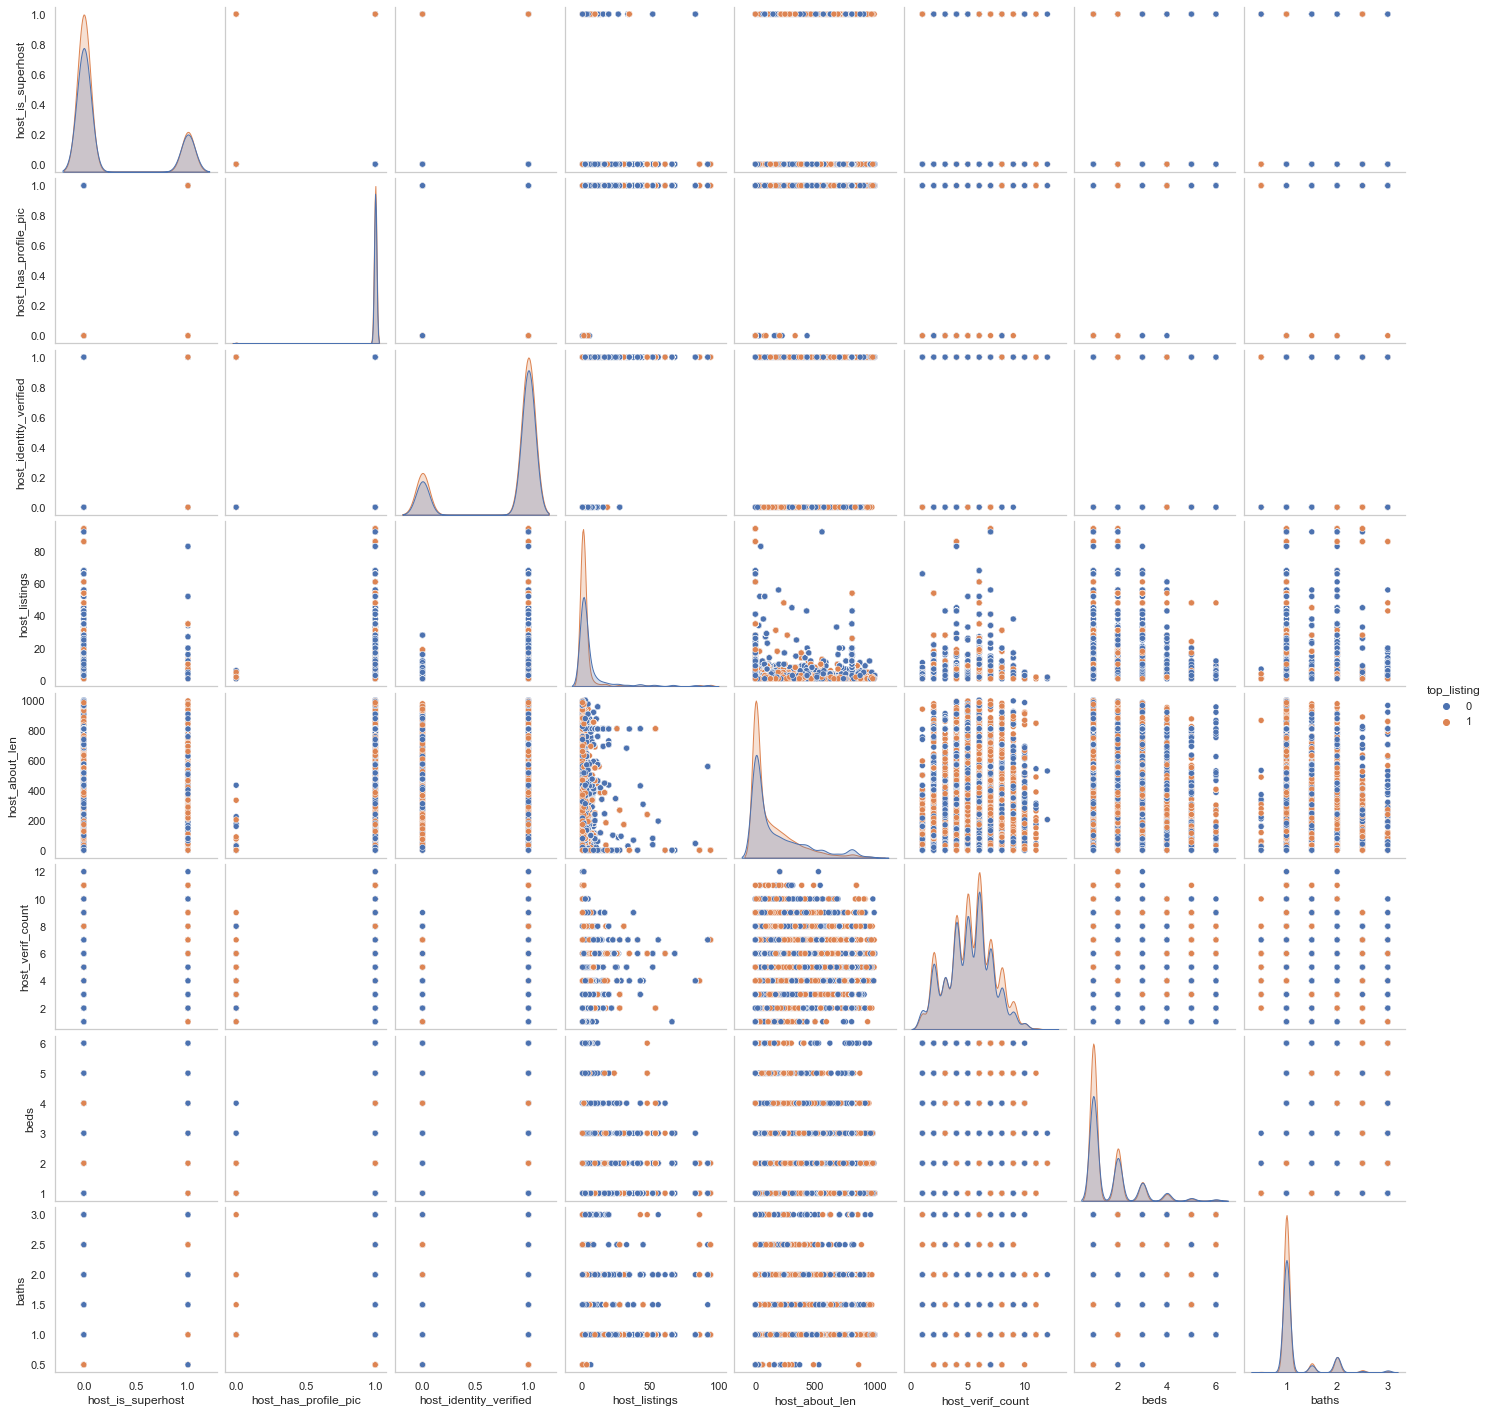

In [580]:
# Review pairplot after removal of outliers
get_pairplot_cols(listings_active_model_1, 1, 11)

<Figure size 432x288 with 0 Axes>

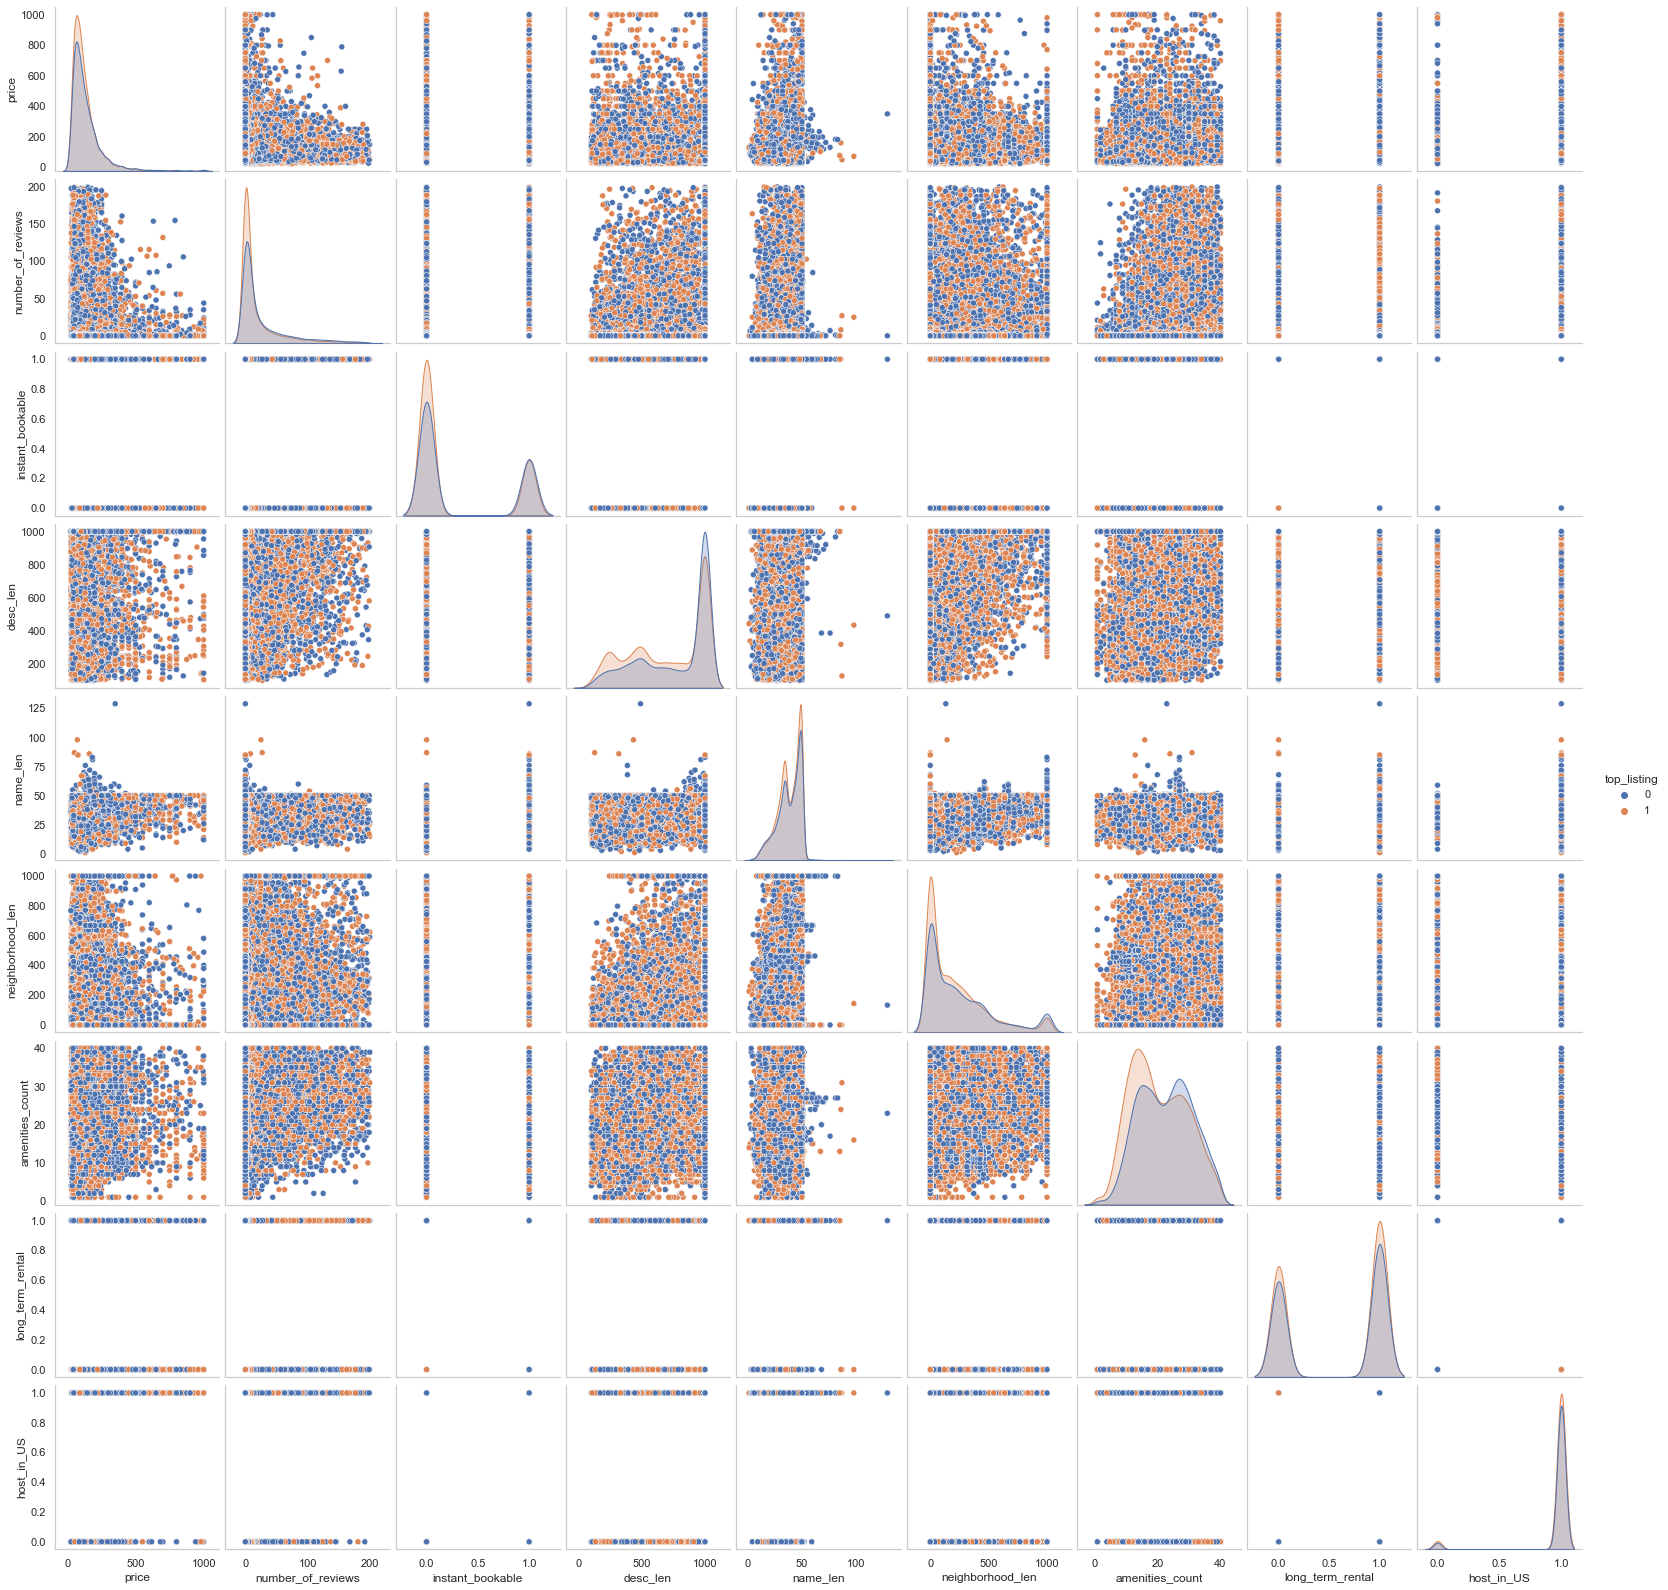

In [583]:
# Review pairplot after removal of outliers
get_pairplot_cols(listings_active_model_1, 11, 21)

<Figure size 432x288 with 0 Axes>

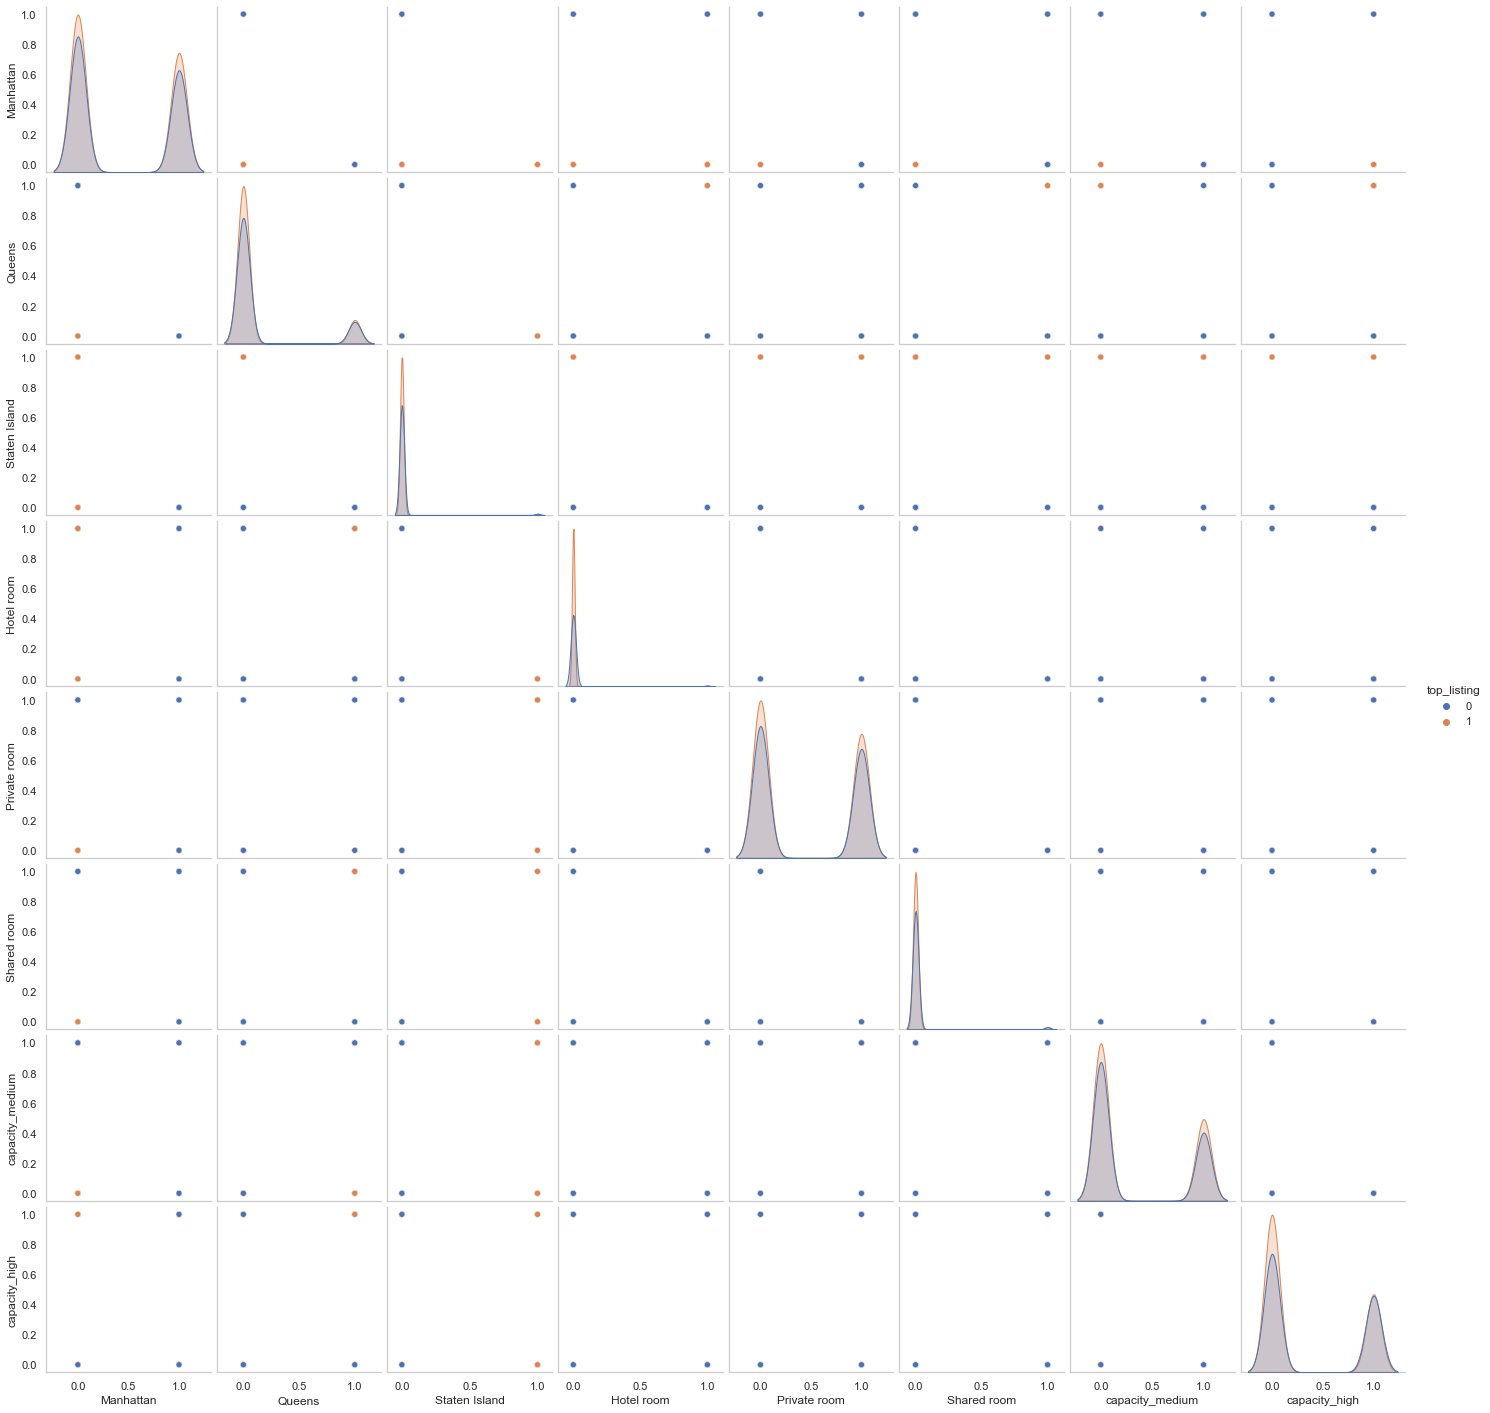

In [582]:
# Review pairplot after removal of outliers
get_pairplot_cols(listings_active_model_1, 21, 30)

#### Rerun models on dataset with no outliers

In [927]:
# Collect in a dictionary all the feature combinations that were tested prior to the removal of outliers
features_1 = {'features_base':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count']],
            'features_1':listings_active_model_1[['host_listings','host_about_len','num_rooms','number_of_reviews','desc_len','amenities_count']],
            'features_2':listings_active_model_1[['host_listings','beds','baths','content_len','number_of_reviews','amenities_count']],
            'features_3':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted']],
            'features_4':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','host_is_superhost']],
            'features_5':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','host_verif_count']],
            'features_6':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','price']],
            'features_7':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','price_pp']],
            'features_8':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable']],
            'features_9':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US']],
            'features_10':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn']],
            'features_11':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Manhattan']],
            'features_12':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Staten Island']],
            'features_13':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room']],
            'features_14':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room','Shared room']],
            'features_15':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room','capacity_high']],
            'features_16':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room','name_len']],
            'features_17':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room','neighborhood_len']],
            'features_18':listings_active_model_1[['host_listings','host_about_len','beds','baths','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room','long_term_rental']],
            'features_19':listings_active_model_1[['host_listings','host_about_len','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room','num_rooms']],
            'features_20':listings_active_model_1[['host_listings','host_about_len','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room','num_rooms','content_len']],
            'features_21':listings_active_model_1[['host_listings','number_of_reviews','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room','num_rooms','content_len']],
            'features_22':listings_active_model_1[['host_listings','host_about_len','number_of_reviews','desc_len','amenities_count','host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room','num_rooms','price_pp']]}

target_1 = listings_active_model_1['top_listing']

In [928]:
# Data without outliers | collect list of models
logreg_models_1 = dict()
knn_models_1 = dict()

In [929]:
# Define function to run simple validation on the model iterations
    
# define scaler
scaler = StandardScaler()

# define function
def simple_validation(features, target):
    
    # iterate through model counter and features
    for key, val in features.items():
        model_counter = key.split('_')[1]
        current_features = val
    
        # split data
        X_train, X_test, y_train, y_test = train_test_split(current_features, target, test_size = 0.2, random_state=42)

        # scale data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # logistic regression -- define and fit model on training data
        logreg = LogisticRegression(C=1)
        logreg.fit(X_train_scaled, y_train)

        # logistic regression -- compute prediction on testing data
        logreg_y_pred = logreg.predict(X_test_scaled)

        # knn -- define and fit model on training data
        knn = KNeighborsClassifier(n_neighbors=20) # optimal k of 20
        knn.fit(X_train_scaled, y_train)

        # knn -- compute prediction on testing data
        knn_y_pred = knn.predict(X_test_scaled)

        # logistic regression - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
        logreg_accuracy = logreg.score(X_test_scaled, y_test)
        logreg_fbeta = fbeta_score(y_test, logreg_y_pred, beta=0.35) # favoring precision (see rationale above)

        # knn - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
        knn_accuracy = knn.score(X_test_scaled, y_test)
        knn_fbeta = fbeta_score(y_test, knn_y_pred, beta=0.35) # favoring precision (see rationale above)

        # append to dictionary
        logreg_models_1['logreg_'+str(model_counter)] = float('{0:.4g}'.format(logreg_fbeta))
        knn_models_1['knn_'+str(model_counter)] = float('{0:.4g}'.format(knn_fbeta))

        print('\nLogReg_'+str(model_counter)+'| Test Accuracy score: \t', '{0:.4g}'.format(logreg_accuracy))
        print('LogReg_'+str(model_counter)+'| Test F1 beta score: \t', '{0:.4g}'.format(logreg_fbeta))
        print('\nKNN (K=20)_'+str(model_counter)+'| Test Accuracy score: \t', '{0:.4g}'.format(knn_accuracy))
        print('KNN (K=20)_'+str(model_counter)+'| Test F1 beta score: \t', '{0:.4g}'.format(knn_fbeta))

        pass

In [930]:
# Create function to automate delivery of model scoring results
def get_scores(model_dict_1,model_dict_2):
    for key, value in model_dict_1.items():
        print(key, ' :', value)
    
    print('')
    
    for key, value in model_dict_2.items():
        print(key, ' :', value)
    pass

In [931]:
simple_validation(features_1, target_1) # dataset with no outliers


LogReg_base| Test Accuracy score: 	 0.5926
LogReg_base| Test F1 beta score: 	 0.606

KNN (K=20)_base| Test Accuracy score: 	 0.6098
KNN (K=20)_base| Test F1 beta score: 	 0.629

LogReg_1| Test Accuracy score: 	 0.5944
LogReg_1| Test F1 beta score: 	 0.6074

KNN (K=20)_1| Test Accuracy score: 	 0.616
KNN (K=20)_1| Test F1 beta score: 	 0.6338

LogReg_2| Test Accuracy score: 	 0.5934
LogReg_2| Test F1 beta score: 	 0.6067

KNN (K=20)_2| Test Accuracy score: 	 0.6124
KNN (K=20)_2| Test F1 beta score: 	 0.6314

LogReg_3| Test Accuracy score: 	 0.5923
LogReg_3| Test F1 beta score: 	 0.6079

KNN (K=20)_3| Test Accuracy score: 	 0.6129
KNN (K=20)_3| Test F1 beta score: 	 0.6324

LogReg_4| Test Accuracy score: 	 0.5905
LogReg_4| Test F1 beta score: 	 0.6065

KNN (K=20)_4| Test Accuracy score: 	 0.6178
KNN (K=20)_4| Test F1 beta score: 	 0.6374

LogReg_5| Test Accuracy score: 	 0.5947
LogReg_5| Test F1 beta score: 	 0.6101

KNN (K=20)_5| Test Accuracy score: 	 0.615
KNN (K=20)_5| Test F1 beta 

In [932]:
# Model scores after the removal of outliers
get_scores(logreg_models_1,knn_models_1) # dataset without outliers

logreg_base  : 0.606
logreg_1  : 0.6074
logreg_2  : 0.6067
logreg_3  : 0.6079
logreg_4  : 0.6065
logreg_5  : 0.6101
logreg_6  : 0.6098
logreg_7  : 0.6082
logreg_8  : 0.6062
logreg_9  : 0.6081
logreg_10  : 0.6071
logreg_11  : 0.6076
logreg_12  : 0.6068
logreg_13  : 0.6081
logreg_14  : 0.6069
logreg_15  : 0.6087
logreg_16  : 0.6087
logreg_17  : 0.6073
logreg_18  : 0.6164
logreg_19  : 0.6066
logreg_20  : 0.6074
logreg_21  : 0.6142
logreg_22  : 0.6057

knn_base  : 0.629
knn_1  : 0.6338
knn_2  : 0.6314
knn_3  : 0.6324
knn_4  : 0.6374
knn_5  : 0.6338
knn_6  : 0.6375
knn_7  : 0.6287
knn_8  : 0.6356
knn_9  : 0.6391
knn_10  : 0.6345
knn_11  : 0.6386
knn_12  : 0.6326
knn_13  : 0.6358
knn_14  : 0.6332
knn_15  : 0.639
knn_16  : 0.634
knn_17  : 0.6427
knn_18  : 0.6412
knn_19  : 0.6372
knn_20  : 0.6403
knn_21  : 0.6432
knn_22  : 0.6335


In [933]:
# Model scores before the removal of outliers
model_iterations(logreg_models,knn_models) # dataset with outliers

logreg_baseline  : 0.5883
logreg_1  : 0.5876
logreg_2  : 0.5838
logreg_3  : 0.6063
logreg_4  : 0.6071
logreg_5  : 0.604
logreg_6  : 0.6069
logreg_7  : 0.6064
logreg_8  : 0.6085
logreg_9  : 0.6114
logreg_10  : 0.6122
logreg_11  : 0.6129
logreg_12  : 0.6124
logreg_13  : 0.6153
logreg_14  : 0.6157
logreg_15  : 0.6151
logreg_16  : 0.6076
logreg_17  : 0.6132
logreg_18  : 0.6153
logreg_19  : 0.6162
logreg_20  : 0.6141
logreg_21  : 0.6073
logreg_22  : 0.616

knn_baseline  : 0.6299
knn_1  : 0.6224
knn_2  : 0.6182
knn_3  : 0.6373
knn_4  : 0.6354
knn_5  : 0.6348
knn_6  : 0.6339
knn_7  : 0.6377
knn_8  : 0.6346
knn_9  : 0.6371
knn_10  : 0.639
knn_11  : 0.6433
knn_12  : 0.6408
knn_13  : 0.64
knn_14  : 0.6437
knn_15  : 0.633
knn_16  : 0.6392
knn_17  : 0.6418
knn_18  : 0.6394
knn_19  : 0.6416
knn_20  : 0.6391
knn_21  : 0.6409
knn_22  : 0.6438


In [940]:
# Data without outliers | Initialize dictionaries storing the top 3 models for logistic regression and kNN
logreg_top_3_no_out = {}
knn_top_3_no_out = {}

In [941]:
# Data with outliers | Initialize dictionaries storing the top 3 models for logistic regression and kNN
logreg_top_3 = {}
knn_top_3 = {}

In [942]:
# Extract top 3 models in logreg and top 3 models in knn
def get_top_models(model_dict_1,model_dict_2,model_1_top_3,model_2_top_3):
    
    # reinitialize dictionaries
    model_dict_1_temp = deepcopy(model_dict_1)
    model_dict_2_temp = deepcopy(model_dict_2)
    
    # get first(max) f1 beta for model 1
    first_model_1 = max(model_dict_1_temp, key=model_dict_1_temp.get)
    first_model_1_f1beta = model_dict_1_temp[first_model_1]
    model_1_top_3[first_model_1] = float('{0:.4g}'.format(first_model_1_f1beta))
    del model_dict_1_temp[first_model_1]
    
    # get second f1 beta for model 1
    second_model_1 = max(model_dict_1_temp, key=model_dict_1_temp.get)
    second_model_1_f1beta = model_dict_1_temp[second_model_1]
    model_1_top_3[second_model_1] = float('{0:.4g}'.format(second_model_1_f1beta))
    del model_dict_1_temp[second_model_1]
    
    # get third f1 beta for model 1
    third_model_1 = max(model_dict_1_temp, key=model_dict_1_temp.get)
    third_model_1_f1beta = model_dict_1_temp[third_model_1]
    model_1_top_3[third_model_1] = float('{0:.4g}'.format(third_model_1_f1beta))
    
    # get first(max) f1 beta for model 2
    first_model_2 = max(model_dict_2_temp, key=model_dict_2_temp.get)
    first_model_2_f1beta = model_dict_2_temp[first_model_2]
    model_2_top_3[first_model_2] = float('{0:.4g}'.format(first_model_2_f1beta))
    del model_dict_2_temp[first_model_2]
    
    # get second f1 beta for model 2
    second_model_2 = max(model_dict_2_temp, key=model_dict_2_temp.get)
    second_model_2_f1beta = model_dict_2_temp[second_model_2]
    model_2_top_3[second_model_2] = float('{0:.4g}'.format(second_model_2_f1beta))
    del model_dict_2_temp[second_model_2]
    
    # get third f1 beta for model 2
    third_model_2 = max(model_dict_2_temp, key=model_dict_2_temp.get)
    third_model_2_f1beta = model_dict_2_temp[third_model_2]
    model_2_top_3[third_model_2] = float('{0:.4g}'.format(third_model_2_f1beta))
    
    for model, f1beta in model_1_top_3.items():
        print('{} {}'.format(model, f1beta))
    
    print('')
    
    for model, f1beta in model_2_top_3.items():
        print('{}: {}'.format(model, f1beta))
    
    pass

In [943]:
# Data without outliers | Top 3 scores for Logistic Regression and kNN models 
get_top_models(logreg_models_1,knn_models_1,logreg_top_3_no_out,knn_top_3_no_out)

logreg_18 0.6164
logreg_21 0.6142
logreg_5 0.6101

knn_21: 0.6432
knn_17: 0.6427
knn_18: 0.6412


In [944]:
# Data with outliers | Top 3 scores for Logistic Regression and kNN models 
get_top_models(logreg_models,knn_models,logreg_top_3,knn_top_3)

logreg_19 0.6162
logreg_22 0.616
logreg_14 0.6157

knn_22: 0.6438
knn_14: 0.6437
knn_11: 0.6433


-----

**Outliers will be kept in the data** as outliers removal does not really impact the metric of choice, F beta. By adding ca. 6000 more rows (i.e. rows corresponding to outliers observations) I am hoping to improve my model going forward.

**logreg_19** and **knn_22** will be tested in the cross-validation schema against random forest and XGBoost models (see below).

-----

### Model expansion

#### 1. Random Forest

In [1000]:
# Import dataframe for random forest
listings_rf = pd.read_pickle('listings_randomforest.pickle')

In [1001]:
listings_rf.shape

(35447, 39)

In [1002]:
# Check for missing values
listings_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35447 entries, 0 to 36904
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           35447 non-null  int64         
 1   host_since                   35447 non-null  datetime64[ns]
 2   host_response_time           18564 non-null  object        
 3   host_response_rate           18564 non-null  float64       
 4   host_acceptance_rate         20083 non-null  float64       
 5   host_is_superhost            35447 non-null  int64         
 6   host_has_profile_pic         35447 non-null  int64         
 7   host_identity_verified       35447 non-null  int64         
 8   neighbourhood                35447 non-null  object        
 9   borough                      35447 non-null  object        
 10  latitude                     35447 non-null  float64       
 11  longitude                    35447 non-nu

In [1003]:
listings_rf.shape # df including values with missing data

(35447, 39)

In [1004]:
listings_active_model.shape # df used for LogReg and kNN after removing inactive listings (and before removing outliers - which we have decided not to remove)

(26026, 37)

In [1005]:
listings_active_model.columns

Index(['id', 'host_since', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'host_listings', 'host_about_len',
       'host_verif_count', 'beds', 'baths', 'bath_private', 'price',
       'number_of_reviews', 'instant_bookable', 'desc_len', 'name_len',
       'neighborhood_len', 'amenities_count', 'long_term_rental', 'host_in_US',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Hotel room',
       'Private room', 'Shared room', 'capacity_medium', 'capacity_high',
       'top_listing', 'num_rooms', 'content_len', 'host_since_year',
       'host_since_converted', 'capacity', 'accommodates', 'price_pp'],
      dtype='object')

In [1006]:
# Filter df by columns of interest
listings_temp = airbnb_raw[['id','host_response_time','host_response_rate','host_acceptance_rate',
                           'availability_365','review_scores_rating','review_scores_accuracy',
                           'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                           'review_scores_location','review_scores_value','reviews_per_month','latitude','longitude']]

In [1007]:
listings_temp.shape

(36905, 15)

In [1008]:
# Add relevant cols for analysis
listings_active_rf = listings_active_model.merge(listings_temp, how='left',on=['id'])

In [1009]:
listings_active_rf.shape

(26026, 51)

In [1010]:
listings_active_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26026 entries, 0 to 26025
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           26026 non-null  int64         
 1   host_since                   26026 non-null  datetime64[ns]
 2   host_is_superhost            26026 non-null  int64         
 3   host_has_profile_pic         26026 non-null  int64         
 4   host_identity_verified       26026 non-null  int64         
 5   host_listings                26026 non-null  int64         
 6   host_about_len               26026 non-null  int64         
 7   host_verif_count             26026 non-null  int64         
 8   beds                         26026 non-null  float64       
 9   baths                        26026 non-null  float64       
 10  bath_private                 26026 non-null  int64         
 11  price                        26026 non-nu

In [1011]:
# One hot encoding for host_response_time

# impute NaN
listings_active_rf['host_response_time'].fillna('Response time not specified',inplace=True)

# Get one hot encoding
one_hot = pd.get_dummies(listings_active_rf['host_response_time'],drop_first=True)

# Drop column B as it is now encoded
listings_active_rf = listings_active_rf.drop('host_response_time',axis = 1)

# Join the encoded df
listings_active_rf = listings_active_rf.join(one_hot)

In [1012]:
# Adjust data type
listings_active_rf['host_response_rate'] = pd.to_numeric(listings_active_rf['host_response_rate'].str.strip('%')).div(100)

In [1013]:
# Fill NaN for host_response_rate
listings_active_rf['host_response_rate'].fillna(-0.9999,inplace=True)

In [1014]:
# Adjust data type
listings_active_rf['host_acceptance_rate'] = pd.to_numeric(listings_active_rf['host_acceptance_rate'].str.strip('%')).div(100)

In [1015]:
# Fill NaN for host_acceptance_rate
listings_active_rf['host_acceptance_rate'].fillna(-0.9999,inplace=True)

In [1016]:
# Fill NaN for review_scores_rating
listings_active_rf['review_scores_rating'].fillna(-999,inplace=True)

In [1017]:
# Fill NaN for review_scores_accuracy
listings_active_rf['review_scores_accuracy'].fillna(-999,inplace=True)

In [1018]:
# Fill NaN for review_scores_cleanliness
listings_active_rf['review_scores_cleanliness'].fillna(-999,inplace=True)

In [1019]:
# Fill NaN for review_scores_checkin
listings_active_rf['review_scores_checkin'].fillna(-999,inplace=True)

In [1020]:
# Fill NaN for review_scores_communication
listings_active_rf['review_scores_communication'].fillna(-999,inplace=True)

In [1021]:
# Fill NaN for review_scores_location
listings_active_rf['review_scores_location'].fillna(-999,inplace=True)

In [1022]:
# Fill NaN for review_scores_value
listings_active_rf['review_scores_value'].fillna(-999,inplace=True)

In [1023]:
# Fill NaN for reviews_per_month
listings_active_rf['reviews_per_month'].fillna(-999,inplace=True)

In [1024]:
listings_active_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26026 entries, 0 to 26025
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           26026 non-null  int64         
 1   host_since                   26026 non-null  datetime64[ns]
 2   host_is_superhost            26026 non-null  int64         
 3   host_has_profile_pic         26026 non-null  int64         
 4   host_identity_verified       26026 non-null  int64         
 5   host_listings                26026 non-null  int64         
 6   host_about_len               26026 non-null  int64         
 7   host_verif_count             26026 non-null  int64         
 8   beds                         26026 non-null  float64       
 9   baths                        26026 non-null  float64       
 10  bath_private                 26026 non-null  int64         
 11  price                        26026 non-nu

In [1025]:
listings_active_rf.columns

Index(['id', 'host_since', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'host_listings', 'host_about_len',
       'host_verif_count', 'beds', 'baths', 'bath_private', 'price',
       'number_of_reviews', 'instant_bookable', 'desc_len', 'name_len',
       'neighborhood_len', 'amenities_count', 'long_term_rental', 'host_in_US',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Hotel room',
       'Private room', 'Shared room', 'capacity_medium', 'capacity_high',
       'top_listing', 'num_rooms', 'content_len', 'host_since_year',
       'host_since_converted', 'capacity', 'accommodates', 'price_pp',
       'host_response_rate', 'host_acceptance_rate', 'availability_365',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'latitude', 'longitude',
       'a few days or

In [1172]:
# Choose features and target
features_rf = listings_active_rf[['host_since_converted', 'host_is_superhost', 'host_has_profile_pic',
                                  'host_identity_verified', 'host_listings', 'host_about_len',
                                  'host_verif_count', 'beds', 'baths', 'bath_private', 'price',
                                  'number_of_reviews', 'instant_bookable', 'desc_len', 'name_len',
                                  'neighborhood_len', 'amenities_count', 'long_term_rental', 'host_in_US',
                                  'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Hotel room',
                                  'Private room', 'Shared room', 'capacity_medium', 'capacity_high',
                                  'content_len', 'price_pp','host_response_rate', 'host_acceptance_rate',
                                  'review_scores_rating', 'review_scores_accuracy',
                                  'review_scores_cleanliness', 'review_scores_checkin',
                                  'review_scores_communication', 'review_scores_location',
                                  'review_scores_value', 'reviews_per_month','a few days or more', 
                                  'within a day', 'within a few hours','within an hour']]

target_rf = listings_active_rf['top_listing']

In [1173]:
rf_models = {}

In [1306]:
# Define function for random forest classifier

def rf_classifier(features, target):
    
    # model counter
    rf_model_count = len(rf_models)
    if rf_model_count == 0:
        i = 1
    else:
        i = rf_model_count + 1
    
    # split data
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

    # initiate RF classifier
    global rf
    rf = RandomForestClassifier(n_estimators=100, criterion = 'gini', bootstrap=True, n_jobs = -1, random_state=42, max_features='sqrt')
    
    # fit the model on training data
    rf.fit(X_train, y_train)
    
    # prediction on test data
    rf_y_pred = rf.predict(X_test)
    
    # compute metric of interest
    rf_fbeta = fbeta_score(y_test, rf_y_pred, beta=0.35) # favoring precision (see rationale above)

    # append to dict
    rf_models['Random Forest_'+str(i)] = float('{0:.4g}'.format(rf_fbeta))
    
    print('Random Forest_'+str(i)+' | Test Test F1 beta score: \t', '{0:.4g}'.format(rf_fbeta))

    pass

In [1307]:
rf_classifier(features_rf, target_rf)

Random Forest_2 | Test Test F1 beta score: 	 0.7375


In [1183]:
# Table of feature importances for Random Forest
rf_feature_importance = pd.DataFrame(np.round(rf.feature_importances_,4), index=features_rf.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
rf_feature_importance

feature importance
host_since_converted                     0.0689
content_len                              0.0658
price                                    0.0618
price_pp                                 0.0580
host_listings                            0.0564
amenities_count                          0.0551
name_len                                 0.0503
host_acceptance_rate                     0.0479
host_about_len                           0.0467
host_response_rate                       0.0456
reviews_per_month                        0.0447
number_of_reviews                        0.0431
neighborhood_len                         0.0408
desc_len                                 0.0382
host_verif_count                         0.0323
review_scores_rating                     0.0282
beds                                     0.0200
review_scores_value                      0.0132
baths                                    0.0123
review_scores_cleanliness                0.0117
long_term_rental                         0.0111
instant_bookable                         0.0105
review_scores_accuracy                   0.0101
capacity_medium                          0.0090
Brooklyn                                 0.0088
review_scores_location                   0.0088
Manhattan                                0.0086
Private room                             0.0086
bath_private                             0.0081
review_scores_checkin                    0.0078
within an hour                           0.0075
Queens                                   0.0074
capacity_high                            0.0073
host_identity_verified                   0.0071
host_is_superhost                        0.0069
within a few hours                       0.0069
review_scores_communication              0.0061
within a day                             0.0055
a few days or more                       0.0054
host_in_US                               0.0032
Shared room                              0.0018
Staten Island                            0.0014
Hotel room                               0.0006
host_has_profile_pic                     0.0005

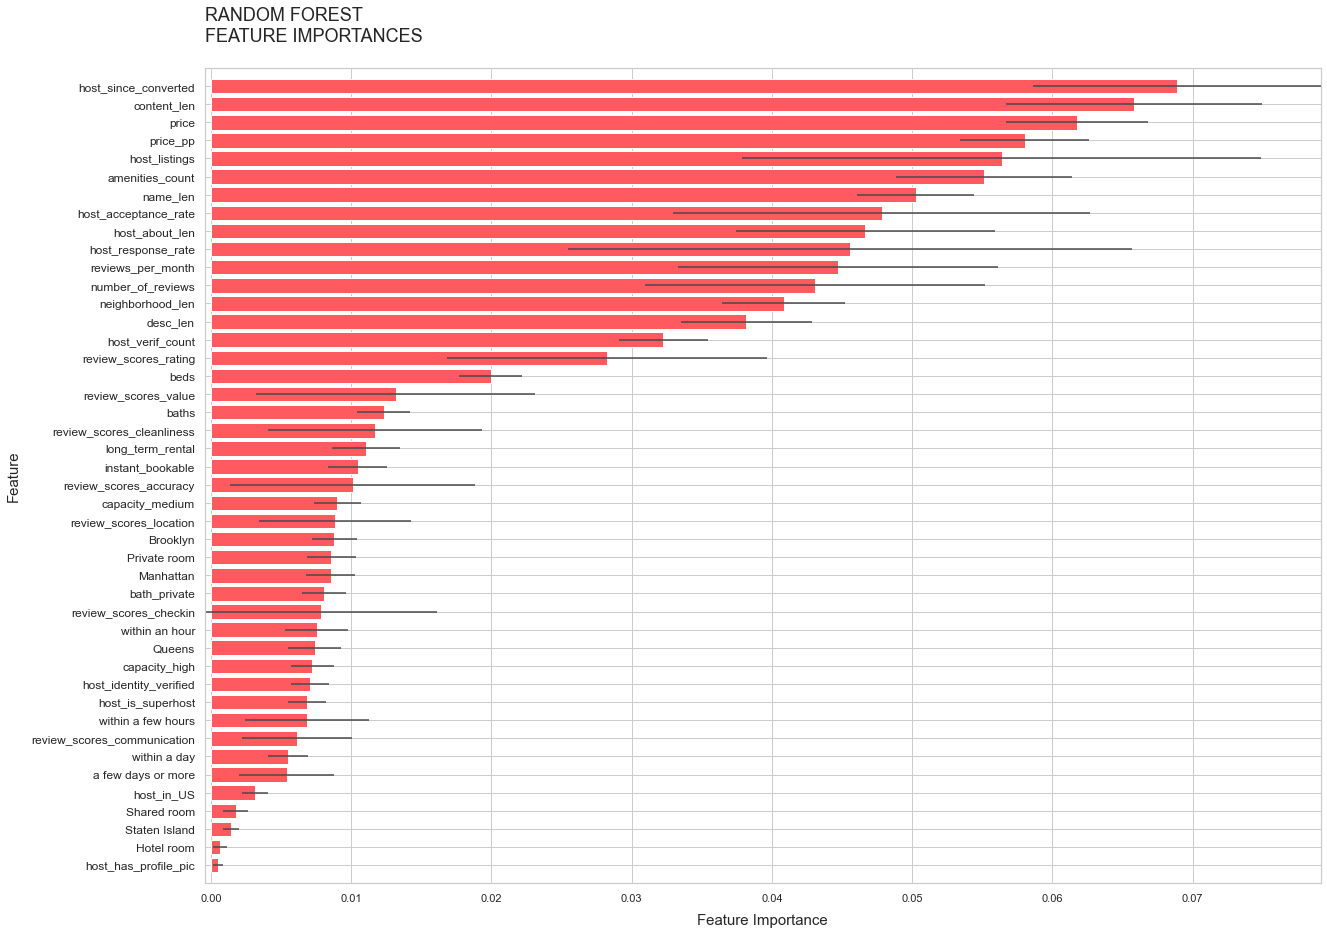

In [1309]:
# Plot feature importances

# compute feature importance and std
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("RANDOM FOREST\nFEATURE IMPORTANCES\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X_test.shape[1]), importances[indices],
       color = '#FF5A5F',ecolor ='#484848', xerr=std[indices], align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X_test.shape[1]), [features_rf.columns[i] for i in indices],fontsize = 12)
plt.ylim([-1, X_test.shape[1]])
plt.show()

#### 2. XGboost

In [1338]:
xgb_models = {}

In [1339]:
# Choose features and target - same as for random forest
features_xgb = listings_active_rf[['host_since_converted', 'host_is_superhost', 'host_has_profile_pic',
                                  'host_identity_verified', 'host_listings', 'host_about_len',
                                  'host_verif_count', 'beds', 'baths', 'bath_private', 'price',
                                  'number_of_reviews', 'instant_bookable', 'desc_len', 'name_len',
                                  'neighborhood_len', 'amenities_count', 'long_term_rental', 'host_in_US',
                                  'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Hotel room',
                                  'Private room', 'Shared room', 'capacity_medium', 'capacity_high',
                                  'content_len', 'price_pp','host_response_rate', 'host_acceptance_rate',
                                  'review_scores_rating', 'review_scores_accuracy',
                                  'review_scores_cleanliness', 'review_scores_checkin',
                                  'review_scores_communication', 'review_scores_location',
                                  'review_scores_value', 'reviews_per_month','a few days or more', 
                                  'within a day', 'within a few hours','within an hour']]

target_xgb = listings_active_rf['top_listing']

In [1340]:
# Define function for XGB Classifier

def xgb_classifier(features,target):
    
    # model counter
    xgb_models_count = len(xgb_models)
    if xgb_models_count == 0:
        i = 1
    else:
        i = xgb_models_count + 1
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

    # define XGB Classifier 
    global xgb_class
    xgb_class = xgb.XGBClassifier( 
                            n_estimators=30000,
                            max_depth=8,
                            objective='binary:logistic',
                            learning_rate=.05, 
                            subsample=.8,
                            min_child_weight=3,
                            colsample_bytree=.8,
                            n_jobs = -1,
                            random_state=42,
                            use_label_encoder =False
                           )
    
    # establish evaluation set
    eval_set=[(X_train,y_train),(X_test,y_test)]
    
    # fit model
    fit_model = xgb_class.fit( 
                        X_train, y_train, 
                        eval_set=eval_set,  
                        early_stopping_rounds=50,
                        verbose=False,
                        eval_metric='error'
                       )

    # compute preds
    xgb_preds = xgb_class.predict(X_test, ntree_limit=xgb_class.best_ntree_limit)
    
    # compute metric of interest
    xgb_fbeta = fbeta_score(y_test, xgb_preds, beta=0.35) # favoring precision (see rationale above)

    # append to dict
    xgb_models['XGBoost_'+str(i)] = float('{0:.4g}'.format(xgb_fbeta))
    
    print('XGBoost_'+str(i)+' | Test F1 beta score: \t', '{0:.4g}'.format(xgb_fbeta))

    pass

In [1341]:
xgb_classifier(features_xgb,target_xgb)

XGBoost_1 | Test F1 beta score: 	 0.7472


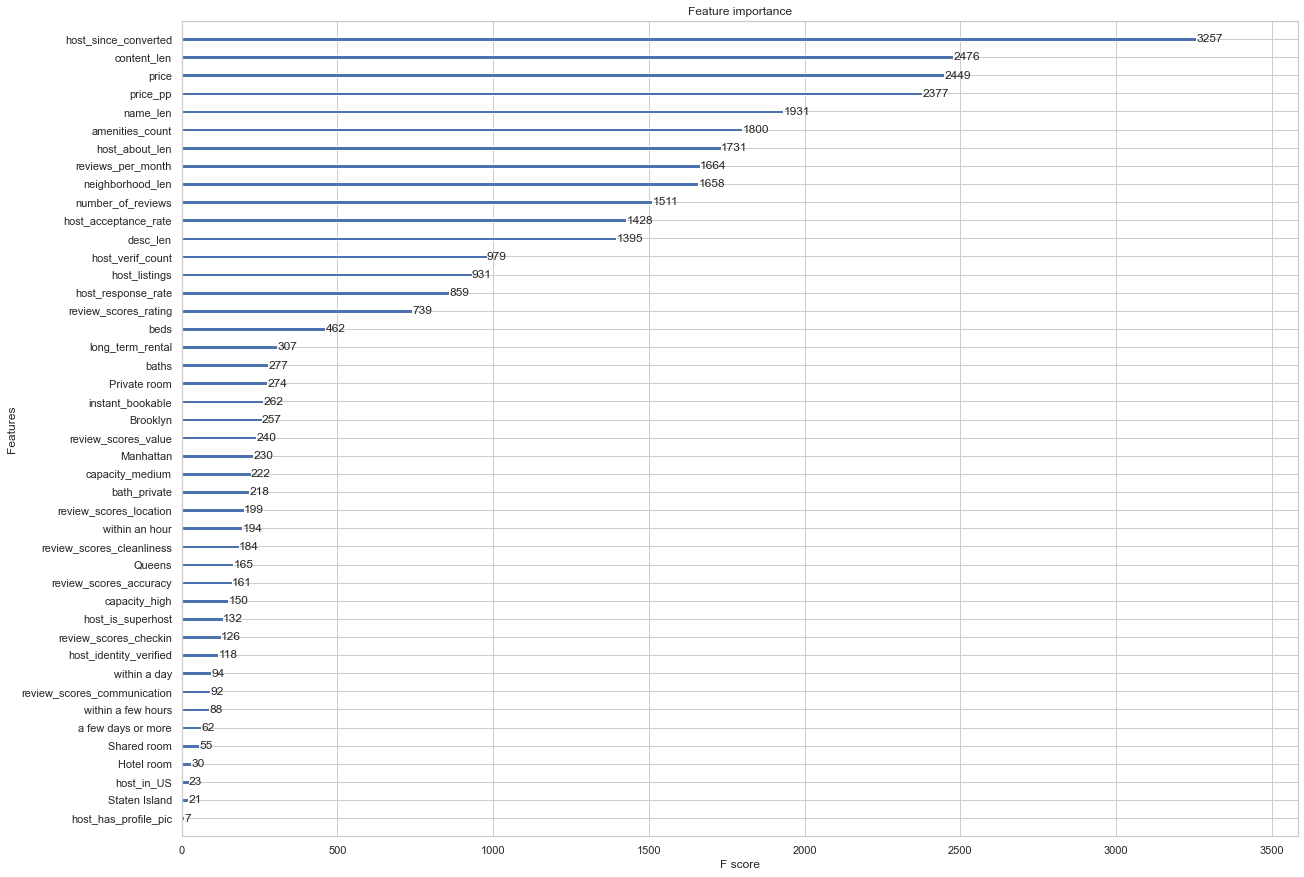

In [1342]:
# Plot feature importances(frequency)

plt.rcParams["figure.figsize"] = (20, 15)
xgb.plot_importance(xgb_class);

In [1343]:
# Feature importance table (frequency)
boost = xgb_class.get_booster().get_score(importance_type='weight')
xgb_feature_importance_fr = pd.DataFrame(list(boost.items()),columns = ['feature','feature importance']).sort_values('feature importance', ascending=False)
xgb_feature_importance_fr.set_index('feature', inplace=True)
xgb_feature_importance_fr.index.name = None
xgb_feature_importance_fr

feature importance
host_since_converted                       3257
content_len                                2476
price                                      2449
price_pp                                   2377
name_len                                   1931
amenities_count                            1800
host_about_len                             1731
reviews_per_month                          1664
neighborhood_len                           1658
number_of_reviews                          1511
host_acceptance_rate                       1428
desc_len                                   1395
host_verif_count                            979
host_listings                               931
host_response_rate                          859
review_scores_rating                        739
beds                                        462
long_term_rental                            307
baths                                       277
Private room                                274
instant_bookable                            262
Brooklyn                                    257
review_scores_value                         240
Manhattan                                   230
capacity_medium                             222
bath_private                                218
review_scores_location                      199
within an hour                              194
review_scores_cleanliness                   184
Queens                                      165
review_scores_accuracy                      161
capacity_high                               150
host_is_superhost                           132
review_scores_checkin                       126
host_identity_verified                      118
within a day                                 94
review_scores_communication                  92
within a few hours                           88
a few days or more                           62
Shared room                                  55
Hotel room                                   30
host_in_US                                   23
Staten Island                                21
host_has_profile_pic                          7

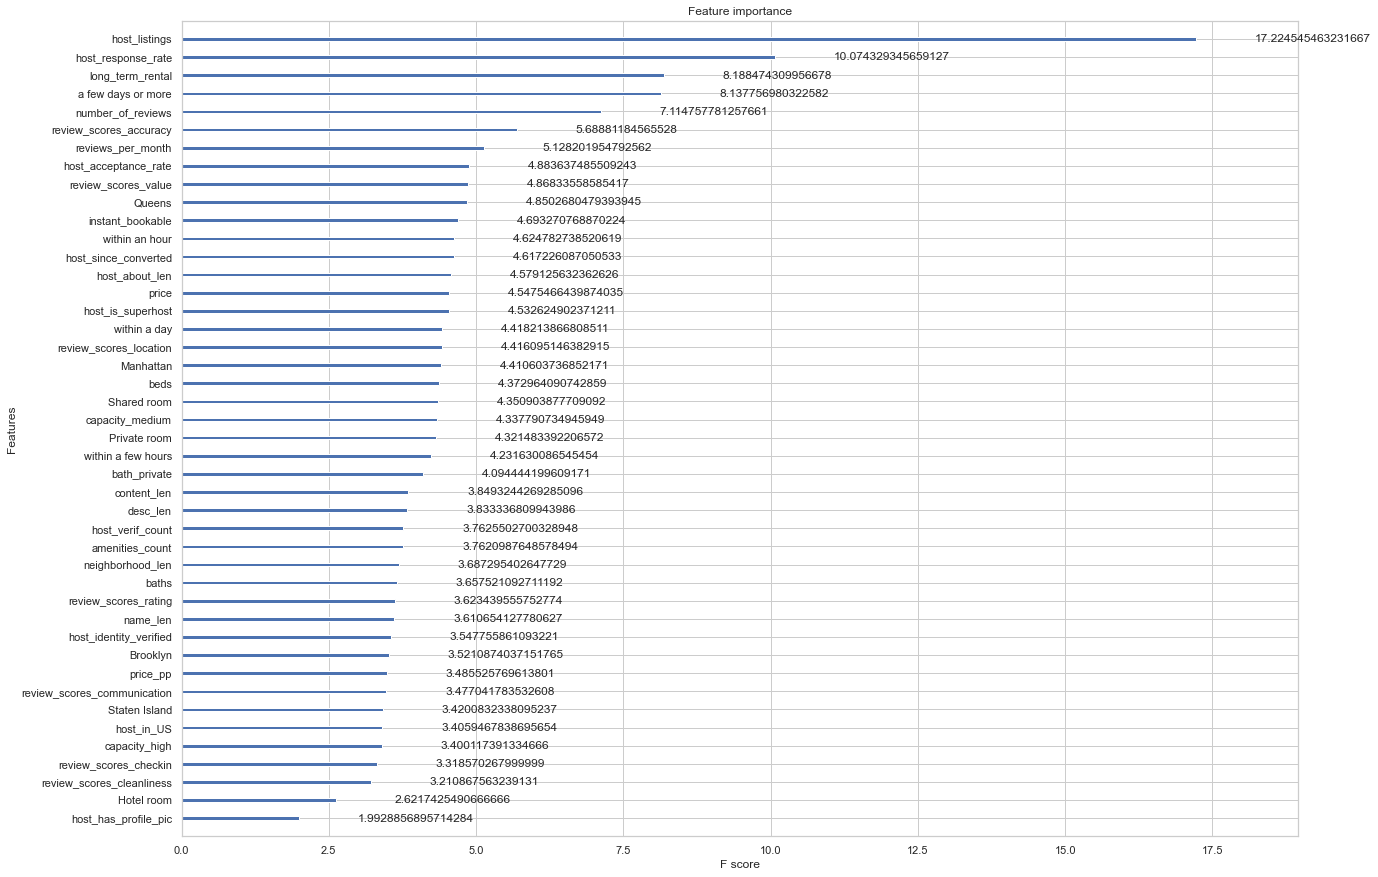

In [1344]:
# Plot feature importances(gain)

plt.rcParams["figure.figsize"] = (20, 15)
xgb.plot_importance(xgb_class,importance_type='gain');

In [1345]:
# Feature importance table (gain)

boost_g = xgb_class.get_booster().get_score(importance_type='gain')
xgb_feature_importance_g = pd.DataFrame(list(boost_g.items()),columns = ['feature','feature importance']).sort_values('feature importance', ascending=False)
xgb_feature_importance_g.set_index('feature', inplace=True)
xgb_feature_importance_g.index.name = None
xgb_feature_importance_g

feature importance
host_listings                         17.224545
host_response_rate                    10.074329
long_term_rental                       8.188474
a few days or more                     8.137757
number_of_reviews                      7.114758
review_scores_accuracy                 5.688812
reviews_per_month                      5.128202
host_acceptance_rate                   4.883637
review_scores_value                    4.868336
Queens                                 4.850268
instant_bookable                       4.693271
within an hour                         4.624783
host_since_converted                   4.617226
host_about_len                         4.579126
price                                  4.547547
host_is_superhost                      4.532625
within a day                           4.418214
review_scores_location                 4.416095
Manhattan                              4.410604
beds                                   4.372964
Shared room                            4.350904
capacity_medium                        4.337791
Private room                           4.321483
within a few hours                     4.231630
bath_private                           4.094444
content_len                            3.849324
desc_len                               3.833337
host_verif_count                       3.762550
amenities_count                        3.762099
neighborhood_len                       3.687295
baths                                  3.657521
review_scores_rating                   3.623440
name_len                               3.610654
host_identity_verified                 3.547756
Brooklyn                               3.521087
price_pp                               3.485526
review_scores_communication            3.477042
Staten Island                          3.420083
host_in_US                             3.405947
capacity_high                          3.400117
review_scores_checkin                  3.318570
review_scores_cleanliness              3.210868
Hotel room                             2.621743
host_has_profile_pic                   1.992886

## Cross Validation

In [1433]:
# features of top kNN model
features_knn_22 = listings_active_rf[['host_listings','host_about_len','number_of_reviews','desc_len','amenities_count',
                                      'host_since_converted','instant_bookable','host_in_US','Brooklyn','Hotel room',
                                      'num_rooms','price_pp']]

# features of top logistic regression model
features_lr_19 = listings_active_rf[['host_listings','host_about_len','number_of_reviews','desc_len',
                                     'amenities_count','host_since_converted','instant_bookable',
                                     'host_in_US','Brooklyn','Hotel room','num_rooms']]
# same features as xgboosting
features_rf_1 = listings_active_rf[['host_since_converted', 'host_is_superhost', 'host_has_profile_pic',
                                  'host_identity_verified', 'host_listings', 'host_about_len',
                                  'host_verif_count', 'beds', 'baths', 'bath_private', 'price',
                                  'number_of_reviews', 'instant_bookable', 'desc_len', 'name_len',
                                  'neighborhood_len', 'amenities_count', 'long_term_rental', 'host_in_US',
                                  'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Hotel room',
                                  'Private room', 'Shared room', 'capacity_medium', 'capacity_high',
                                  'content_len', 'price_pp','host_response_rate', 'host_acceptance_rate',
                                  'review_scores_rating', 'review_scores_accuracy',
                                  'review_scores_cleanliness', 'review_scores_checkin',
                                  'review_scores_communication', 'review_scores_location',
                                  'review_scores_value', 'reviews_per_month','a few days or more', 
                                  'within a day', 'within a few hours','within an hour']]
# same features as random forest
features_xgb_1 = listings_active_rf[['host_since_converted', 'host_is_superhost', 'host_has_profile_pic',
                                  'host_identity_verified', 'host_listings', 'host_about_len',
                                  'host_verif_count', 'beds', 'baths', 'bath_private', 'price',
                                  'number_of_reviews', 'instant_bookable', 'desc_len', 'name_len',
                                  'neighborhood_len', 'amenities_count', 'long_term_rental', 'host_in_US',
                                  'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Hotel room',
                                  'Private room', 'Shared room', 'capacity_medium', 'capacity_high',
                                  'content_len', 'price_pp','host_response_rate', 'host_acceptance_rate',
                                  'review_scores_rating', 'review_scores_accuracy',
                                  'review_scores_cleanliness', 'review_scores_checkin',
                                  'review_scores_communication', 'review_scores_location',
                                  'review_scores_value', 'reviews_per_month','a few days or more', 
                                  'within a day', 'within a few hours','within an hour']]

target = listings_active_rf['top_listing']

In [1434]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42) 
model_list = ['knn','lr','rf','xbg']
validation_knn = []
validation_lr = []
validation_rf = []
validation_xgb = []

In [1435]:
# split data into 3: 60% train, 20% validation, 20% test

for current_model in model_list:
    
    # initiate scaler
    scaler = StandardScaler()
    
    if current_model == 'knn':
        
        # select features and target
        X = features_knn_22
        y = target
    
    elif current_model == 'lr':
        
        # select features and target
        X = features_lr_19
        y = target
    
    elif current_model == 'rf':
        
        # select features and target
        X = features_rf_1
        y = target
        
    else:
        
        # select features and target
        X = features_xgb_1
        y = target
    
    # hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    # create arrays for indexing
    X, y = np.array(X), np.array(y)    
    
    for train_ind, val_ind in kf.split(X,y):
        
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        # scale data for knn and logistic regression
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        if current_model == 'knn':
            
            # knn -- define and fit model on training data
            knn = KNeighborsClassifier(n_neighbors=20) # optimal k of 20
            knn.fit(X_train_scaled, y_train)

            # knn -- compute prediction on testing data
            knn_y_pred = knn.predict(X_val_scaled)

            # knn -- compute F1beta
            knn_fbeta = fbeta_score(y_val, knn_y_pred, beta=0.35) # favoring precision (see rationale above)

            # append validation result to list
            validation_knn.append(float('{0:.4g}'.format(knn_fbeta)))

        elif current_model == 'lr':

            # logistic regression -- define and fit model on training data
            lr = LogisticRegression(C=1)
            lr.fit(X_train_scaled, y_train)

            # logistic regression -- compute prediction on testing data
            lr_y_pred = lr.predict(X_val_scaled)

            # logistic regression -- compute F1beta
            lr_fbeta = fbeta_score(y_val, lr_y_pred, beta=0.35) # favoring precision (see rationale above)

            # append validation result to list
            validation_lr.append(float('{0:.4g}'.format(lr_fbeta)))

        elif current_model == 'rf':

            # initiate RF classifier and fit the model on training data
            rf_cl = RandomForestClassifier(n_estimators=100, criterion = 'gini', bootstrap=True, n_jobs = -1, random_state=42, max_features='sqrt')
            rf_cl.fit(X_train, y_train)

            # prediction on test data
            rf_y_pred = rf_cl.predict(X_val)

            # random forest -- compute F1beta
            rf_fbeta = fbeta_score(y_val, rf_y_pred, beta=0.35) # favoring precision (see rationale above)

            # append validation result to list
            validation_rf.append(float('{0:.4g}'.format(rf_fbeta)))

        else:

            # initiate the classifier
            xgb_cl = xgb.XGBClassifier( 
                                    n_estimators=30000,
                                    max_depth=8,
                                    objective='binary:logistic',
                                    learning_rate=.05, 
                                    subsample=.8,
                                    min_child_weight=3,
                                    colsample_bytree=.8,
                                    n_jobs = -1,
                                    random_state=42,
                                    use_label_encoder =False
                                   )

            # establish evaluation set
            eval_set=[(X_train,y_train),(X_val,y_val)]

            # fit model
            fit_model = xgb_cl.fit( 
                                X_train, y_train, 
                                eval_set=eval_set,  
                                early_stopping_rounds=50,
                                verbose=False,
                                eval_metric='error'
                               )

            # compute preds
            xgb_preds = xgb_cl.predict(X_val, ntree_limit=xgb_cl.best_ntree_limit)

            # compute metric of interest
            xgb_fbeta = fbeta_score(y_val, xgb_preds, beta=0.35) # favoring precision (see rationale above)

            # append validation result to list
            validation_xgb.append(float('{0:.4g}'.format(xgb_fbeta)))

print(f'kNN | ValidationF beta (beta = 0.35): \t{validation_knn} | Average = {round(sum(validation_knn) / len(validation_knn),4)} \n')
print(f'Logistic Regression | ValidationF beta (beta = 0.35): \t{validation_lr} | Average = {round(sum(validation_lr) / len(validation_lr),4)} \n')
print(f'Random Forest | Validation F beta (beta = 0.35): \t{validation_rf} | Average = {round(sum(validation_rf) / len(validation_rf),4)} \n')
print(f'XGBoosting | Validation F beta (beta = 0.35): \t{validation_xgb} | Average = {round(sum(validation_xgb) / len(validation_xgb),4)} \n')

kNN | ValidationF beta (beta = 0.35): 	[0.6183, 0.6309, 0.6414, 0.6393, 0.6275] | Average = 0.6315 

Logistic Regression | ValidationF beta (beta = 0.35): 	[0.5847, 0.5963, 0.6076, 0.6083, 0.5965] | Average = 0.5987 

Random Forest | Validation F beta (beta = 0.35): 	[0.7168, 0.7434, 0.7373, 0.7263, 0.7312] | Average = 0.731 

XGBoosting | Validation F beta (beta = 0.35): 	[0.717, 0.734, 0.7496, 0.7309, 0.7261] | Average = 0.7315 



----

From the cross-validation above it's clear that **Random Forest and XGBoosting are the two best models** to optimize this model's metric of choice: F beta. This is likely an indication of the fact that, like many phenomena and relationships in nature, the one we are trying to model here is not linear.

----

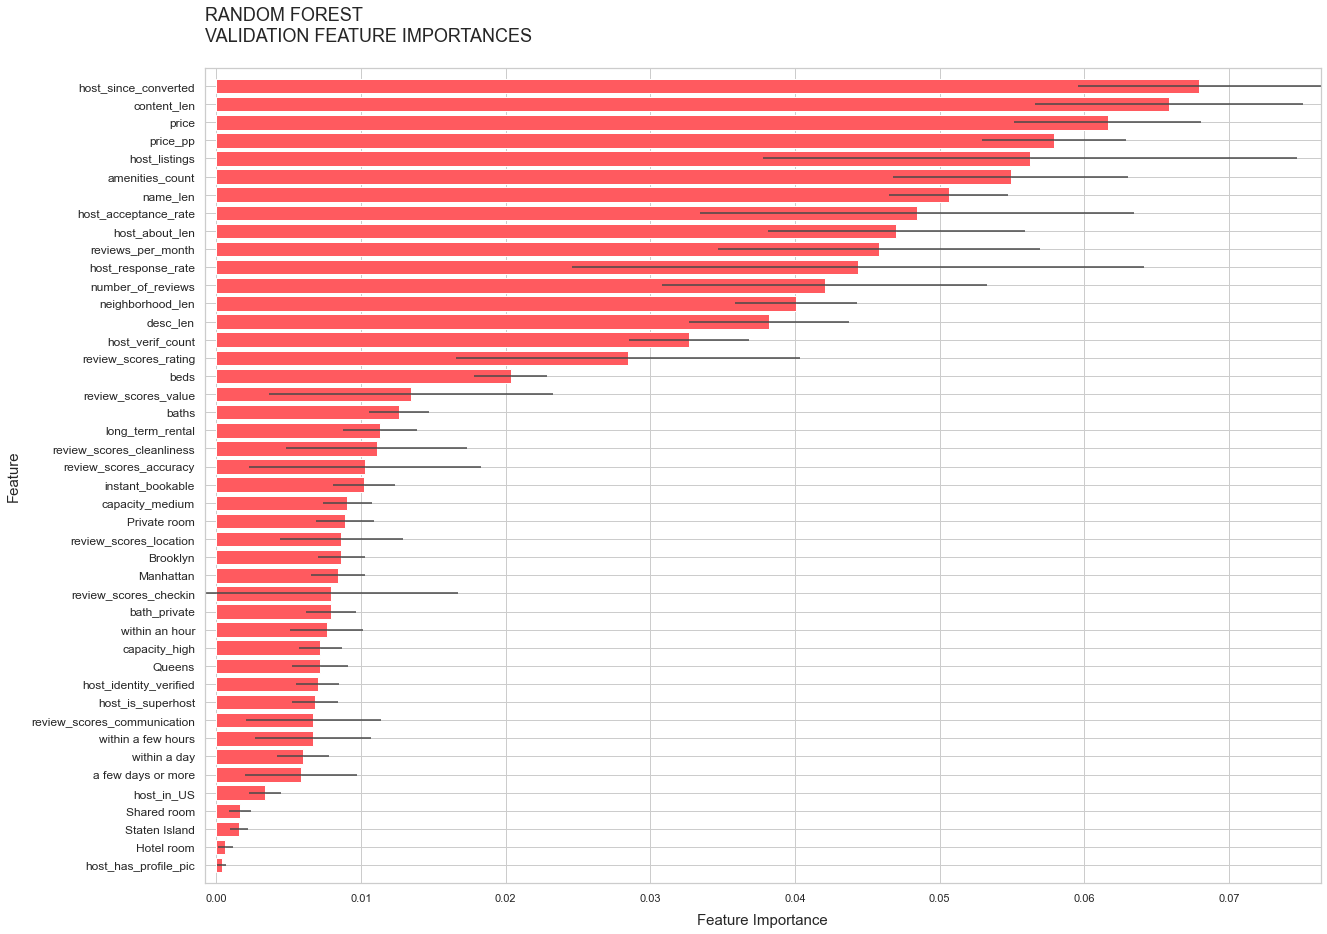

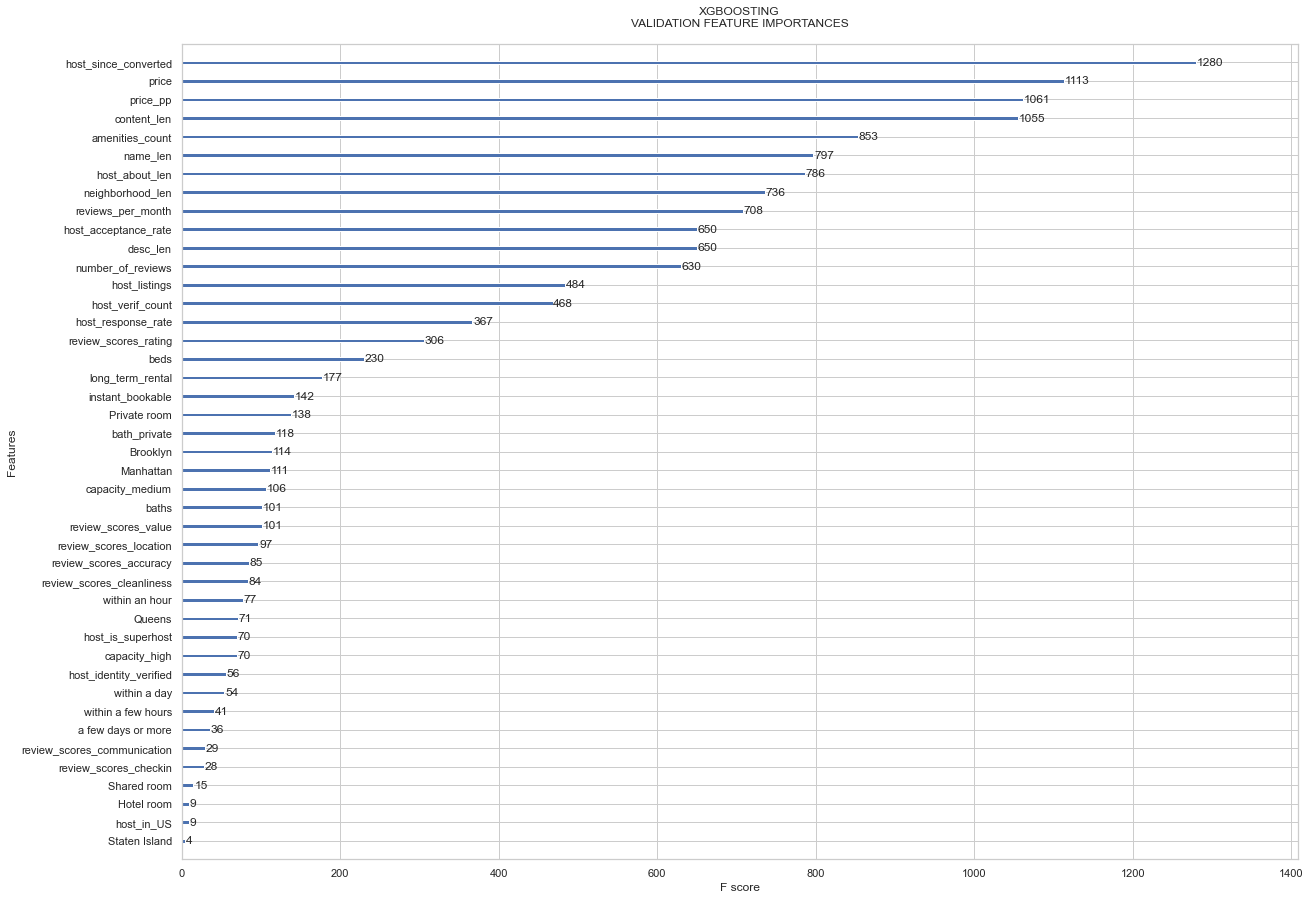

In [1379]:
# Compare Feature Importance Random Forest and XGBoosting


# Random Forest Validation | Plot feature importances

# compute feature importance and std
importances_rf = rf_cl.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_cl.estimators_],
             axis=0)
indices = np.argsort(importances)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("RANDOM FOREST\nVALIDATION FEATURE IMPORTANCES\n",fontsize = 18,loc = 'left')
plt.barh(range(X_val.shape[1]), importances_rf[indices],
       color = '#FF5A5F',ecolor ='#484848', xerr=std[indices], align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X_val.shape[1]), [features_rf_1.columns[i] for i in indices],fontsize = 12)
plt.ylim([-1, X_val.shape[1]])
plt.show()



# XGBoosting Validation | Plot feature importances(frequency)


# create dict to use later
features_boost = features_xgb_1.columns
dict_features = dict(enumerate(features_boost))

# feat importance with names f1,f2,...
axsub = xgb.plot_importance(xgb_cl,title = 'XGBOOSTING\nVALIDATION FEATURE IMPORTANCES\n')

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(features_boost))
lst_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [dict_features[int(i)] for i in lst_yticklabels]

axsub.set_yticklabels(lst_yticklabels)
plt.show();

----

The feature importance ranking on frequency are very similar between the Random Forest and the XGBoosting model. This gives us good confidence to proceed with **XGBoosting** as it significantly outperform its logistic regression counterpart and, by being the most sensitive to hyperparameter tuning (next step), we will likely have a larger margin of improvement with this model.

----

## XGBoost Hyperparameter Tuning

In [1447]:
# Run randomized search CV

# define base classifier
xgb_cl_search = xgb.XGBClassifier(objective='binary:logistic',verbose = 0,use_label_encoder=False)

# establish parameter grid
param_grid = {
        'max_depth': [6, 7, 8, 9, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0]}

# scorer in line with my metric of choice
fbeta_scorer = make_scorer(fbeta_score, beta=0.35)


# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(features_xgb_1, target, test_size=.2, random_state=42,stratify=target)


fit_params={"early_stopping_rounds":10,
            "eval_set" : [[X_test, y_test]]
               }

search = RandomizedSearchCV(estimator=xgb_cl_search, param_distributions=param_grid, n_jobs = -1, verbose = 0, scoring=fbeta_scorer, n_iter=50, random_state = 42)
search_result = search.fit(X_train, y_train, **fit_params)

print('Best Score: ', search_result.best_score_)
print('Best Params: ', search_result.best_params_)

[16:27:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:27:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68407
[1]	validation_0-logloss:0.67609
[2]	validation_0-logloss:0.66728
[3]	validation_0-logloss:0.65892
[4]	validation_0-logloss:0.65221
[5]	validation_0-logloss:0.64535
[6]	validation_0-logloss:0.63850
[7]	validation_0-logloss:0.63197
[8]	validation_0-logloss:0.62557
[9]	va

## Final Scoring

In [1486]:
# define X and Y
X = features_xgb_1
y = target

# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42,stratify=y)  

# define best XGBoosting model
xgb_best = xgb.XGBClassifier(n_estimators=30000,
                             objective='binary:logistic',
                             subsample = 0.9, 
                             min_child_weight = 3.0,
                             max_depth = 15,
                             learning_rate= 0.05, 
                             colsample_bytree = 0.5,
                             colsample_bylevel = 1.0,
                             n_jobs = -1,
                             random_state=42,
                             use_label_encoder =False)

# establish evaluation set
eval_set=[(X_train,y_train),(X_test,y_test)]

# fit model on train set
fit_best_xgb = xgb_best.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,  
                    early_stopping_rounds=50,
                    verbose=False,
                    eval_metric='error')

# compute preds
xgb_preds_best = xgb_best.predict(X_test, ntree_limit=xgb_best.best_ntree_limit)

# score model on test set (final model score)
xgb_fbeta_best = fbeta_score(y_test, xgb_preds_best, beta=0.35) # favoring precision
xgb_precision_best = precision_score(y_test, xgb_preds_best) 
xgb_recall_best = recall_score(y_test, xgb_preds_best)
xgb_accuracy_best = accuracy_score(y_test, xgb_preds_best) 

print(f'XGBoost | Test F beta (beta = 0.35): \t{xgb_fbeta_best}\n')
print(f'XGBoost | Test Precision: \t{xgb_precision_best}\n')
print(f'XGBoost | Test Recall: \t{xgb_recall_best}\n')
print(f'XGBoost | Test Accuracy: \t{xgb_accuracy_best}\n')

XGBoost | Test F beta (beta = 0.35): 	0.7388794851188972

XGBoost | Test Precision: 	0.7406826206355434

XGBoost | Test Recall: 	0.7244819646968534

XGBoost | Test Accuracy: 	0.735113330772186



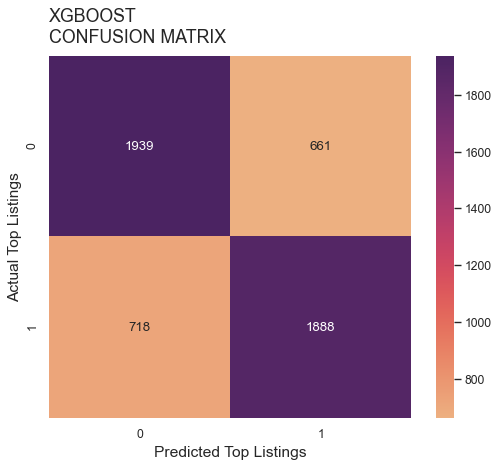

In [1568]:
# Confusion Matrix

xgb_best_confusion = confusion_matrix(y_test, xgb_preds_best)
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(xgb_best_confusion, cmap = 'flare', annot=True, square=True, fmt=".0f")

plt.xlabel('Predicted Top Listings',fontsize = 14)
plt.ylabel('Actual Top Listings',fontsize = 14)
plt.title('XGBOOST\nCONFUSION MATRIX', fontsize = 16, loc = 'left', pad = 12)
plt.savefig('/Users/valentinarizzati/Desktop/GitStuff/Projects/Classification-Airbnb/images/confusion.png');

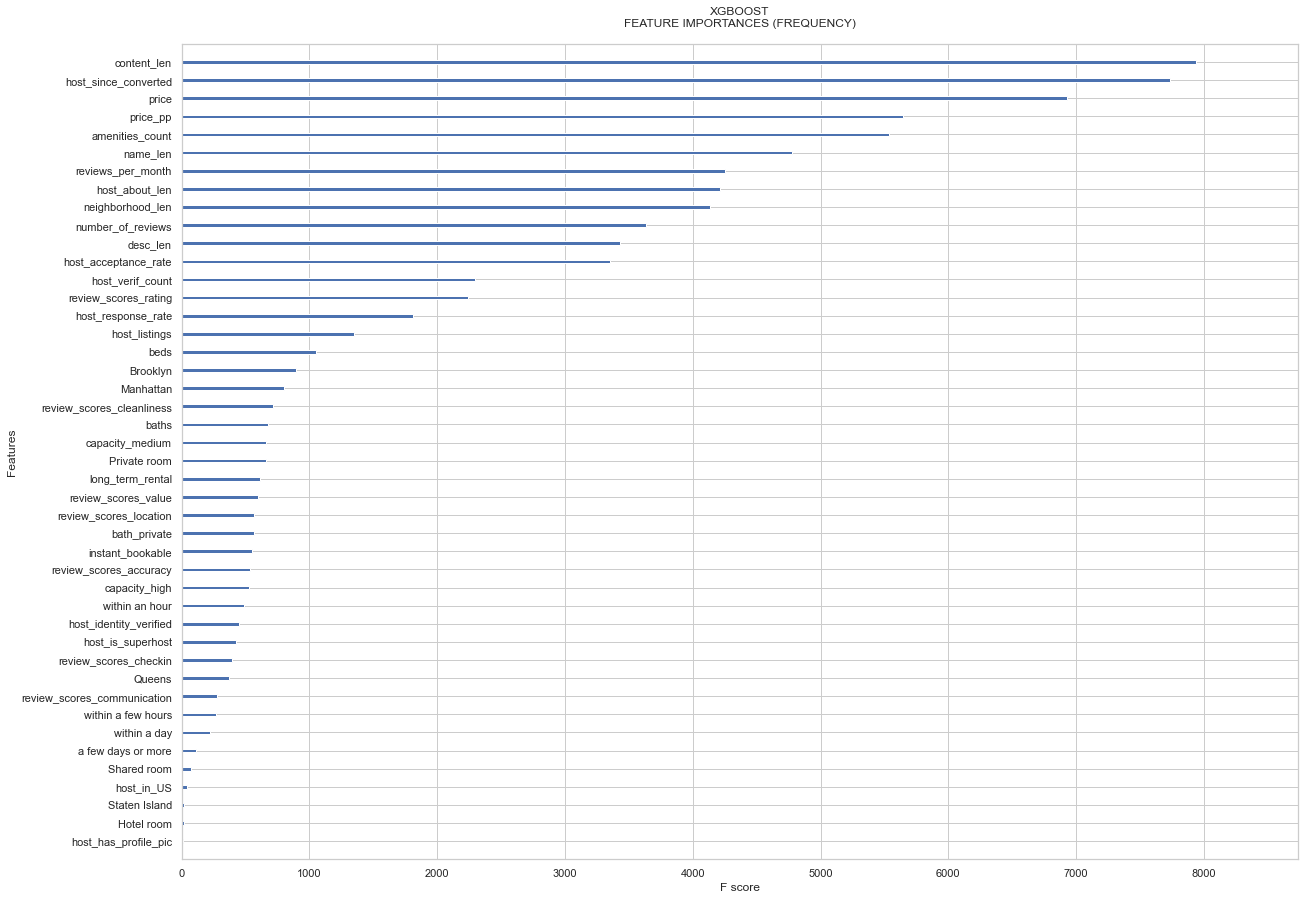

In [1481]:
# Plot feature importances(frequency)

plt.rcParams["figure.figsize"] = (20, 15)
sns.set_style('whitegrid')
xgb.plot_importance(xgb_best,importance_type='weight', show_values = False, title = 'XGBOOST\nFEATURE IMPORTANCES (FREQUENCY)\n')
plt.savefig('/Users/valentinarizzati/Desktop/GitStuff/Projects/Classification-Airbnb/images/feat_imp_plot_freq.png');

In [1471]:
# Feature Importance Table (frequency)

boost_best_f = xgb_best.get_booster().get_score(importance_type='weight')
xgb_best_f = pd.DataFrame(list(boost_best_f.items()),columns = ['feature','feature importance']).sort_values('feature importance', ascending=False)
xgb_best_f.set_index('feature', inplace=True)
xgb_best_f.index.name = None
xgb_best_f

feature importance
content_len                                7939
host_since_converted                       7736
price                                      6927
price_pp                                   5644
amenities_count                            5533
name_len                                   4778
reviews_per_month                          4254
host_about_len                             4215
neighborhood_len                           4134
number_of_reviews                          3633
desc_len                                   3434
host_acceptance_rate                       3351
host_verif_count                           2296
review_scores_rating                       2242
host_response_rate                         1809
host_listings                              1347
beds                                       1050
Brooklyn                                    897
Manhattan                                   801
review_scores_cleanliness                   716
baths                                       680
capacity_medium                             663
Private room                                662
long_term_rental                            617
review_scores_value                         596
review_scores_location                      570
bath_private                                565
instant_bookable                            549
review_scores_accuracy                      538
capacity_high                               527
within an hour                              485
host_identity_verified                      452
host_is_superhost                           426
review_scores_checkin                       392
Queens                                      374
review_scores_communication                 277
within a few hours                          268
within a day                                222
a few days or more                          115
Shared room                                  70
host_in_US                                   44
Hotel room                                   20
Staten Island                                20
host_has_profile_pic                         12

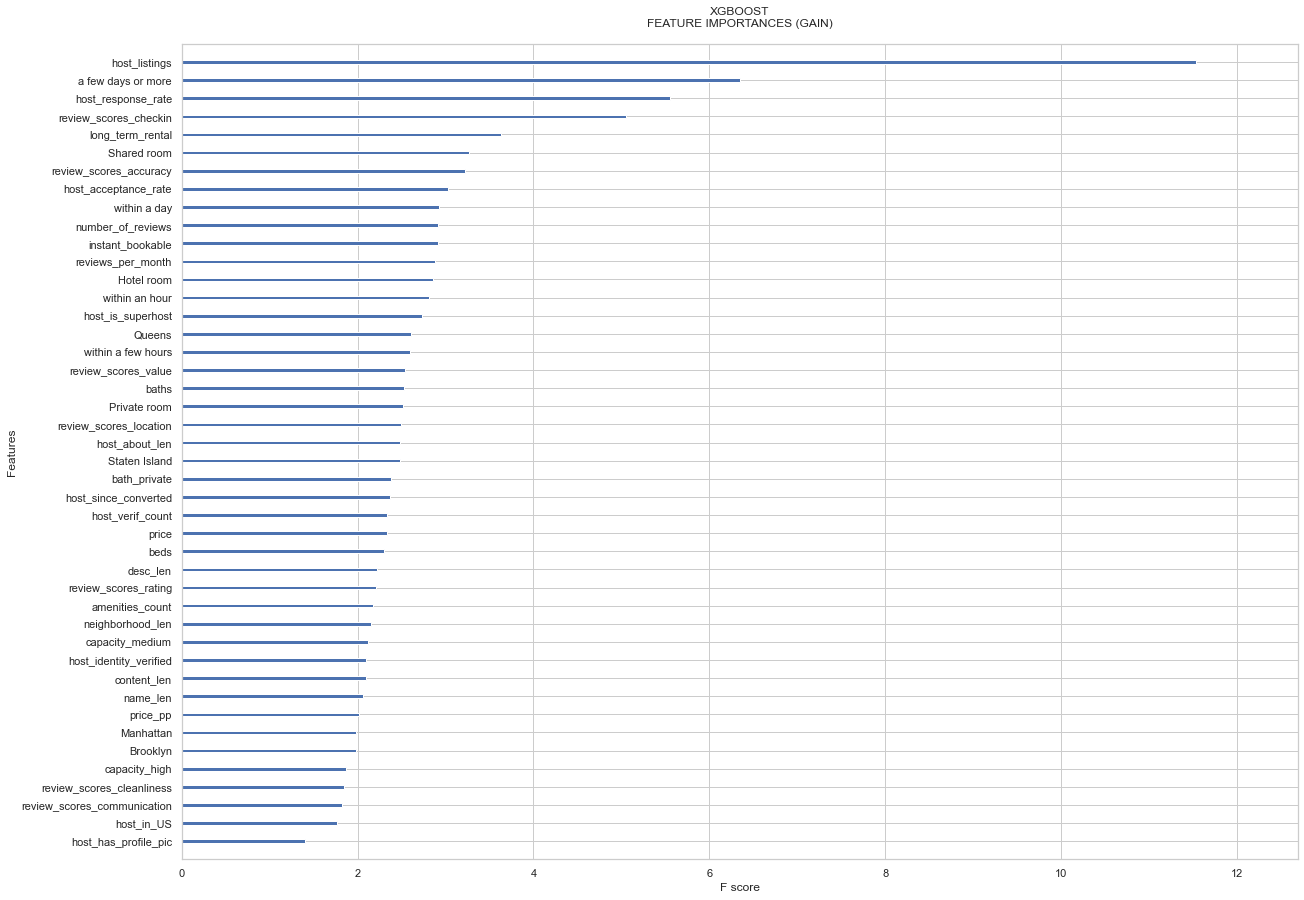

In [1482]:
# Plot feature importances(gain)

plt.rcParams["figure.figsize"] = (20, 15)
sns.set_style('whitegrid')
xgb.plot_importance(xgb_best,importance_type='gain', show_values = False, title = 'XGBOOST\nFEATURE IMPORTANCES (GAIN)\n')
plt.savefig('/Users/valentinarizzati/Desktop/GitStuff/Projects/Classification-Airbnb/images/feat_imp_plot_gain.png');

In [1484]:
# Feature Importance Table (gain)

boost_best_g = xgb_best.get_booster().get_score(importance_type='gain')
xgb_best_g = pd.DataFrame(list(boost_best_g.items()),columns = ['feature','feature importance']).sort_values('feature importance', ascending=False)
xgb_best_g.set_index('feature', inplace=True)
xgb_best_g.index.name = None
xgb_best_g

feature importance
host_listings                         11.532090
a few days or more                     6.347428
host_response_rate                     5.546832
review_scores_checkin                  5.046434
long_term_rental                       3.625153
Shared room                            3.264914
review_scores_accuracy                 3.216188
host_acceptance_rate                   3.031655
within a day                           2.924139
number_of_reviews                      2.915853
instant_bookable                       2.911483
reviews_per_month                      2.875054
Hotel room                             2.853836
within an hour                         2.811126
host_is_superhost                      2.731611
Queens                                 2.607380
within a few hours                     2.594740
review_scores_value                    2.540590
baths                                  2.527537
Private room                           2.520295
review_scores_location                 2.498302
host_about_len                         2.487622
Staten Island                          2.486521
bath_private                           2.376636
host_since_converted                   2.369242
host_verif_count                       2.336973
price                                  2.333672
beds                                   2.302823
desc_len                               2.222595
review_scores_rating                   2.208652
amenities_count                        2.180316
neighborhood_len                       2.157996
capacity_medium                        2.124306
host_identity_verified                 2.099201
content_len                            2.091451
name_len                               2.063450
price_pp                               2.011602
Manhattan                              1.984669
Brooklyn                               1.983648
capacity_high                          1.867526
review_scores_cleanliness              1.846582
review_scores_communication            1.826630
host_in_US                             1.765522
host_has_profile_pic                   1.400597

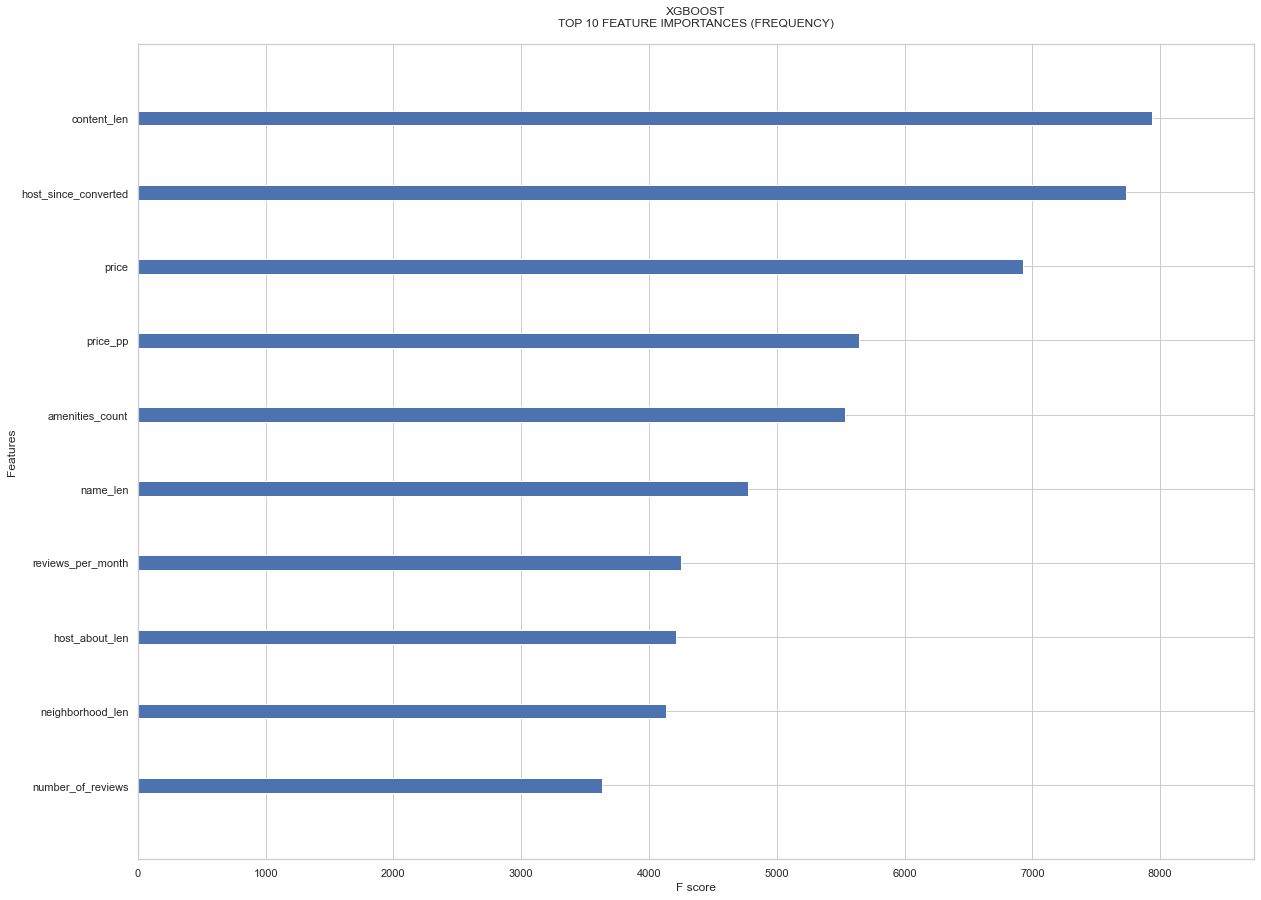

In [1570]:
# Plot feature importances(frequency)

plt.rcParams["figure.figsize"] = (20, 15)
sns.set_style('whitegrid')
xgb.plot_importance(xgb_best,importance_type='weight', max_num_features = 10, show_values = False, title = 'XGBOOST\nTOP 10 FEATURE IMPORTANCES (FREQUENCY)\n')
plt.savefig('/Users/valentinarizzati/Desktop/GitStuff/Projects/Classification-Airbnb/images/feat_imp_plot_freq_top_10.png');

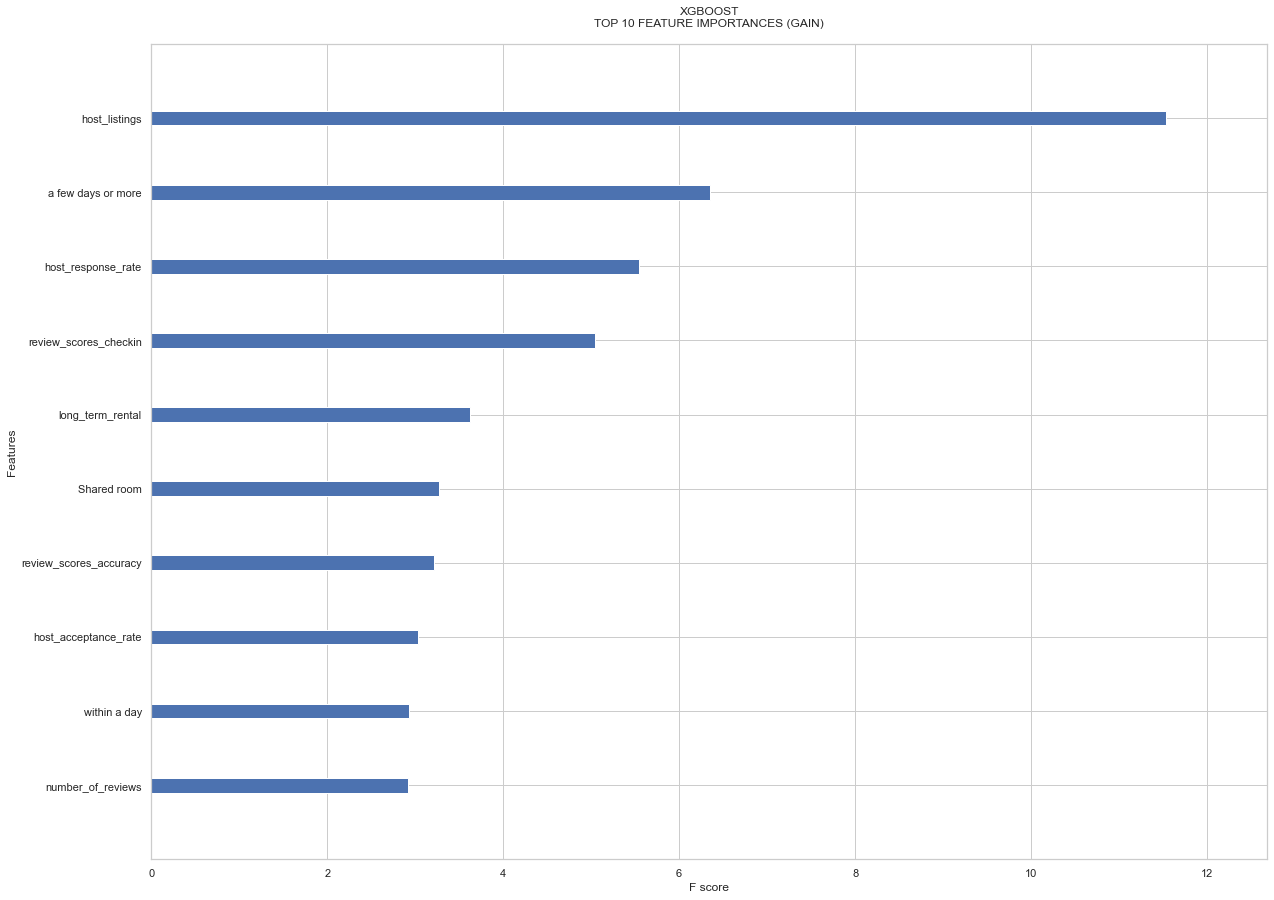

In [1571]:
# Plot feature importances(frequency)

plt.rcParams["figure.figsize"] = (20, 15)
sns.set_style('whitegrid')
xgb.plot_importance(xgb_best,importance_type='gain', max_num_features = 10, show_values = False, title = 'XGBOOST\nTOP 10 FEATURE IMPORTANCES (GAIN)\n')
plt.savefig('/Users/valentinarizzati/Desktop/GitStuff/Projects/Classification-Airbnb/images/feat_imp_plot_gain_top_10.png');